In [1]:
%load_ext rpy2.ipython

C:\Users\ChengXin\MyProgram\python\anaconda\pro\lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  "The symbol '%s' is not in this R namespace/package." % name


In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import urllib

In [3]:
%%R
data_folder = './'
setwd(data_folder)

In [139]:
import re
out_msstats = pd.read_csv("./PXD020248/out_msstats.csv")
def sub_mod(peptide):
    peptide = peptide.replace(".", "")
    peptide = re.sub("\(.*?\)", "", peptide)
    return peptide
    
print(len(out_msstats))
out_msstats["sequence"] = out_msstats.apply(lambda x: sub_mod(x["PeptideSequence"]), axis=1)
filtered_df = out_msstats.groupby('sequence').filter(lambda x: len(set(x["ProteinName"])) == 1)
filtered_df = filtered_df.groupby('ProteinName').filter(lambda x: len(set(x["sequence"])) >= 2)
filtered_df = filtered_df[-filtered_df["ProteinName"].str.contains(";")]
filtered_df.drop("sequence", axis=1, inplace=True)
print(len(filtered_df))
filtered_df.to_csv("./PXD020248/out_msstats_filter.csv", index=False)

564530
558076


In [77]:
%%R -w 800 -h 600

library('MSstats', warn.conflicts = F, quietly = T, verbose = F)

protein_expression = './PXD020248/protein_expression.csv'

raw.om <- read.csv('./PXD020248/out_msstats_filter.csv', header = TRUE, sep = ',')
raw.om <- raw.om[!grepl("DECOY", raw.om$ProteinName),]

raw.om <- OpenMStoMSstatsFormat(raw.om)
quantms.proposed <- MSstats::dataProcess(raw = raw.om,
                                           normalization = 'equalizeMedians',
                                           summaryMethod = 'TMP',
                                           censoredInt = "NA",
                                           MBimpute = TRUE)

# Write the expression protein log values into the expression csv 
head(quantms.proposed$ProteinLevelData)
Protein.Expression <- quantms.proposed$ProteinLevelData[, c('Protein', 'LogIntensities', 'GROUP', 'SUBJECT')]
head(Protein.Expression)
write.csv(Protein.Expression, file=protein_expression, row.names=FALSE)

INFO  [2022-09-20 17:07:18] ** Raw data from OpenMS imported successfully.
INFO  [2022-09-20 17:07:19] ** Raw data from OpenMS cleaned successfully.
INFO  [2022-09-20 17:07:19] ** Using annotation extracted from quantification data.
INFO  [2022-09-20 17:07:19] ** Run labels were standardized to remove symbols such as '.' or '%'.
INFO  [2022-09-20 17:07:19] ** The following options are used:
  - Features will be defined by the columns: PeptideSequence, PrecursorCharge, FragmentIon, ProductCharge
  - Shared peptides will be removed.
  - Proteins with single feature will not be removed.
  - Features with less than 3 measurements across runs will be removed.
INFO  [2022-09-20 17:07:20] ** Features with all missing measurements across runs are removed.
INFO  [2022-09-20 17:07:20] ** Shared peptides are removed.
INFO  [2022-09-20 17:07:22] ** Multiple measurements in a feature and a run are summarized by summaryforMultipleRows: max
INFO  [2022-09-20 17:07:23] ** Features with one or two meas

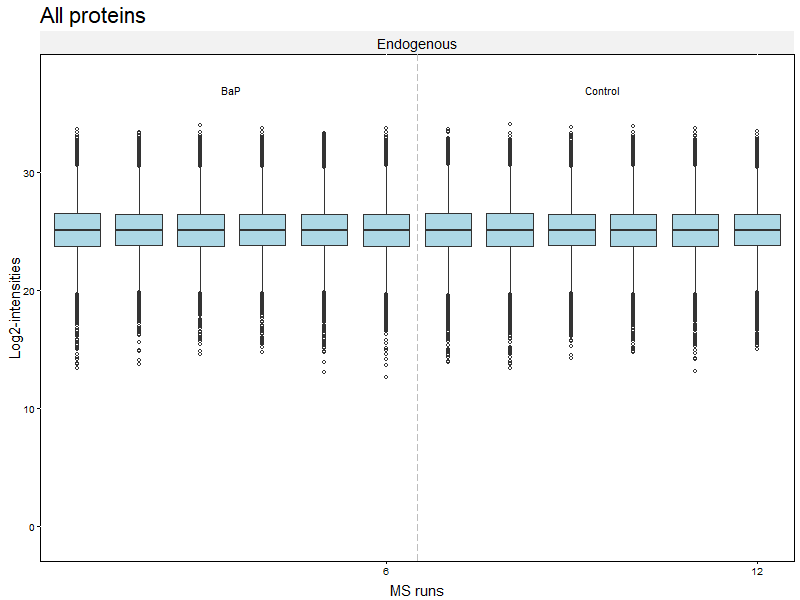

In [5]:
%%R -w 800 -h 600
tmp <- levels(quantms.proposed$ProcessedData$PROTEIN)
selector <- append('allonly', tmp, 1)
dataProcessPlots(data = quantms.proposed, type="QCPlot",which.Protein=selector,width=10, height=5, address=FALSE)

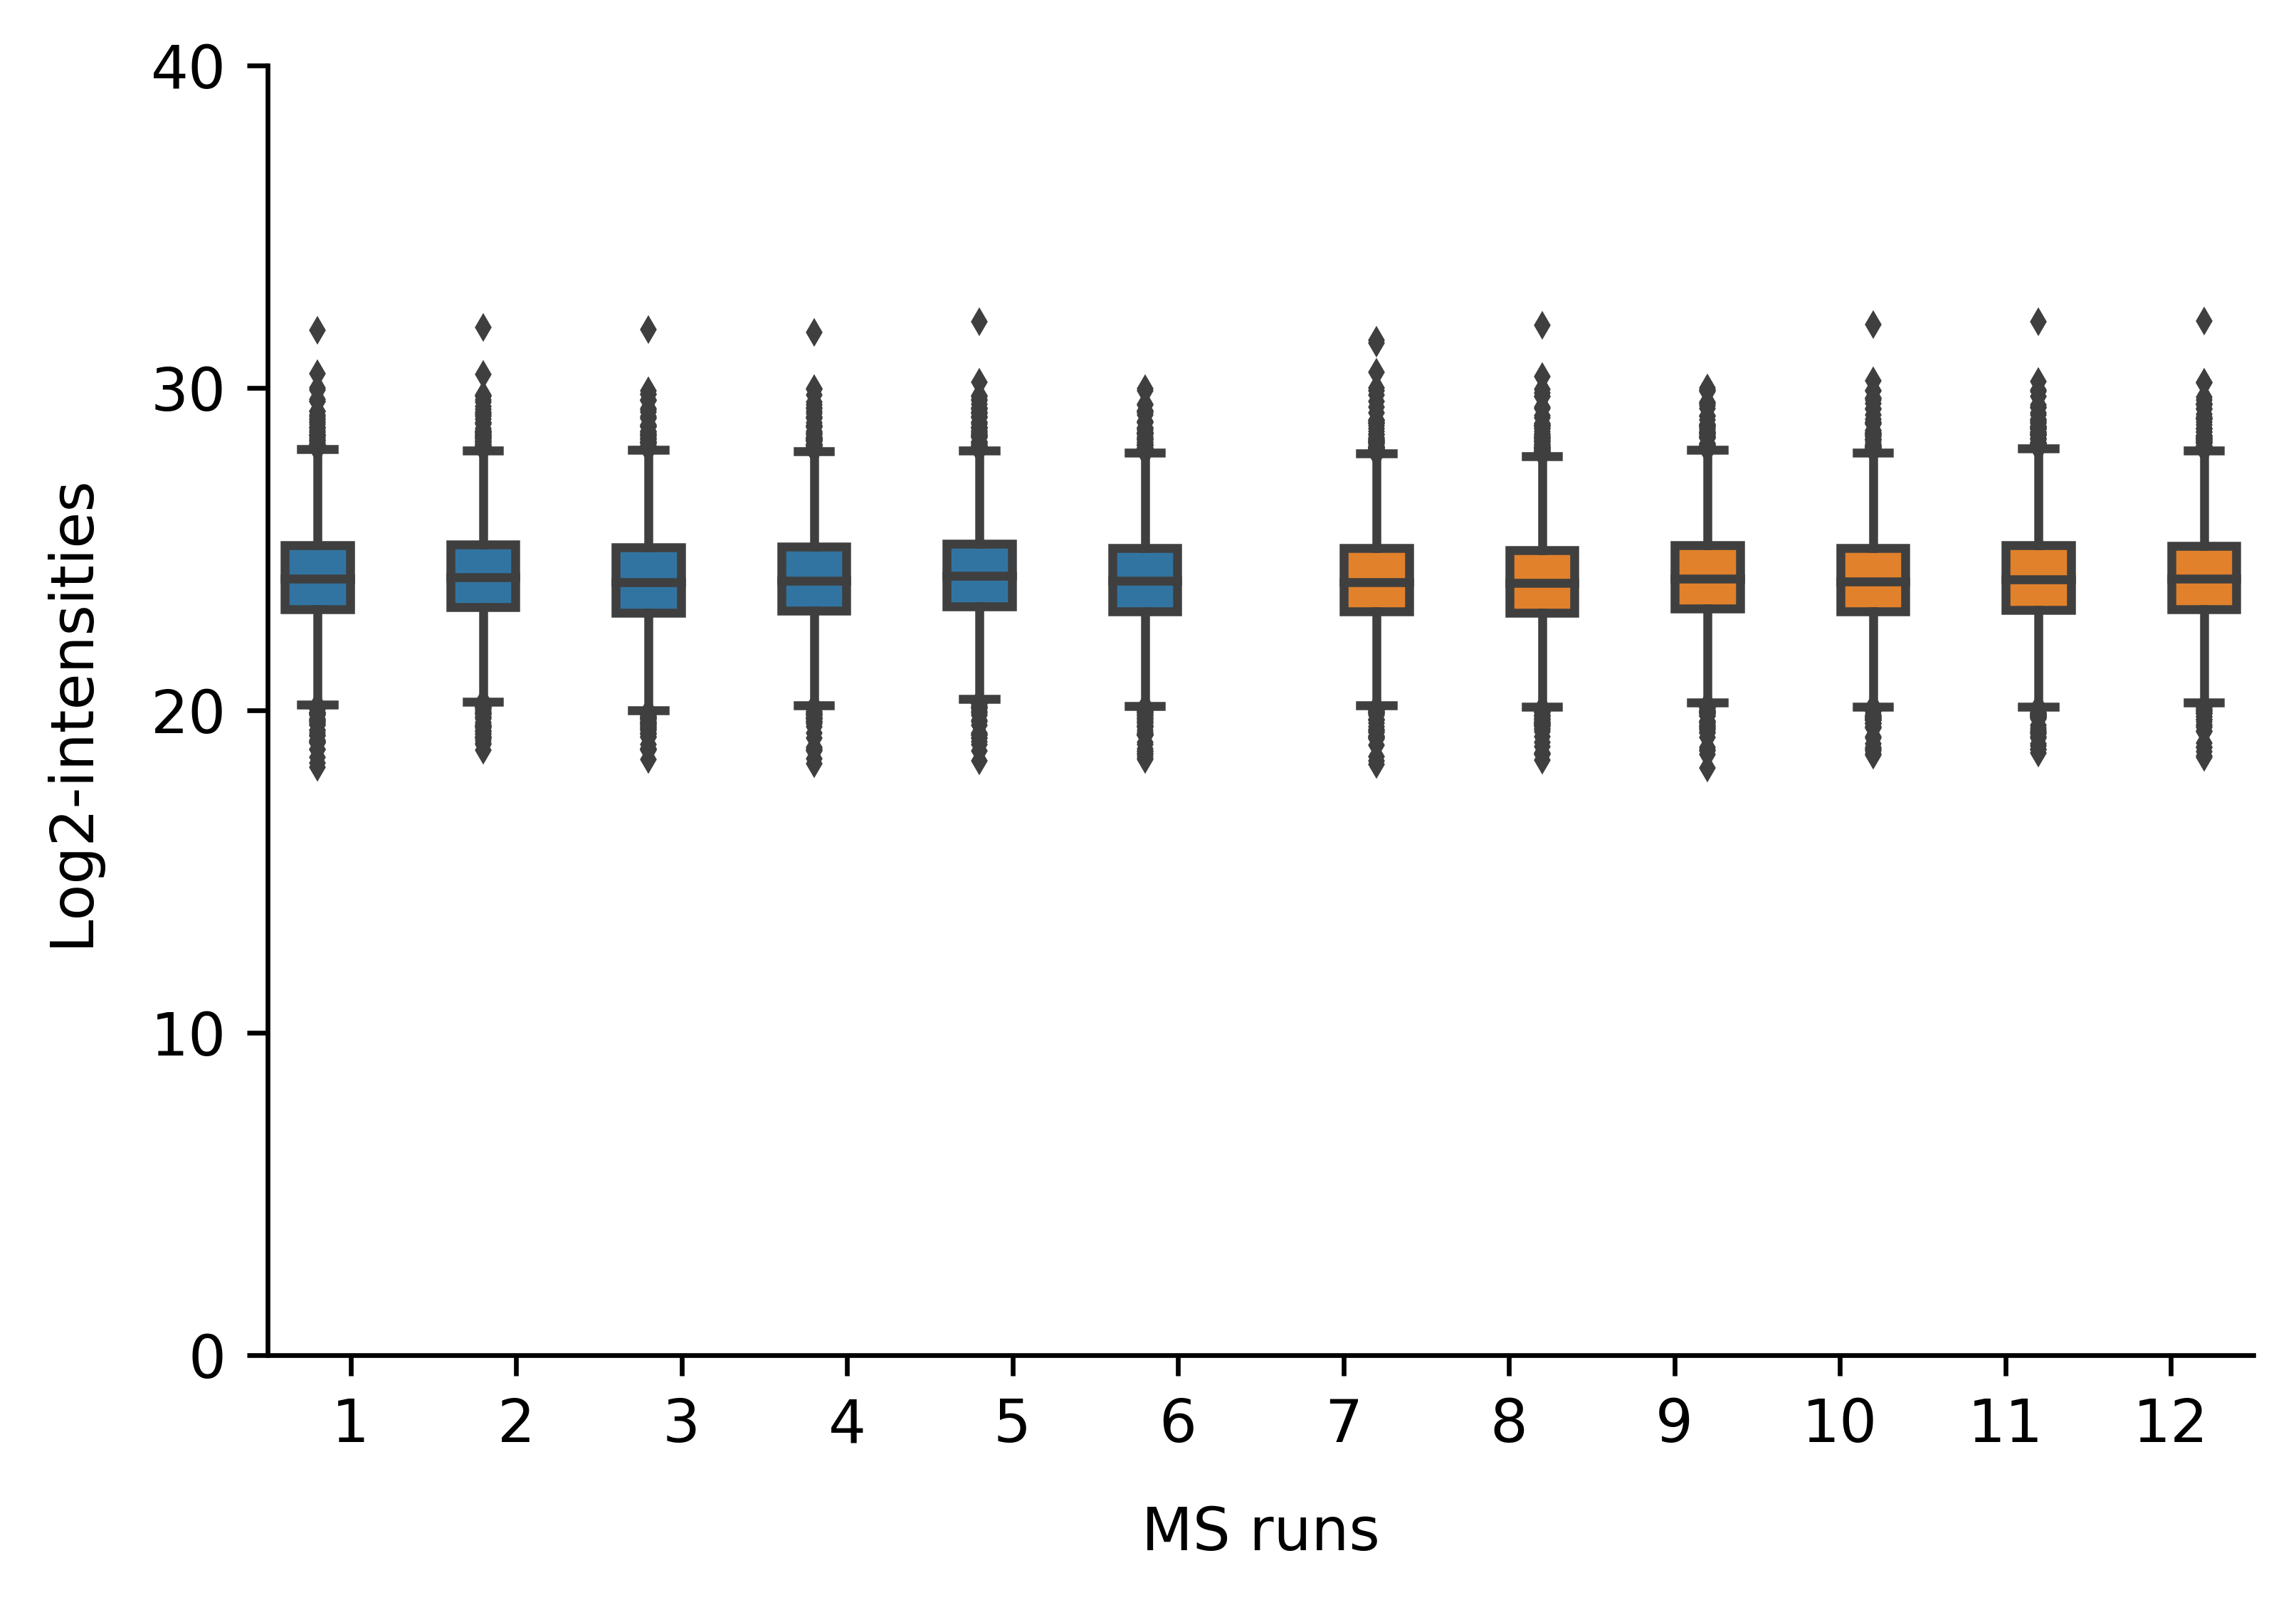

In [130]:

plt.figure(dpi=600)
ax = plt.axes()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

protein_expression = pd.read_csv("./PXD020248/protein_expression.csv", header=0, sep=",")

# protein_expression['GROUP'] = protein_expression['GROUP'].astype(cat_size_order)

sns.boxplot(x="SUBJECT", y="LogIntensities",data=protein_expression, fliersize=2, hue="GROUP")
plt.xlabel("MS runs",labelpad=8.5)
plt.ylabel("Log2-intensities",labelpad=8.5)
plt.ylim(0,40)

ax.get_legend().remove()
plt.yticks([0,10,20,30,40])

# plt.xticks([5, 11], [6, 12])

plt.show()

In [6]:
%%R

ac_groups = levels(quantms.proposed$FeatureLevelData$GROUP)
groups = levels(quantms.proposed$ProteinLevelData$GROUP)
print(ac_groups)

[1] "BaP"     "Control"


In [137]:
%%R

comparison_matrix = c(1, -1)
comparison <- matrix(comparison_matrix, nrow=1)

colnames(comparison) <- groups[order(as.numeric(groups))]
row.names(comparison) <- c("BaP vs Control")

ResultComparison <- groupComparison(contrast.matrix=comparison, data=quantms.proposed)
head(ResultComparison$ComparisonResult)
write.csv(ResultComparison$ComparisonResult, './PXD020248/filter_em_comparison_res.csv', row.names=FALSE,col.names=TRUE,sep=",")

INFO  [2022-09-09 21:15:41]  == Start to test and get inference in whole plot ...
  |======================================================================| 100%
INFO  [2022-09-09 21:16:19]  == Comparisons for all proteins are done.


In [147]:
%%R -w 800 -h 600

protein_expression = './PXD020248/quantile_protein_expression.csv'

raw.om <- read.csv('./PXD020248/out_msstats_filter.csv', header = TRUE, sep = ',')
raw.om <- raw.om[!grepl("DECOY", raw.om$ProteinName),]

raw.om <- OpenMStoMSstatsFormat(raw.om)
quantms.proposed <- MSstats::dataProcess(raw = raw.om,
                                           normalization = 'quantile',
                                           summaryMethod = 'TMP',
                                           censoredInt = "NA",
                                           MBimpute = TRUE)

# Write the expression protein log values into the expression csv 
head(quantms.proposed$ProteinLevelData)
Protein.Expression <- quantms.proposed$ProteinLevelData[, c('Protein', 'LogIntensities', 'GROUP', 'SUBJECT')]
head(Protein.Expression)
# write.csv(Protein.Expression, file=protein_expression, row.names=FALSE)



INFO  [2022-09-09 21:25:38] ** Raw data from OpenMS imported successfully.
INFO  [2022-09-09 21:25:40] ** Raw data from OpenMS cleaned successfully.
INFO  [2022-09-09 21:25:40] ** Using annotation extracted from quantification data.
INFO  [2022-09-09 21:25:40] ** Run labels were standardized to remove symbols such as '.' or '%'.
INFO  [2022-09-09 21:25:40] ** The following options are used:
  - Features will be defined by the columns: PeptideSequence, PrecursorCharge, FragmentIon, ProductCharge
  - Shared peptides will be removed.
  - Proteins with single feature will not be removed.
  - Features with less than 3 measurements across runs will be removed.
INFO  [2022-09-09 21:25:40] ** Features with all missing measurements across runs are removed.
INFO  [2022-09-09 21:25:41] ** Shared peptides are removed.
INFO  [2022-09-09 21:25:42] ** Multiple measurements in a feature and a run are summarized by summaryforMultipleRows: max
INFO  [2022-09-09 21:25:42] ** Features with one or two meas

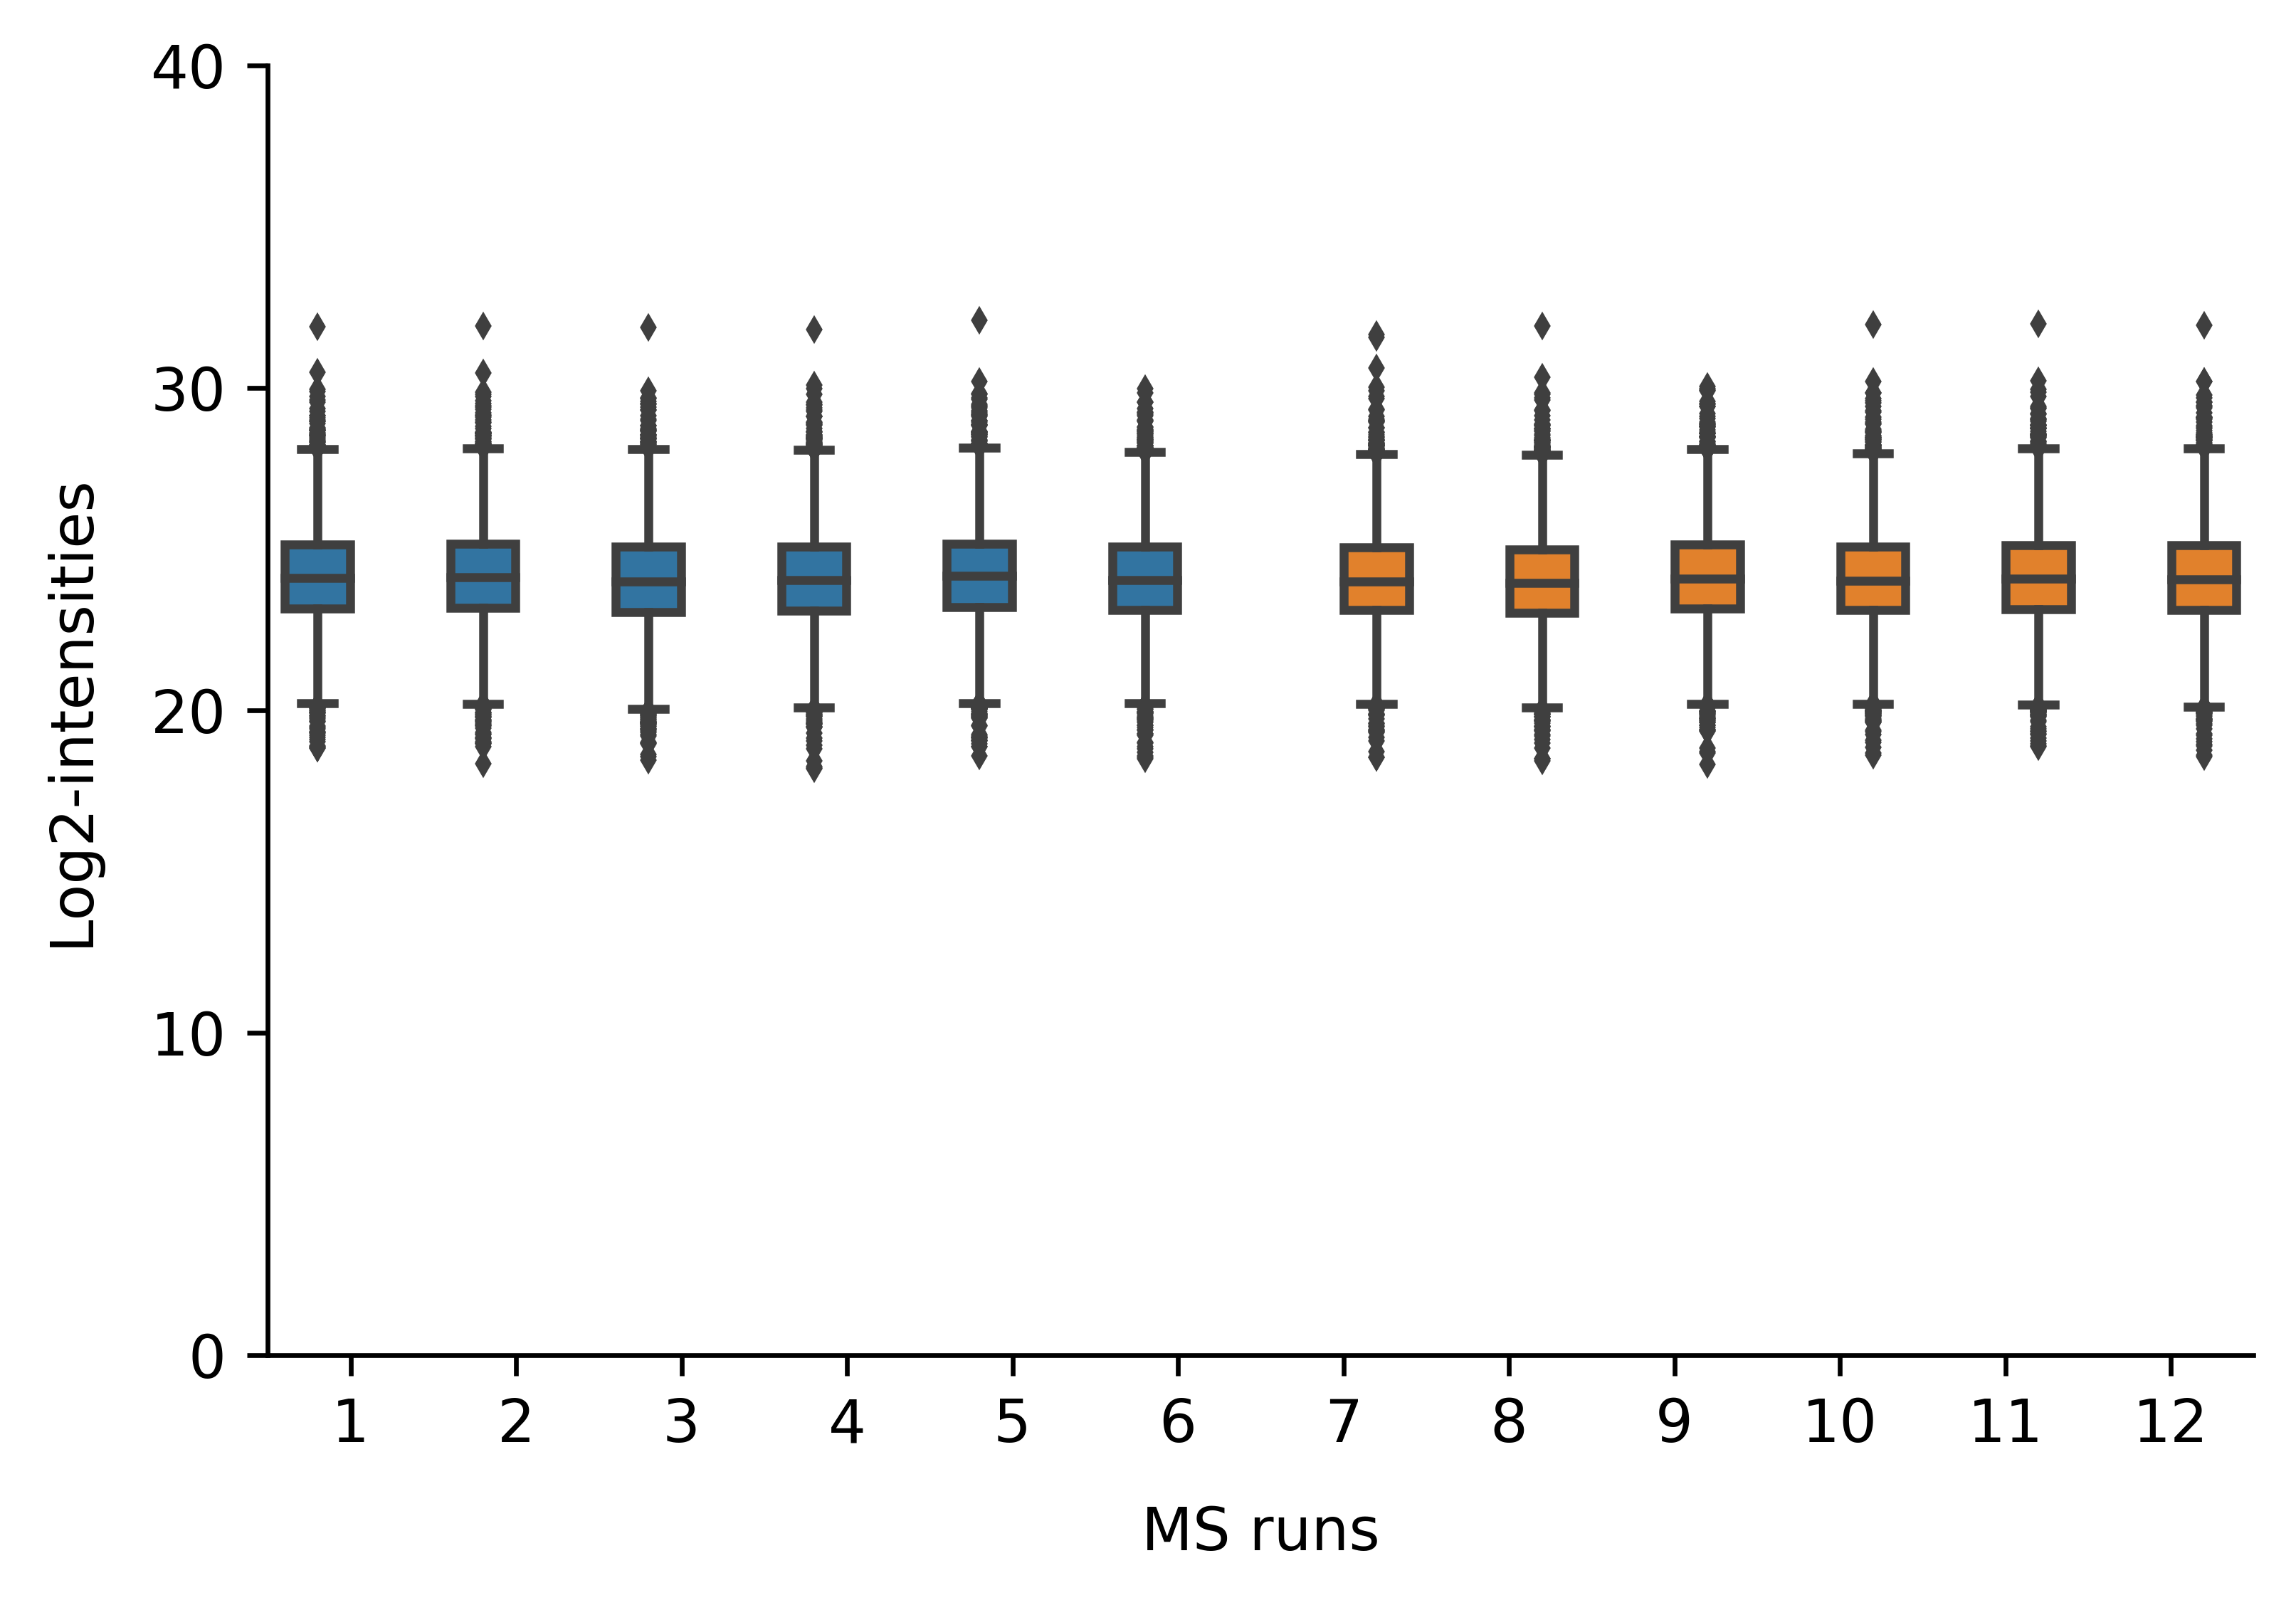

In [132]:

plt.figure(dpi=600)
ax = plt.axes()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

protein_expression = pd.read_csv("./PXD020248/quantile_protein_expression.csv", header=0, sep=",")

# protein_expression['GROUP'] = protein_expression['GROUP'].astype(cat_size_order)

sns.boxplot(x="SUBJECT", y="LogIntensities",data=protein_expression, fliersize=2, hue="GROUP")
plt.xlabel("MS runs",labelpad=8.5)
plt.ylabel("Log2-intensities",labelpad=8.5)
plt.ylim(0,40)
ax.get_legend().remove()
plt.yticks([0,10,20,30,40])

plt.show()

In [9]:
%%R

ac_groups = levels(quantms.proposed$FeatureLevelData$GROUP)
groups = levels(quantms.proposed$ProteinLevelData$GROUP)
print(ac_groups)

[1] "BaP"     "Control"


In [148]:
%%R

comparison_matrix = c(1, -1)
comparison <- matrix(comparison_matrix, nrow=1)

colnames(comparison) <- groups[order(as.numeric(groups))]
row.names(comparison) <- c("BaP vs Control")

ResultComparison <- groupComparison(contrast.matrix=comparison, data=quantms.proposed)
head(ResultComparison$ComparisonResult)
write.csv(ResultComparison$ComparisonResult, './PXD020248/quantile_comparison_res_filter.csv', row.names=FALSE,col.names=TRUE,sep=",")

INFO  [2022-09-09 21:29:21]  == Start to test and get inference in whole plot ...
  |======================================================================| 100%
INFO  [2022-09-09 21:29:59]  == Comparisons for all proteins are done.


In [149]:
%%R -w 800 -h 600

protein_expression = './PXD020248/no_normalization_protein_expression.csv'

raw.om <- read.csv('./PXD020248/out_msstats_filter.csv', header = TRUE, sep = ',')
raw.om <- raw.om[!grepl("DECOY", raw.om$ProteinName),]

raw.om <- OpenMStoMSstatsFormat(raw.om)
quantms.proposed <- MSstats::dataProcess(raw = raw.om,
                                           normalization = FALSE,
                                           summaryMethod = 'TMP',
                                           censoredInt = "NA",
                                           MBimpute = TRUE)

# Write the expression protein log values into the expression csv 
head(quantms.proposed$ProteinLevelData)
Protein.Expression <- quantms.proposed$ProteinLevelData[, c('Protein', 'LogIntensities', 'GROUP', 'SUBJECT')]
head(Protein.Expression)
# write.csv(Protein.Expression, file=protein_expression, row.names=FALSE)

INFO  [2022-09-09 21:30:03] ** Raw data from OpenMS imported successfully.
INFO  [2022-09-09 21:30:04] ** Raw data from OpenMS cleaned successfully.
INFO  [2022-09-09 21:30:04] ** Using annotation extracted from quantification data.
INFO  [2022-09-09 21:30:04] ** Run labels were standardized to remove symbols such as '.' or '%'.
INFO  [2022-09-09 21:30:04] ** The following options are used:
  - Features will be defined by the columns: PeptideSequence, PrecursorCharge, FragmentIon, ProductCharge
  - Shared peptides will be removed.
  - Proteins with single feature will not be removed.
  - Features with less than 3 measurements across runs will be removed.
INFO  [2022-09-09 21:30:05] ** Features with all missing measurements across runs are removed.
INFO  [2022-09-09 21:30:05] ** Shared peptides are removed.
INFO  [2022-09-09 21:30:06] ** Multiple measurements in a feature and a run are summarized by summaryforMultipleRows: max
INFO  [2022-09-09 21:30:06] ** Features with one or two meas

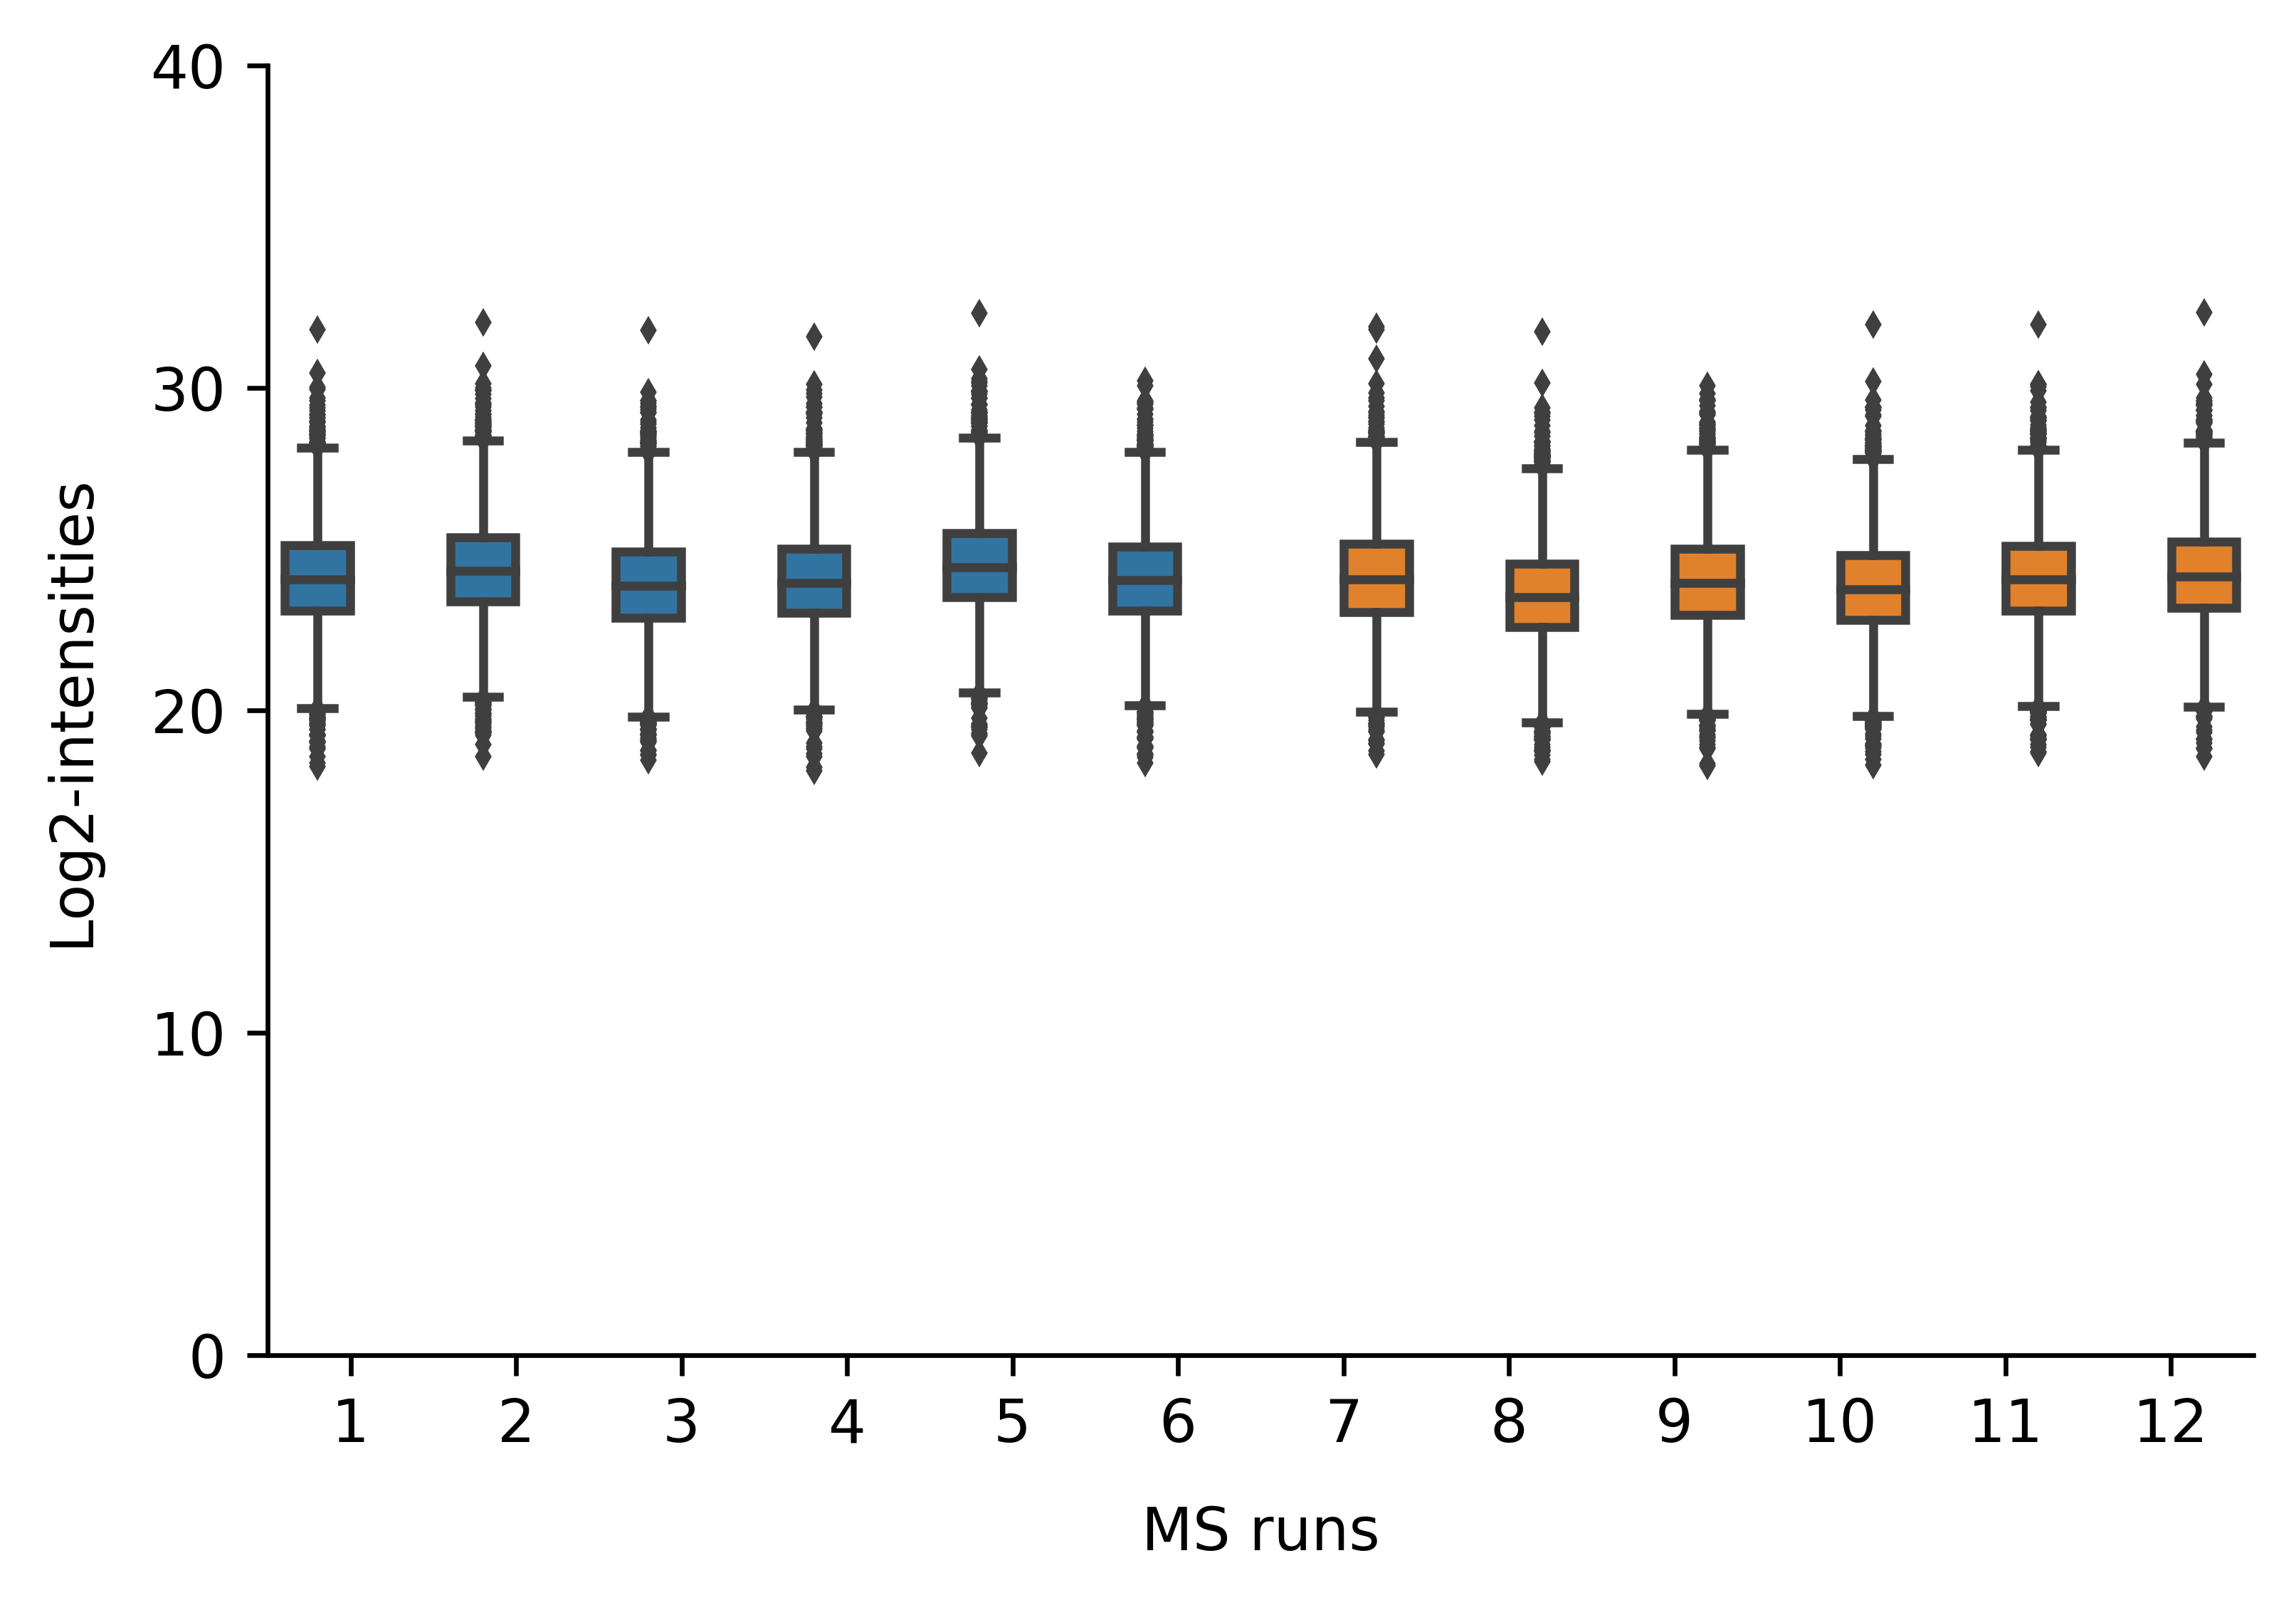

In [133]:

plt.figure(dpi=600)
ax = plt.axes()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

protein_expression = pd.read_csv("./PXD020248/no_normalization_protein_expression.csv", header=0, sep=",")

sns.boxplot(x="SUBJECT", y="LogIntensities",data=protein_expression, fliersize=2, hue="GROUP")
plt.xlabel("MS runs",labelpad=8.5)
plt.ylabel("Log2-intensities",labelpad=8.5)
plt.ylim(0,40)
ax.get_legend().remove()
plt.yticks([0,10,20,30,40])

plt.show()

In [12]:
%%R

ac_groups = levels(quantms.proposed$FeatureLevelData$GROUP)
groups = levels(quantms.proposed$ProteinLevelData$GROUP)
print(ac_groups)

[1] "BaP"     "Control"


In [150]:
%%R

comparison_matrix = c(1, -1)
comparison <- matrix(comparison_matrix, nrow=1)

colnames(comparison) <- groups[order(as.numeric(groups))]
row.names(comparison) <- c("BaP vs Control")

ResultComparison <- groupComparison(contrast.matrix=comparison, data=quantms.proposed)
head(ResultComparison$ComparisonResult)
write.csv(ResultComparison$ComparisonResult, './PXD020248/no_normalization_comparison_res_filter.csv', row.names=FALSE,col.names=TRUE,sep=",")

INFO  [2022-09-09 21:33:33]  == Start to test and get inference in whole plot ...
  |======================================================================| 100%
INFO  [2022-09-09 21:34:16]  == Comparisons for all proteins are done.


### Proteus

In [140]:
import re
from collections import Counter

def clean_PeptideSequence(pep_seq):
    pattern = re.compile(r"\(.*?\)")
    pep_seq = pep_seq.replace(".", "")
    return pattern.sub("", pep_seq)

def modified_PeptideSequence(pep_seq):
    pattern = re.compile(r"\(.*?\)")
    t_pep_seq = pep_seq.replace(".", "").replace("Acetyl", "ac").replace("Carbamidomethyl", "ca").replace("Oxidation", "ox")
    t_pep_seq = "_" + t_pep_seq + "_"
    return t_pep_seq

def get_modifications(pep_seq):
    pattern = re.compile(r"\(.*?\)")
    t = ""
    modifications = re.findall(pattern, pep_seq)
    if len(modifications) == 0:
        return "Unmodified"
    c = Counter(modifications)
    for key, value in c.items():
        if value == 1:
            c[key] = ""
        else:
            c[key] = str(c[key]) + " "
    modifications = ",".join(modifications)
    if "(Acetyl)" in c:
        modifications = modifications.replace("(Acetyl)", c["(Acetyl)"] + "Acetyl (Protein N-term)")
    if "(Carbamidomethyl)" in c:
        modifications = modifications.replace("(Carbamidomethyl)", c["(Carbamidomethyl)"] + "Carbamidomethyl (C)")
    if "(Oxidation)" in c:
        modifications = modifications.replace("(Oxidation)", c["(Oxidation)"] + "Oxidation (M)")
        
    return modifications

def get_experiment(row):
    return "_".join(row['Reference'].split("_")[-3:-1])
    
    
evi = pd.DataFrame(None, columns=['sequence', 'modified_sequence', 'modifications', 'protein_group', 
                                  'protein', 'experiment', 'charge', 'reverse', 'contaminant', 'intensity'])
quantms = pd.read_csv("./PXD020248/out_msstats_filter.csv", sep=',', header=0)
quantms = quantms[-quantms['ProteinName'].str.contains("DECOY_")]
evi['sequence'] = quantms.apply(lambda x: clean_PeptideSequence(x['PeptideSequence']), axis=1)
evi['modified_sequence'] = quantms.apply(lambda x: modified_PeptideSequence(x['PeptideSequence']), axis=1)
evi['modifications'] = quantms.apply(lambda x: get_modifications(x['PeptideSequence']), axis=1)
evi['protein_group'] = quantms['ProteinName']
evi['protein'] = quantms['ProteinName']
evi['experiment'] = quantms.apply(lambda x: get_experiment(x), axis=1)
evi['charge'] = quantms['PrecursorCharge']
evi['intensity'] = quantms['Intensity']
evi.to_csv("./PXD020248/evi.txt", sep='\t', index=False)

metadata = pd.DataFrame(None, columns=['experiment', 'measure', 'sample', 'condition', 'replicate'])
metadata['experiment'] = ["BaP_BP1", "BaP_BP2", "BaP_BP3", "BaP_BP4", "BaP_BP5", "BaP_BP6", 
                          "DMSO_BP1", "DMSO_BP2", "DMSO_BP3", "DMSO_BP4", "DMSO_BP5", "DMSO_BP6"]
metadata['measure'] = ['Intensity'] * 12
metadata['sample'] = ["BaP_BP1", "BaP_BP2", "BaP_BP3", "BaP_BP4", "BaP_BP5", "BaP_BP6", 
                    "DMSO_BP1", "DMSO_BP2", "DMSO_BP3", "DMSO_BP4", "DMSO_BP5", "DMSO_BP6"]
metadata['condition'] = ["BaP"]*6 + ["Control"]*6
metadata['replicate'] = [1, 2, 3, 4, 5, 6] * 2
metadata.to_csv("./PXD020248/metadata.txt", sep="\t", index=False)


In [141]:
%%R
library(proteus)

evi = read.csv("./PXD020248/evi.txt", sep="\t", header=TRUE)
meta = read.csv("./PXD020248/metadata.txt", sep="\t", header=TRUE)
pepdat <- makePeptideTable(evi, meta)

In [142]:
%%R
summary(pepdat)


*** Basic statistics ***

  content = peptide
  experiment type = label-free
  number of samples = 12
  number of conditions = 2
  number of peptides = 47839
  samples = BaP_BP1, BaP_BP2, BaP_BP3, BaP_BP4, BaP_BP5, BaP_BP6, DMSO_BP1, DMSO_BP2, DMSO_BP3, DMSO_BP4, DMSO_BP5, DMSO_BP6
  conditions = BaP, Control

*** Data processing ***

  evidence columns used = Intensity
  sequence = 'Sequence'
  protein = 'Leading razor protein'
  normalization = identity


In [143]:
%%R
prodat <- makeProteinTable(pepdat)
head(prodat$tab)

                       BaP_BP1   BaP_BP2  BaP_BP3   BaP_BP4   BaP_BP5  BaP_BP6
sp|A0AV96|RBM47_HUMAN  4598133        NA  3355623   6058601   6791574  5271443
sp|A0AVT1|UBA6_HUMAN  48779447 217821713 79376927  62665367 106656500 88846370
sp|A0MZ66|SHOT1_HUMAN 52645143  77617393 60505248  52378477  91306580 65448450
sp|A1L0T0|HACL2_HUMAN 16075129  26161948 15788448  16790048  20988483 23564690
sp|A2RRP1|NBAS_HUMAN   5707527   9898417  5408890   8416626  19606713  8691229
sp|A2RTX5|SYTC2_HUMAN  4400629        NA       NA 379927500   5073392       NA
                      DMSO_BP1 DMSO_BP2 DMSO_BP3 DMSO_BP4 DMSO_BP5 DMSO_BP6
sp|A0AV96|RBM47_HUMAN  4993928  2895368       NA  3538411       NA  7212971
sp|A0AVT1|UBA6_HUMAN  88065657 25176007 35426173 29531053 59465650 47148510
sp|A0MZ66|SHOT1_HUMAN 41762070 61001193 64985866 80121500 76969647 62076718
sp|A1L0T0|HACL2_HUMAN 10117444 11972207 16257650 12153491 17932821 18744395
sp|A2RRP1|NBAS_HUMAN  65445443  8030897  8804476 12370414 11532256 

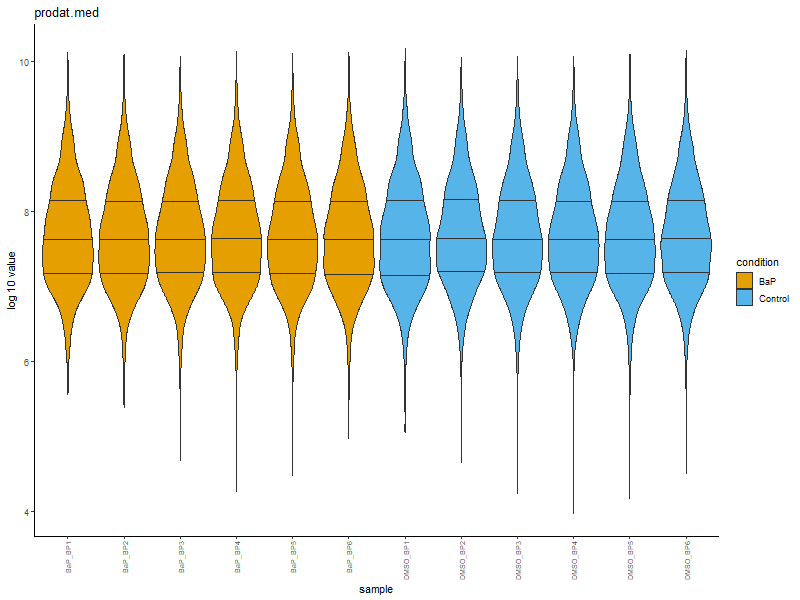

In [144]:
%%R -w 800 -h 600

prodat.med <- normalizeData(prodat)
prodat.quant <- normalizeData(prodat, norm.fun=limma::normalizeQuantiles)
plotSampleDistributions(prodat.med, title="prodat.med", fill="condition", method="violin")
# write.csv(prodat.quant$tab, file="./PXD020248/prodatquantile.csv")

In [47]:
%%R
write.csv(prodat.quant$tab, file="./PXD020248/prodatquantile.csv")
write.csv(prodat$tab, file="./PXD020248/prodat.csv")

In [145]:
%%R
res <- limmaDE(prodat, sig.level=0.05)
write.csv(res, file="./PXD020248/prodat_comp_res_filter.csv")

res <- limmaDE(prodat.med, sig.level=0.05)
write.csv(res, file="./PXD020248/prodat_med_comp_res_filter.csv")

res <- limmaDE(prodat.quant, sig.level=0.05)
write.csv(res, file="./PXD020248/prodat_quantile_comp_res_filter.csv")

head(res)

                protein       logFC  AveExpr          t    P.Value adj.P.Val
1 sp|A0AV96|RBM47_HUMAN  0.02815449 22.23535  0.1486400 0.88529802 0.9754180
2  sp|A0AVT1|UBA6_HUMAN -0.86456270 25.90475 -2.8375953 0.01550943 0.4555063
3 sp|A0MZ66|SHOT1_HUMAN  0.14109763 25.95227  0.6942454 0.50129510 0.8770048
4 sp|A1L0T0|HACL2_HUMAN -0.28112379 24.00045 -1.8050917 0.09725154 0.6299979
5  sp|A2RRP1|NBAS_HUMAN  0.82509678 23.39256  1.8710007 0.08696032 0.6229436
6 sp|A2RTX5|SYTC2_HUMAN -3.07807829 22.95196 -1.3273058 0.24755443 0.7590859
          B significant mean_BaP mean_Control ngood_BaP ngood_Control
1 -5.829998       FALSE 22.22283     22.25099         5             4
2 -2.930985       FALSE 26.33703     25.47247         6             6
3 -5.740313       FALSE 25.88172     26.02282         6             6
4 -4.531202       FALSE 24.14101     23.85989         6             6
5 -4.437504       FALSE 22.98001     23.80511         6             6
6 -4.808627       FALSE 24.18319     21.1

In [109]:
import re

prodatmed = pd.read_csv("./PXD020248/prodatmed.csv", index_col=0)

def return_ms_runs(row):
    if "BaP" in row["MS runs"]:
        return re.findall("\d", row["MS runs"])[0]
    else:
        return int(re.findall("\d", row["MS runs"])[0]) + 6

prodatmed = prodatmed.reset_index() #将索引转化为Series
prodatmed_long = prodatmed.melt(id_vars=["index"])
prodatmed_long.rename(columns={"index": "ProteinName", "variable": "MS runs", "value": "Intensity"}, inplace=True)
prodatmed_long.dropna(how="any", inplace=True)
prodatmed_long["LogIntensities"] = prodatmed_long.apply(lambda x: np.log2(x["Intensity"]), axis=1)
prodatmed_long["SUBJECT"] = prodatmed_long.apply(lambda x: return_ms_runs(x), axis=1)

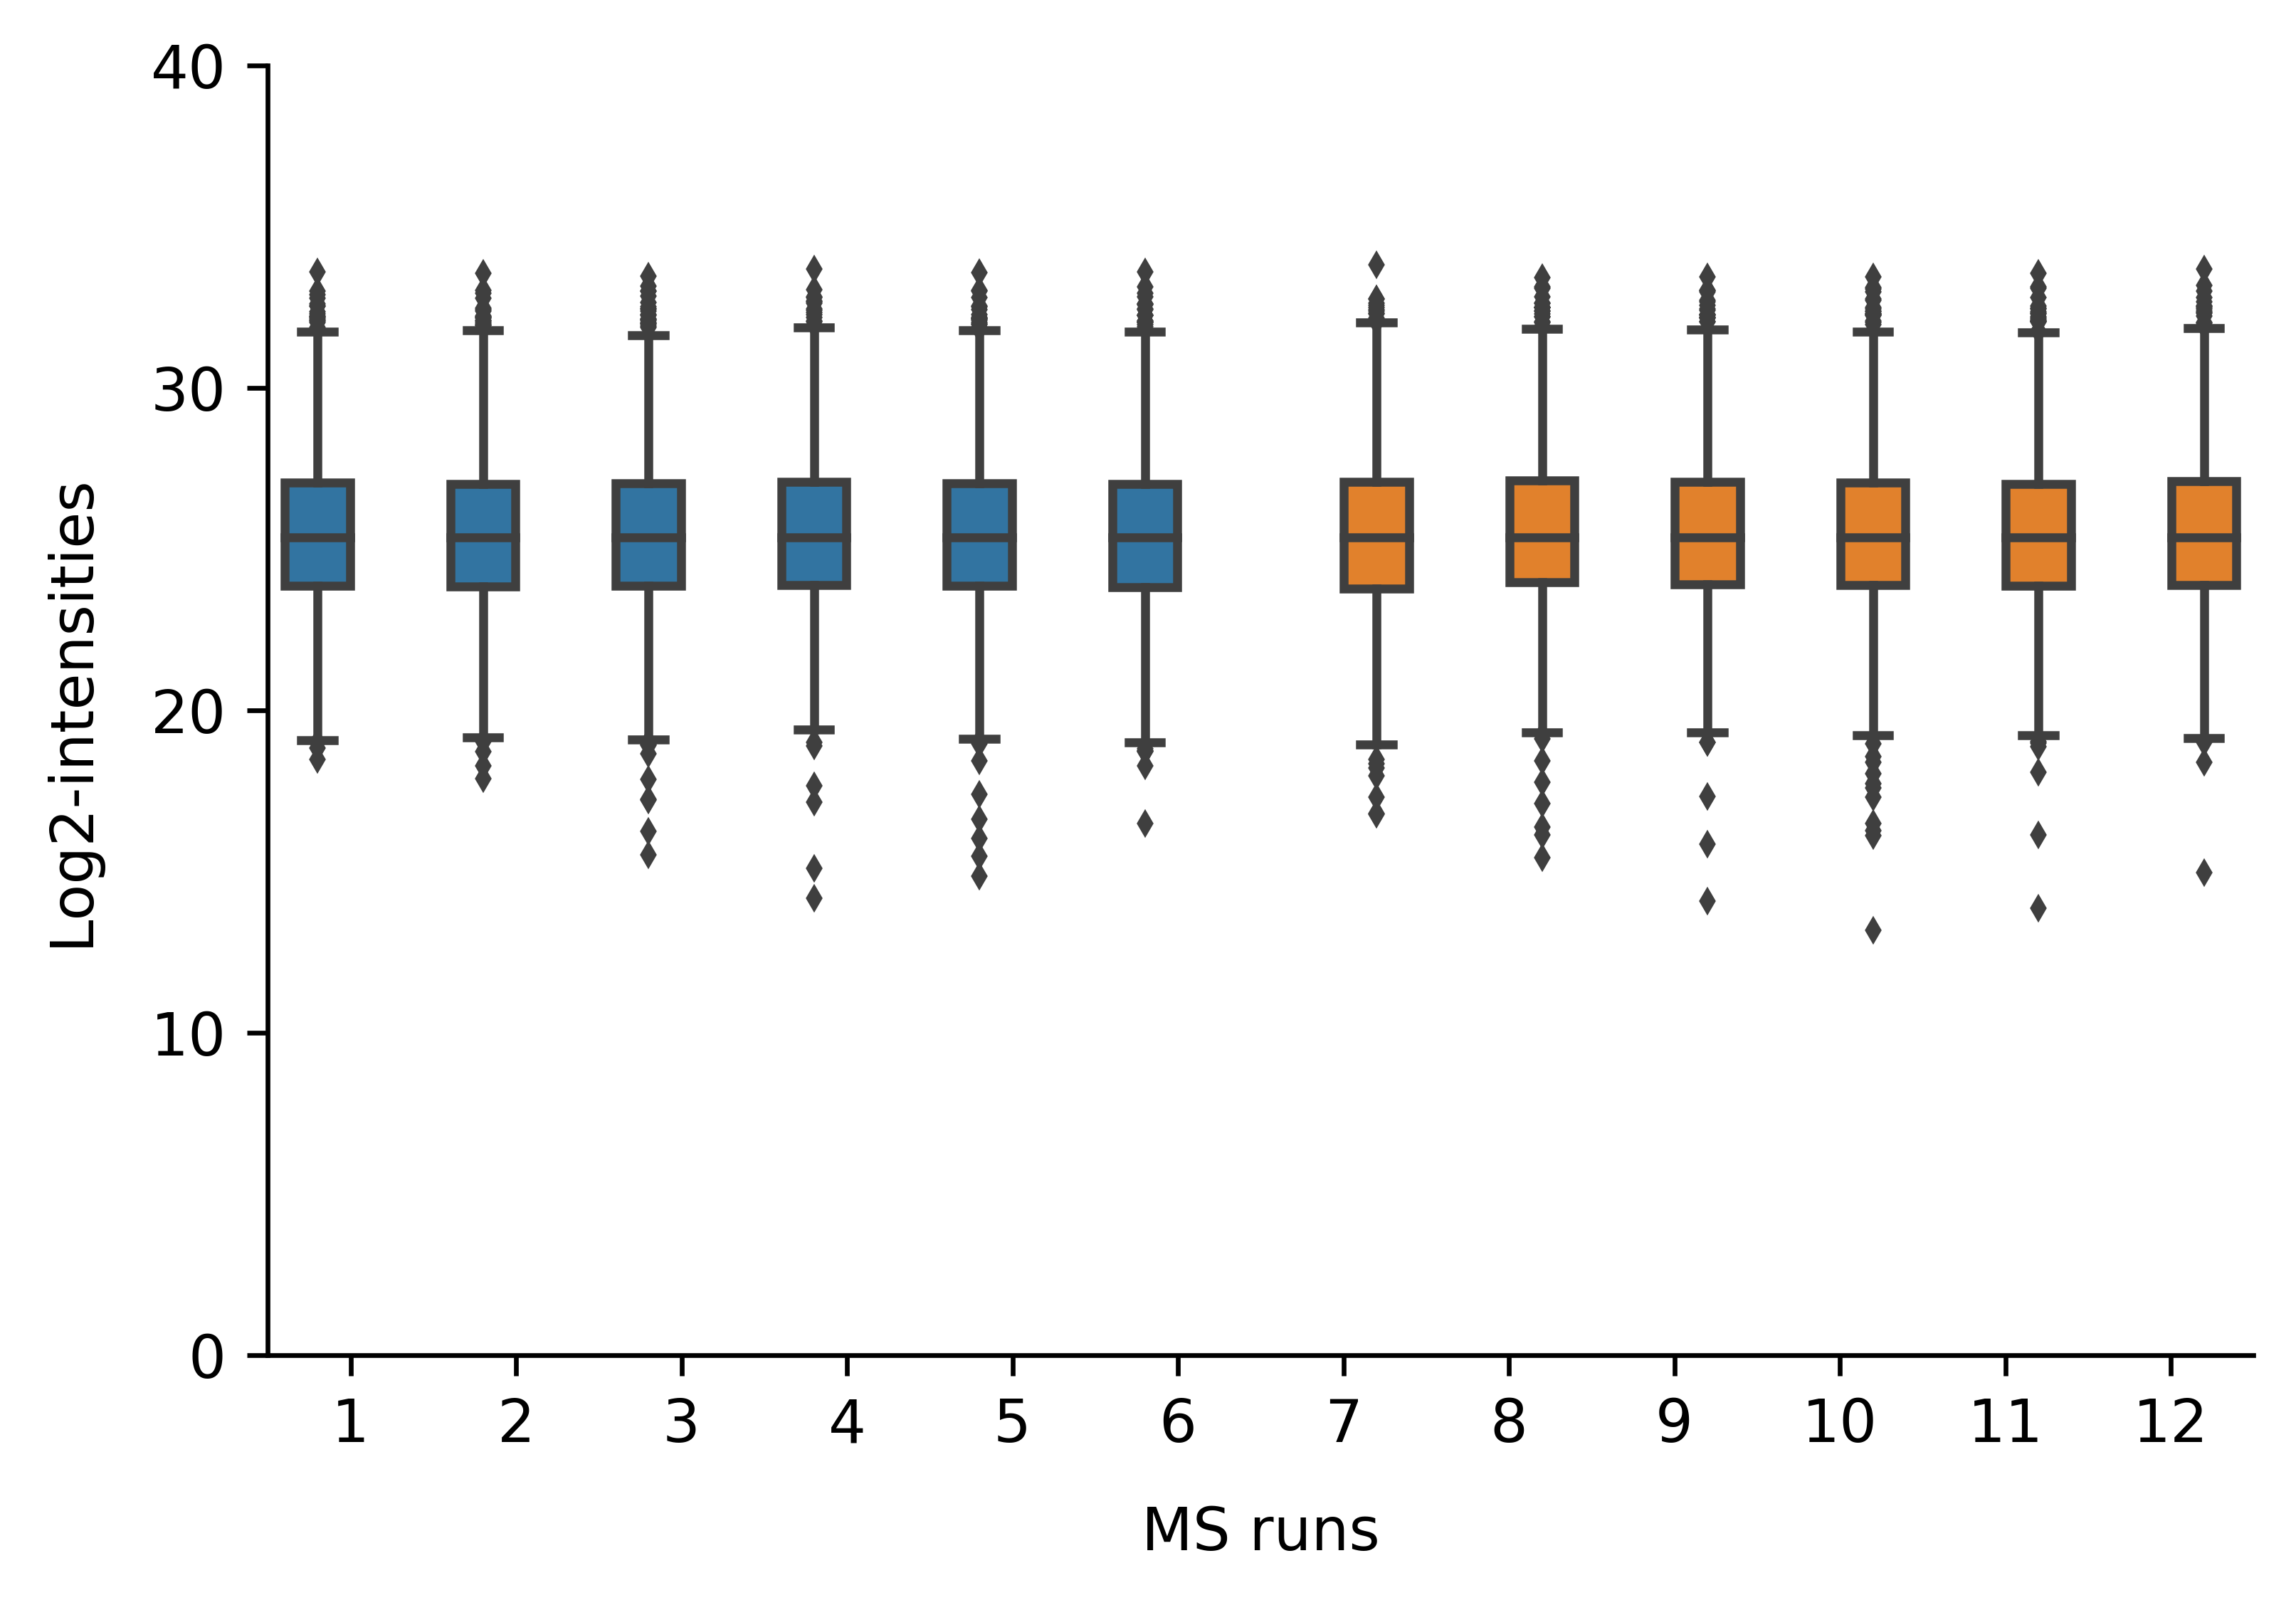

In [135]:

plt.figure(dpi=600)
ax = plt.axes()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# protein_expression['GROUP'] = protein_expression['GROUP'].astype(cat_size_order)

sns.boxplot(x="SUBJECT", y="LogIntensities",data=prodatmed_long, fliersize=2, hue="Condition")
plt.xlabel("MS runs",labelpad=8.5)
plt.ylabel("Log2-intensities",labelpad=8.5)
plt.ylim(0,40)
ax.get_legend().remove()
plt.yticks([0,10,20,30,40])

# plt.xticks([5, 11], [6, 12])

plt.show()

In [121]:
prodatquantile= pd.read_csv("./PXD020248/prodatquantile.csv", index_col=0)
prodatquantile = prodatquantile.reset_index() #将索引转化为Series
prodatquantile_long = prodatquantile.melt(id_vars=["index"])
prodatquantile_long.rename(columns={"index": "ProteinName", "variable": "MS runs", "value": "Intensity"}, inplace=True)
prodatquantile_long.dropna(how="any", inplace=True)
prodatquantile_long["LogIntensities"] = prodatquantile_long.apply(lambda x: np.log2(x["Intensity"]), axis=1)
prodatquantile_long["SUBJECT"] = prodatquantile_long.apply(lambda x: return_ms_runs(x), axis=1)

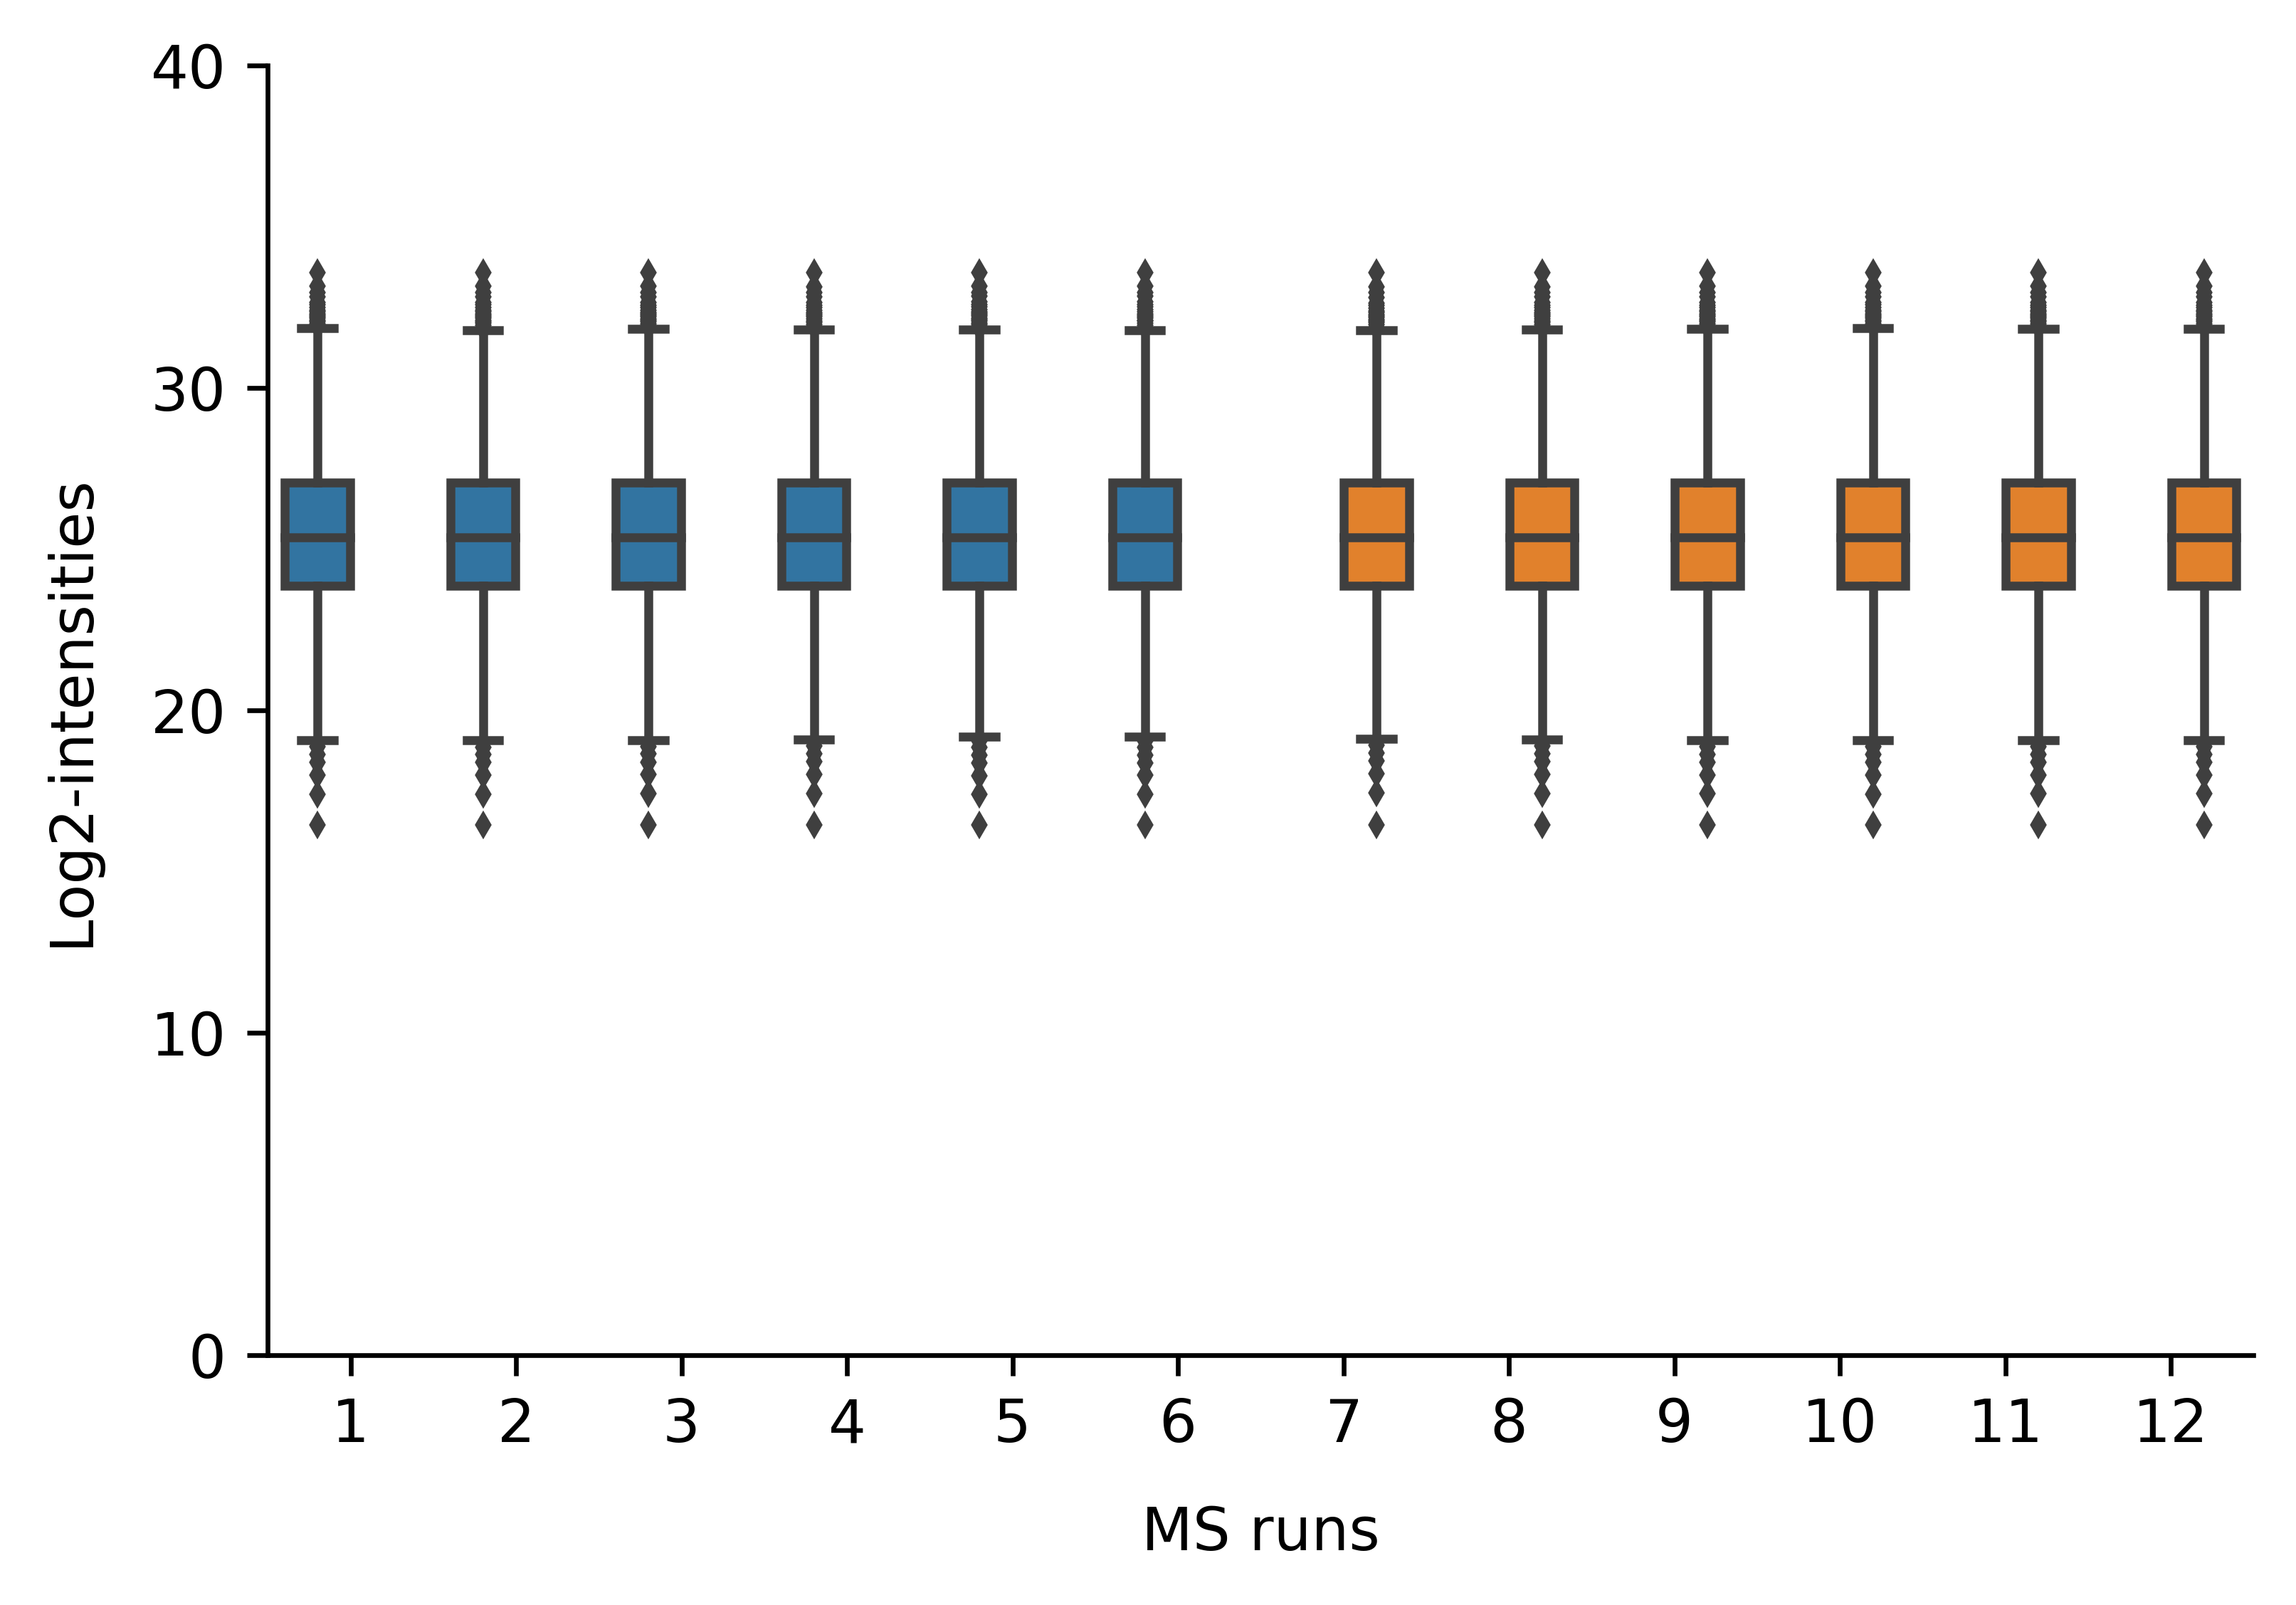

In [136]:
plt.figure(dpi=600)
ax = plt.axes()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# protein_expression['GROUP'] = protein_expression['GROUP'].astype(cat_size_order)

sns.boxplot(x="SUBJECT", y="LogIntensities",data=prodatquantile_long, fliersize=2, hue="Condition")
plt.xlabel("MS runs",labelpad=8.5)
plt.ylabel("Log2-intensities",labelpad=8.5)
plt.ylim(0,40)
ax.get_legend().remove()
plt.yticks([0,10,20,30,40])

# plt.xticks([5, 11], [6, 12])

plt.show()

In [126]:
prodat= pd.read_csv("./PXD020248/prodat.csv", index_col=0)
prodat = prodat.reset_index() #将索引转化为Series
prodat_long = prodat.melt(id_vars=["index"])
prodat_long.rename(columns={"index": "ProteinName", "variable": "MS runs", "value": "Intensity"}, inplace=True)
prodat_long.dropna(how="any", inplace=True)
prodat_long["LogIntensities"] = prodat_long.apply(lambda x: np.log2(x["Intensity"]), axis=1)
prodat_long["SUBJECT"] = prodat_long.apply(lambda x: return_ms_runs(x), axis=1)

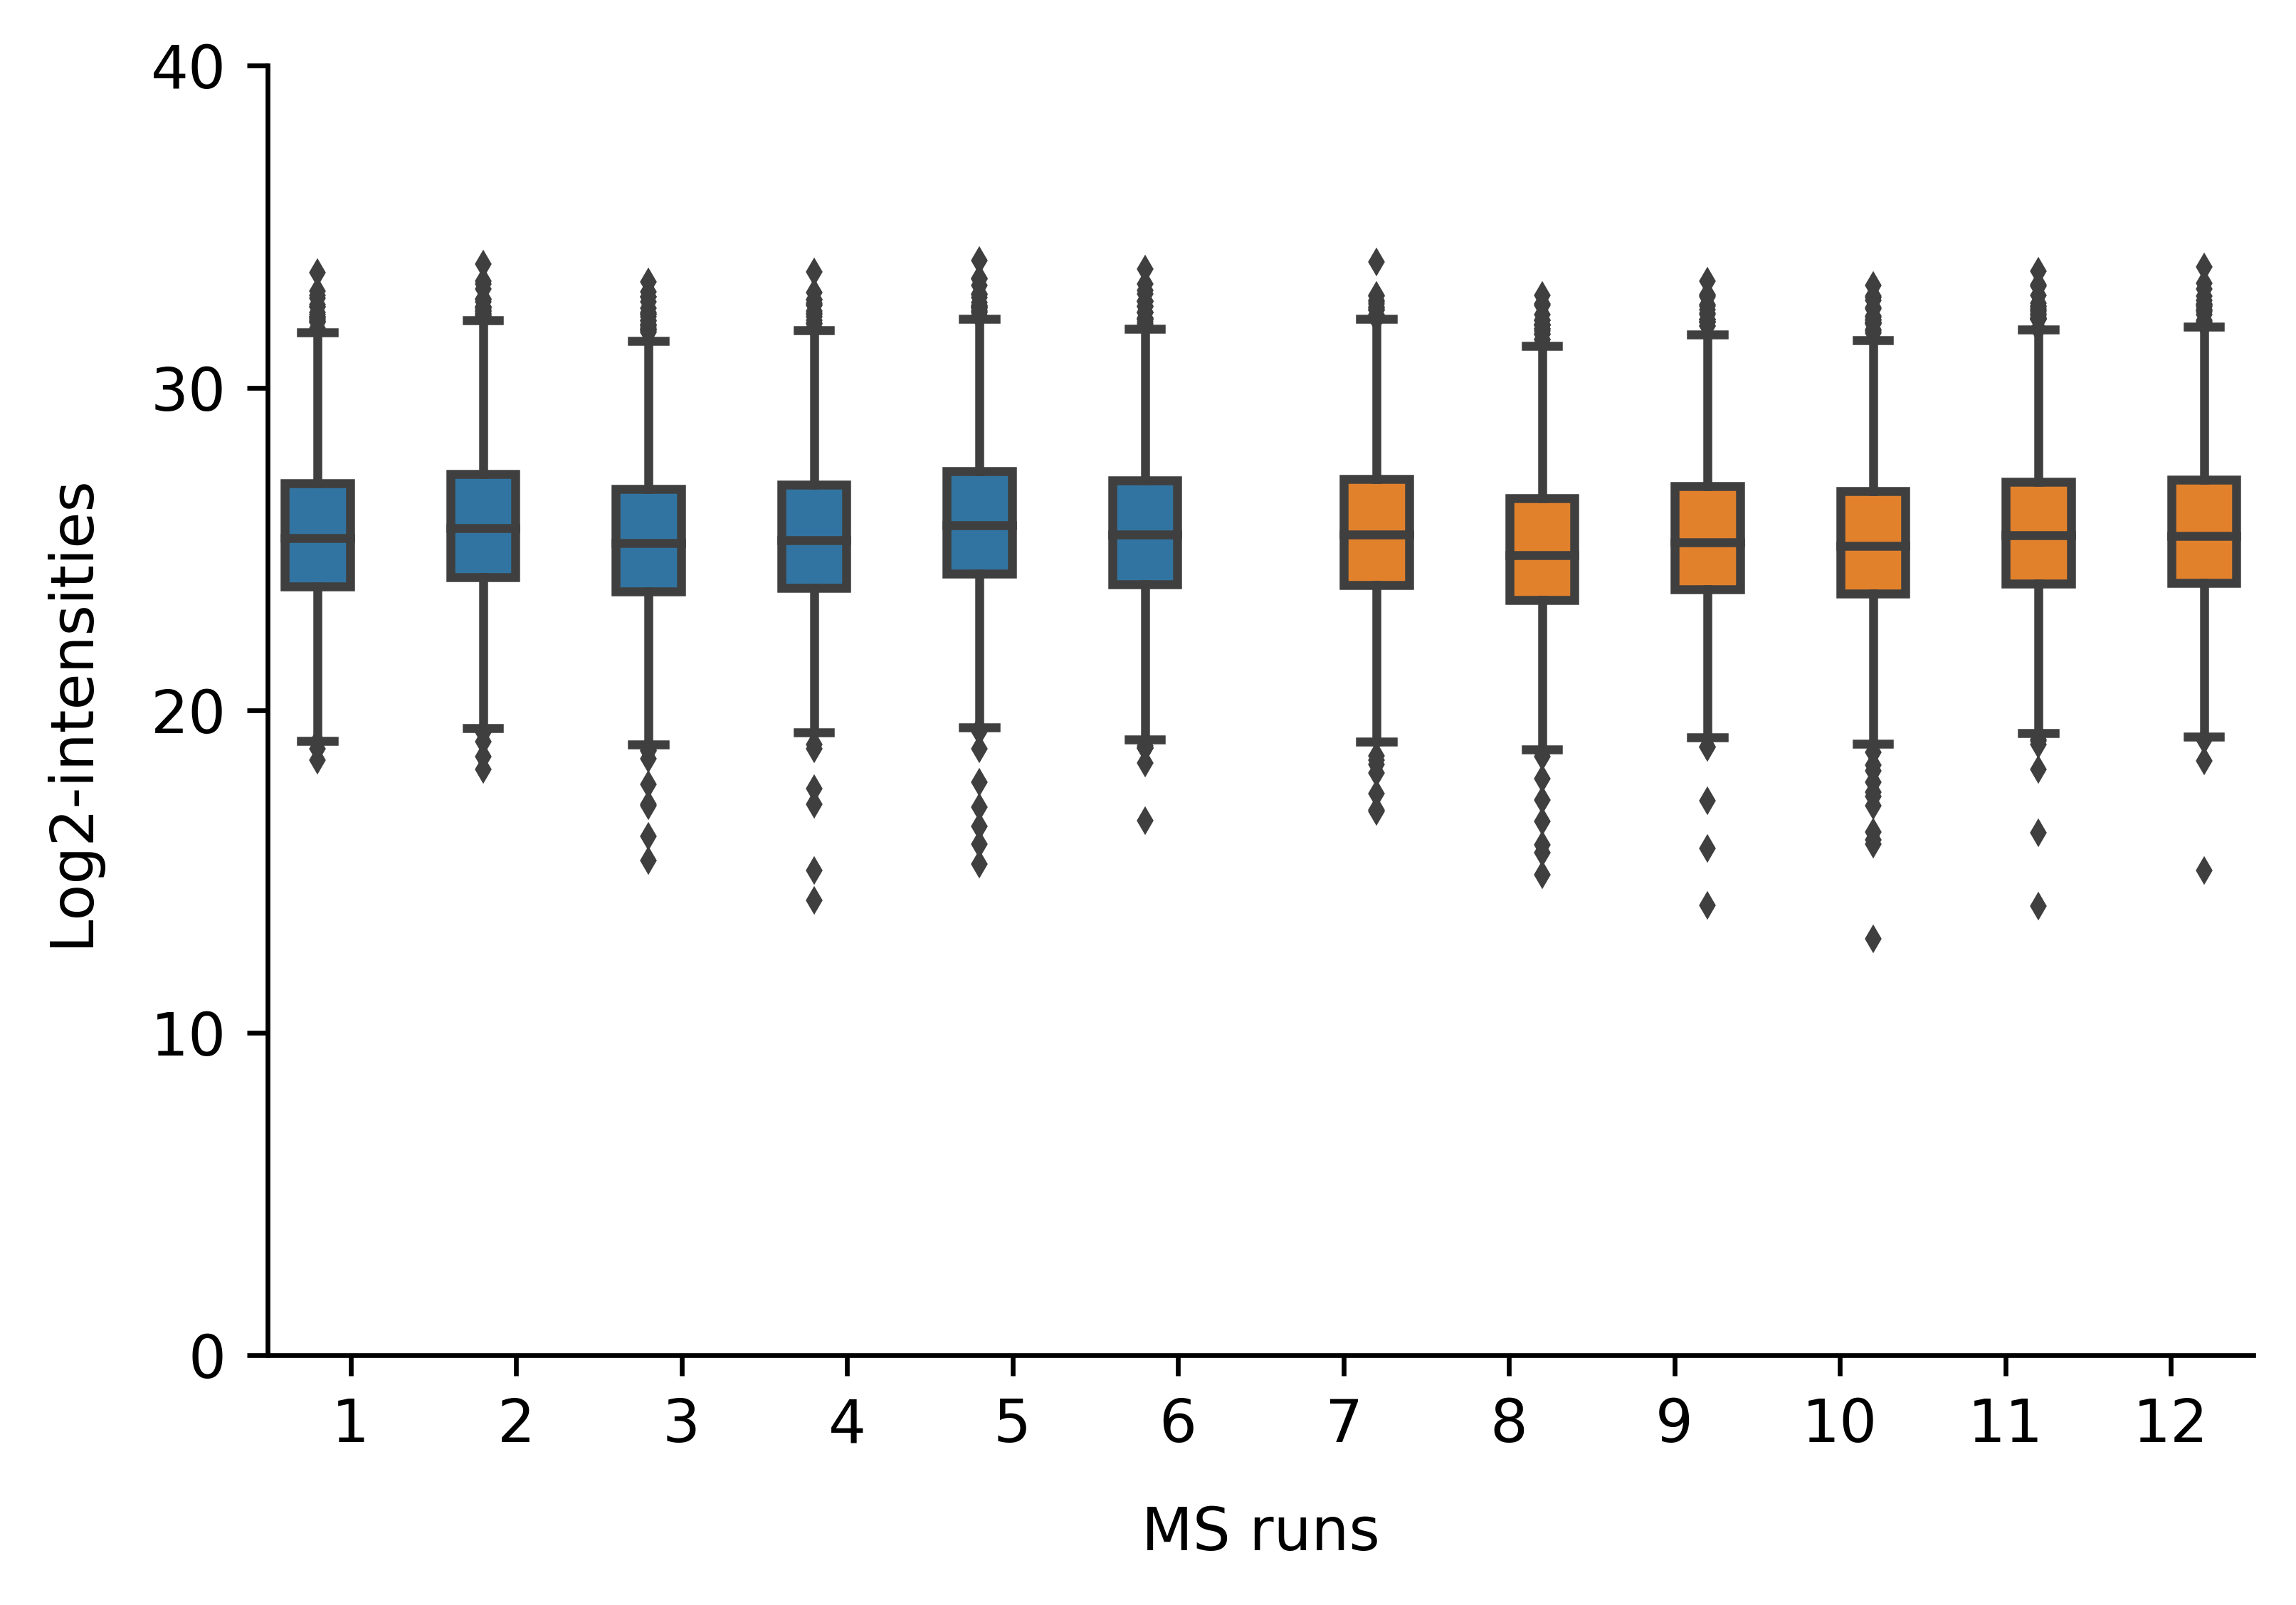

In [137]:
plt.figure(dpi=600)
ax = plt.axes()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# protein_expression['GROUP'] = protein_expression['GROUP'].astype(cat_size_order)

sns.boxplot(x="SUBJECT", y="LogIntensities",data=prodat_long, fliersize=2, hue="Condition")
plt.xlabel("MS runs",labelpad=8.5)
plt.ylabel("Log2-intensities",labelpad=8.5)
plt.ylim(0,40)
ax.get_legend().remove()
plt.yticks([0,10,20,30,40])

# plt.xticks([5, 11], [6, 12])

plt.show()

In [139]:
quantms_em_protein_expression = pd.read_csv("./PXD020248/protein_expression.csv", header=0, sep=",")

msstats_em_cv = pd.DataFrame(None,columns = ['ProteinName','BioRep1','BioRep2', 'BioRep3', 'BioRep4', 'BioRep5', 'BioRep6', 'Type', "CV[%]", "Condition"])
for condition, group_condition in quantms_em_protein_expression.groupby("GROUP"):
    for protein, t_sum in group_condition.groupby("Protein"):
        if len(t_sum) <= 3:
            continue
        BioRep1 = np.NaN
        BioRep2 = np.NaN
        BioRep3 = np.NaN
        BioRep4 = np.NaN
        BioRep5 = np.NaN
        BioRep6 = np.NaN
        for _, row in t_sum.iterrows():
            if row["SUBJECT"] == 1 or row["SUBJECT"] == 7:
                BioRep1 = np.exp2(row["LogIntensities"])
            elif row["SUBJECT"] == 2 or row["SUBJECT"] == 8:
                BioRep2 = np.exp2(row["LogIntensities"])
            elif row["SUBJECT"] == 3 or row["SUBJECT"] == 9:
                BioRep3 = np.exp2(row["LogIntensities"])
            elif row["SUBJECT"] == 4 or row["SUBJECT"] == 10:
                BioRep4 = np.exp2(row["LogIntensities"])
            elif row["SUBJECT"] == 5 or row["SUBJECT"] == 11:
                BioRep5 = np.exp2(row["LogIntensities"])
            elif row["SUBJECT"] == 6 or row["SUBJECT"] == 12:
                BioRep6 = np.exp2(row["LogIntensities"])

        mean = np.nanmean([BioRep1, BioRep2, BioRep3, BioRep4, BioRep5, BioRep6])
        std = np.nanstd([BioRep1, BioRep2, BioRep3, BioRep4, BioRep5, BioRep6])
        msstats_em_cv = msstats_em_cv.append({'ProteinName': protein,'BioRep1':BioRep1, 
                       'BioRep2': BioRep2, 'BioRep3': BioRep3, "BioRep4": BioRep4, "BioRep5": BioRep5, "BioRep6": BioRep6,
                                        "CV[%]": 100 * (std / mean), "Type": "MSstats", "Condition": condition}, ignore_index=True)

In [140]:
prodatmed_long["Condition"] = prodatmed_long.apply(lambda x: "BaP" if x["MS runs"].split("_")[0] == "BaP" else "Control", axis=1)

for condition, group_condition in prodatmed_long.groupby("Condition"):
    for protein, t_sum in group_condition.groupby("ProteinName"):
        if len(t_sum) <= 3:
            continue
        BioRep1 = np.NaN
        BioRep2 = np.NaN
        BioRep3 = np.NaN
        BioRep4 = np.NaN
        BioRep5 = np.NaN
        BioRep6 = np.NaN
        for _, row in t_sum.iterrows():
            if str(row["SUBJECT"]) == "1" or str(row["SUBJECT"]) == "7":
                BioRep1 = row["Intensity"]
            elif str(row["SUBJECT"]) == "2" or str(row["SUBJECT"]) == "8":
                BioRep2 = row["Intensity"]
            elif str(row["SUBJECT"]) == "3" or str(row["SUBJECT"]) == "9":
                BioRep3 = row["Intensity"]
            elif str(row["SUBJECT"]) == "4" or str(row["SUBJECT"]) == "10":
                BioRep4 = row["Intensity"]
            elif str(row["SUBJECT"]) == "5" or str(row["SUBJECT"]) == "11":
                BioRep5 = row["Intensity"]
            elif str(row["SUBJECT"]) == "6" or str(row["SUBJECT"]) == "12":
                BioRep6 = row["Intensity"]

        mean = np.nanmean([BioRep1, BioRep2, BioRep3, BioRep4, BioRep5, BioRep6])
        std = np.nanstd([BioRep1, BioRep2, BioRep3, BioRep4, BioRep5, BioRep6])
        msstats_em_cv = msstats_em_cv.append({'ProteinName': protein,'BioRep1':BioRep1, 
                       'BioRep2': BioRep2, 'BioRep3': BioRep3, "BioRep4": BioRep4, "BioRep5": BioRep5, "BioRep6": BioRep6,
                                        "CV[%]": 100 * (std / mean), "Type": "Proteus", "Condition": condition}, ignore_index=True)
        

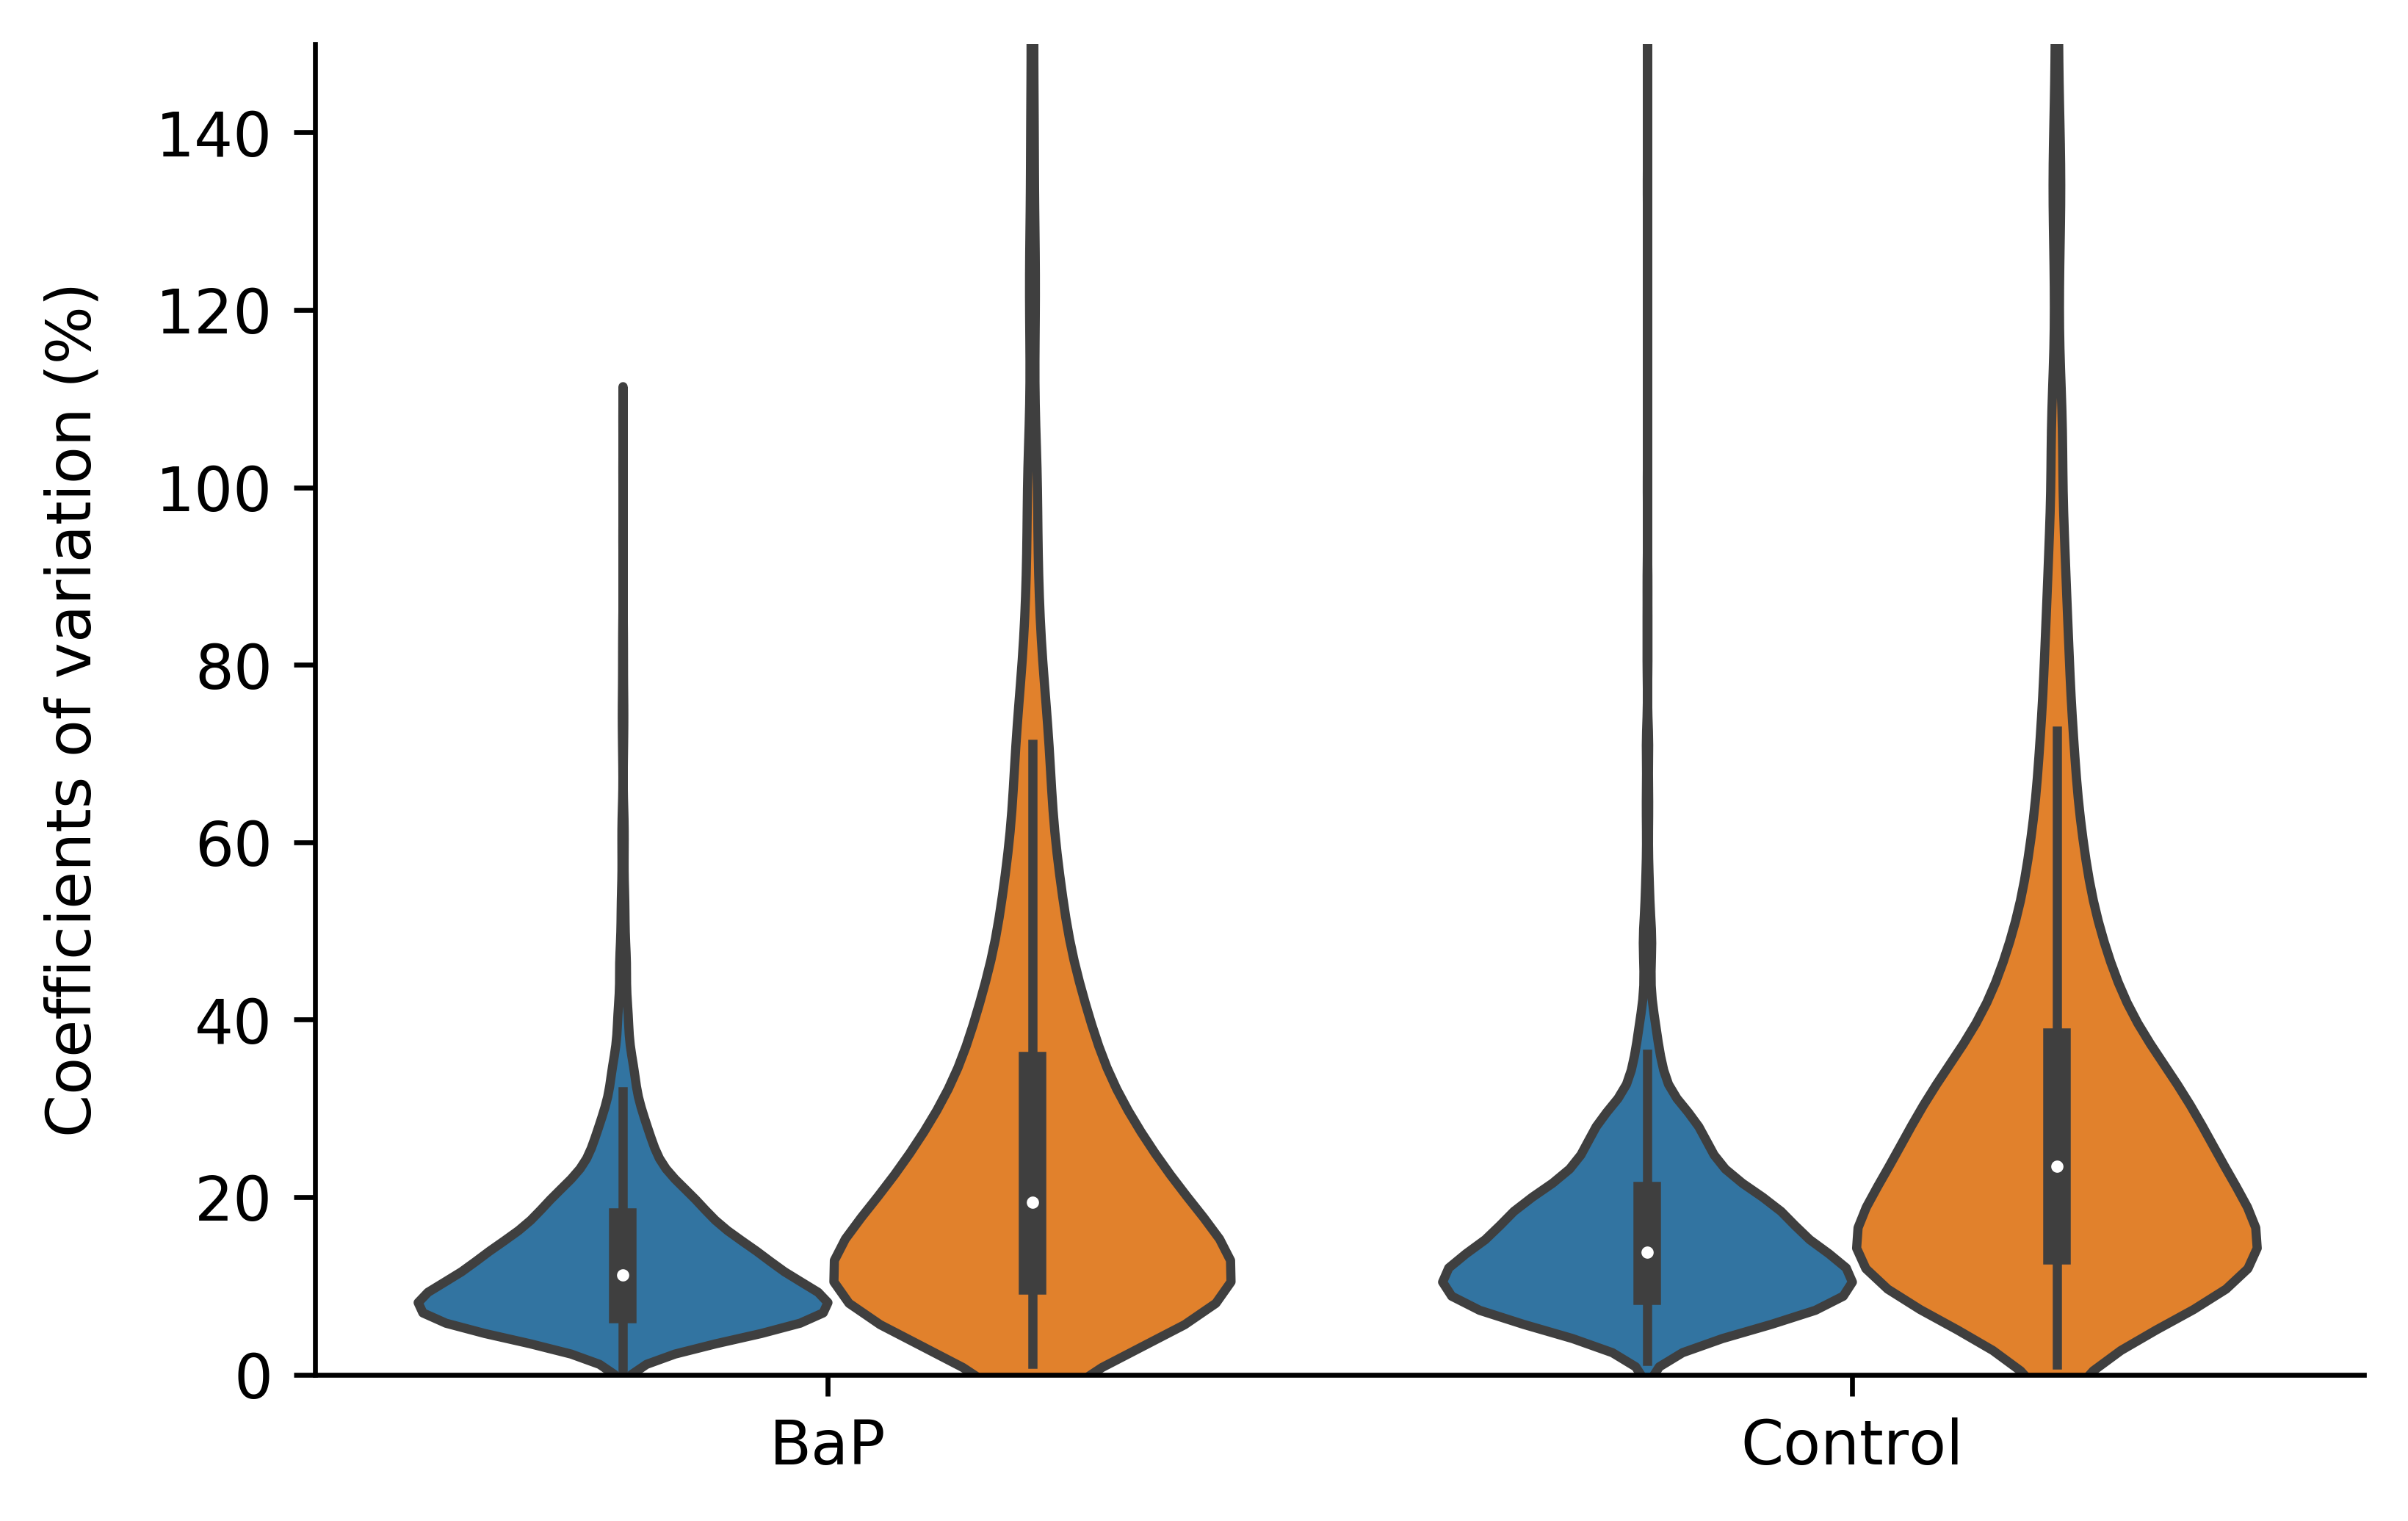

In [141]:
plt.figure(dpi=600)
ax = plt.axes()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ylim(0, 150)
# plt.title("Coefficients of variation (%)")
sns.violinplot(x = "Condition", y="CV[%]", data=msstats_em_cv, scale= "count", hue="Type")
ax.get_legend().remove()
plt.ylabel("Coefficients of variation (%)", labelpad=8.5)
plt.xlabel("", labelpad=8.5)
plt.show()

In [152]:
msstats_em_cv.groupby("Type")["CV[%]"].mean()

Type
MSstats    14.879226
Proteus    29.189939
Name: CV[%], dtype: float64

In [142]:
quantile_protein_expression = pd.read_csv("./PXD020248/quantile_protein_expression.csv", header=0, sep=",")

msstats_quantile_cv = pd.DataFrame(None,columns = ['ProteinName','BioRep1','BioRep2', 'BioRep3', 'BioRep4', 'BioRep5', 'BioRep6', 'Type', "CV[%]", "Condition"])
for condition, group_condition in quantile_protein_expression.groupby("GROUP"):
    for protein, t_sum in group_condition.groupby("Protein"):
        if len(t_sum) <= 3:
            continue
        BioRep1 = np.NaN
        BioRep2 = np.NaN
        BioRep3 = np.NaN
        BioRep4 = np.NaN
        BioRep5 = np.NaN
        BioRep6 = np.NaN
        for _, row in t_sum.iterrows():
            if row["SUBJECT"] == 1 or row["SUBJECT"] == 7:
                BioRep1 = np.exp2(row["LogIntensities"])
            elif row["SUBJECT"] == 2 or row["SUBJECT"] == 8:
                BioRep2 = np.exp2(row["LogIntensities"])
            elif row["SUBJECT"] == 3 or row["SUBJECT"] == 9:
                BioRep3 = np.exp2(row["LogIntensities"])
            elif row["SUBJECT"] == 4 or row["SUBJECT"] == 10:
                BioRep4 = np.exp2(row["LogIntensities"])
            elif row["SUBJECT"] == 5 or row["SUBJECT"] == 11:
                BioRep5 = np.exp2(row["LogIntensities"])
            elif row["SUBJECT"] == 6 or row["SUBJECT"] == 12:
                BioRep6 = np.exp2(row["LogIntensities"])

        mean = np.nanmean([BioRep1, BioRep2, BioRep3, BioRep4, BioRep5, BioRep6])
        std = np.nanstd([BioRep1, BioRep2, BioRep3, BioRep4, BioRep5, BioRep6])
        msstats_quantile_cv = msstats_quantile_cv.append({'ProteinName': protein,'BioRep1':BioRep1, 
                       'BioRep2': BioRep2, 'BioRep3': BioRep3, "BioRep4": BioRep4, "BioRep5": BioRep5, "BioRep6": BioRep6,
                                        "CV[%]": 100 * (std / mean), "Type": "MSstats", "Condition": condition}, ignore_index=True)

In [143]:
prodatquantile_long["Condition"] = prodatquantile_long.apply(lambda x: "BaP" if x["MS runs"].split("_")[0] == "BaP" else "Control", axis=1)

for condition, group_condition in prodatquantile_long.groupby("Condition"):
    for protein, t_sum in group_condition.groupby("ProteinName"):
        if len(t_sum) <= 3:
            continue
        BioRep1 = np.NaN
        BioRep2 = np.NaN
        BioRep3 = np.NaN
        BioRep4 = np.NaN
        BioRep5 = np.NaN
        BioRep6 = np.NaN
        for _, row in t_sum.iterrows():
            if str(row["SUBJECT"]) == "1" or str(row["SUBJECT"]) == "7":
                BioRep1 = row["Intensity"]
            elif str(row["SUBJECT"]) == "2" or str(row["SUBJECT"]) == "8":
                BioRep2 = row["Intensity"]
            elif str(row["SUBJECT"]) == "3" or str(row["SUBJECT"]) == "9":
                BioRep3 = row["Intensity"]
            elif str(row["SUBJECT"]) == "4" or str(row["SUBJECT"]) == "10":
                BioRep4 = row["Intensity"]
            elif str(row["SUBJECT"]) == "5" or str(row["SUBJECT"]) == "11":
                BioRep5 = row["Intensity"]
            elif str(row["SUBJECT"]) == "6" or str(row["SUBJECT"]) == "12":
                BioRep6 = row["Intensity"]

        mean = np.nanmean([BioRep1, BioRep2, BioRep3, BioRep4, BioRep5, BioRep6])
        std = np.nanstd([BioRep1, BioRep2, BioRep3, BioRep4, BioRep5, BioRep6])
        msstats_quantile_cv = msstats_quantile_cv.append({'ProteinName': protein,'BioRep1':BioRep1, 
                       'BioRep2': BioRep2, 'BioRep3': BioRep3, "BioRep4": BioRep4, "BioRep5": BioRep5, "BioRep6": BioRep6,
                                        "CV[%]": 100 * (std / mean), "Type": "Proteus", "Condition": condition}, ignore_index=True)

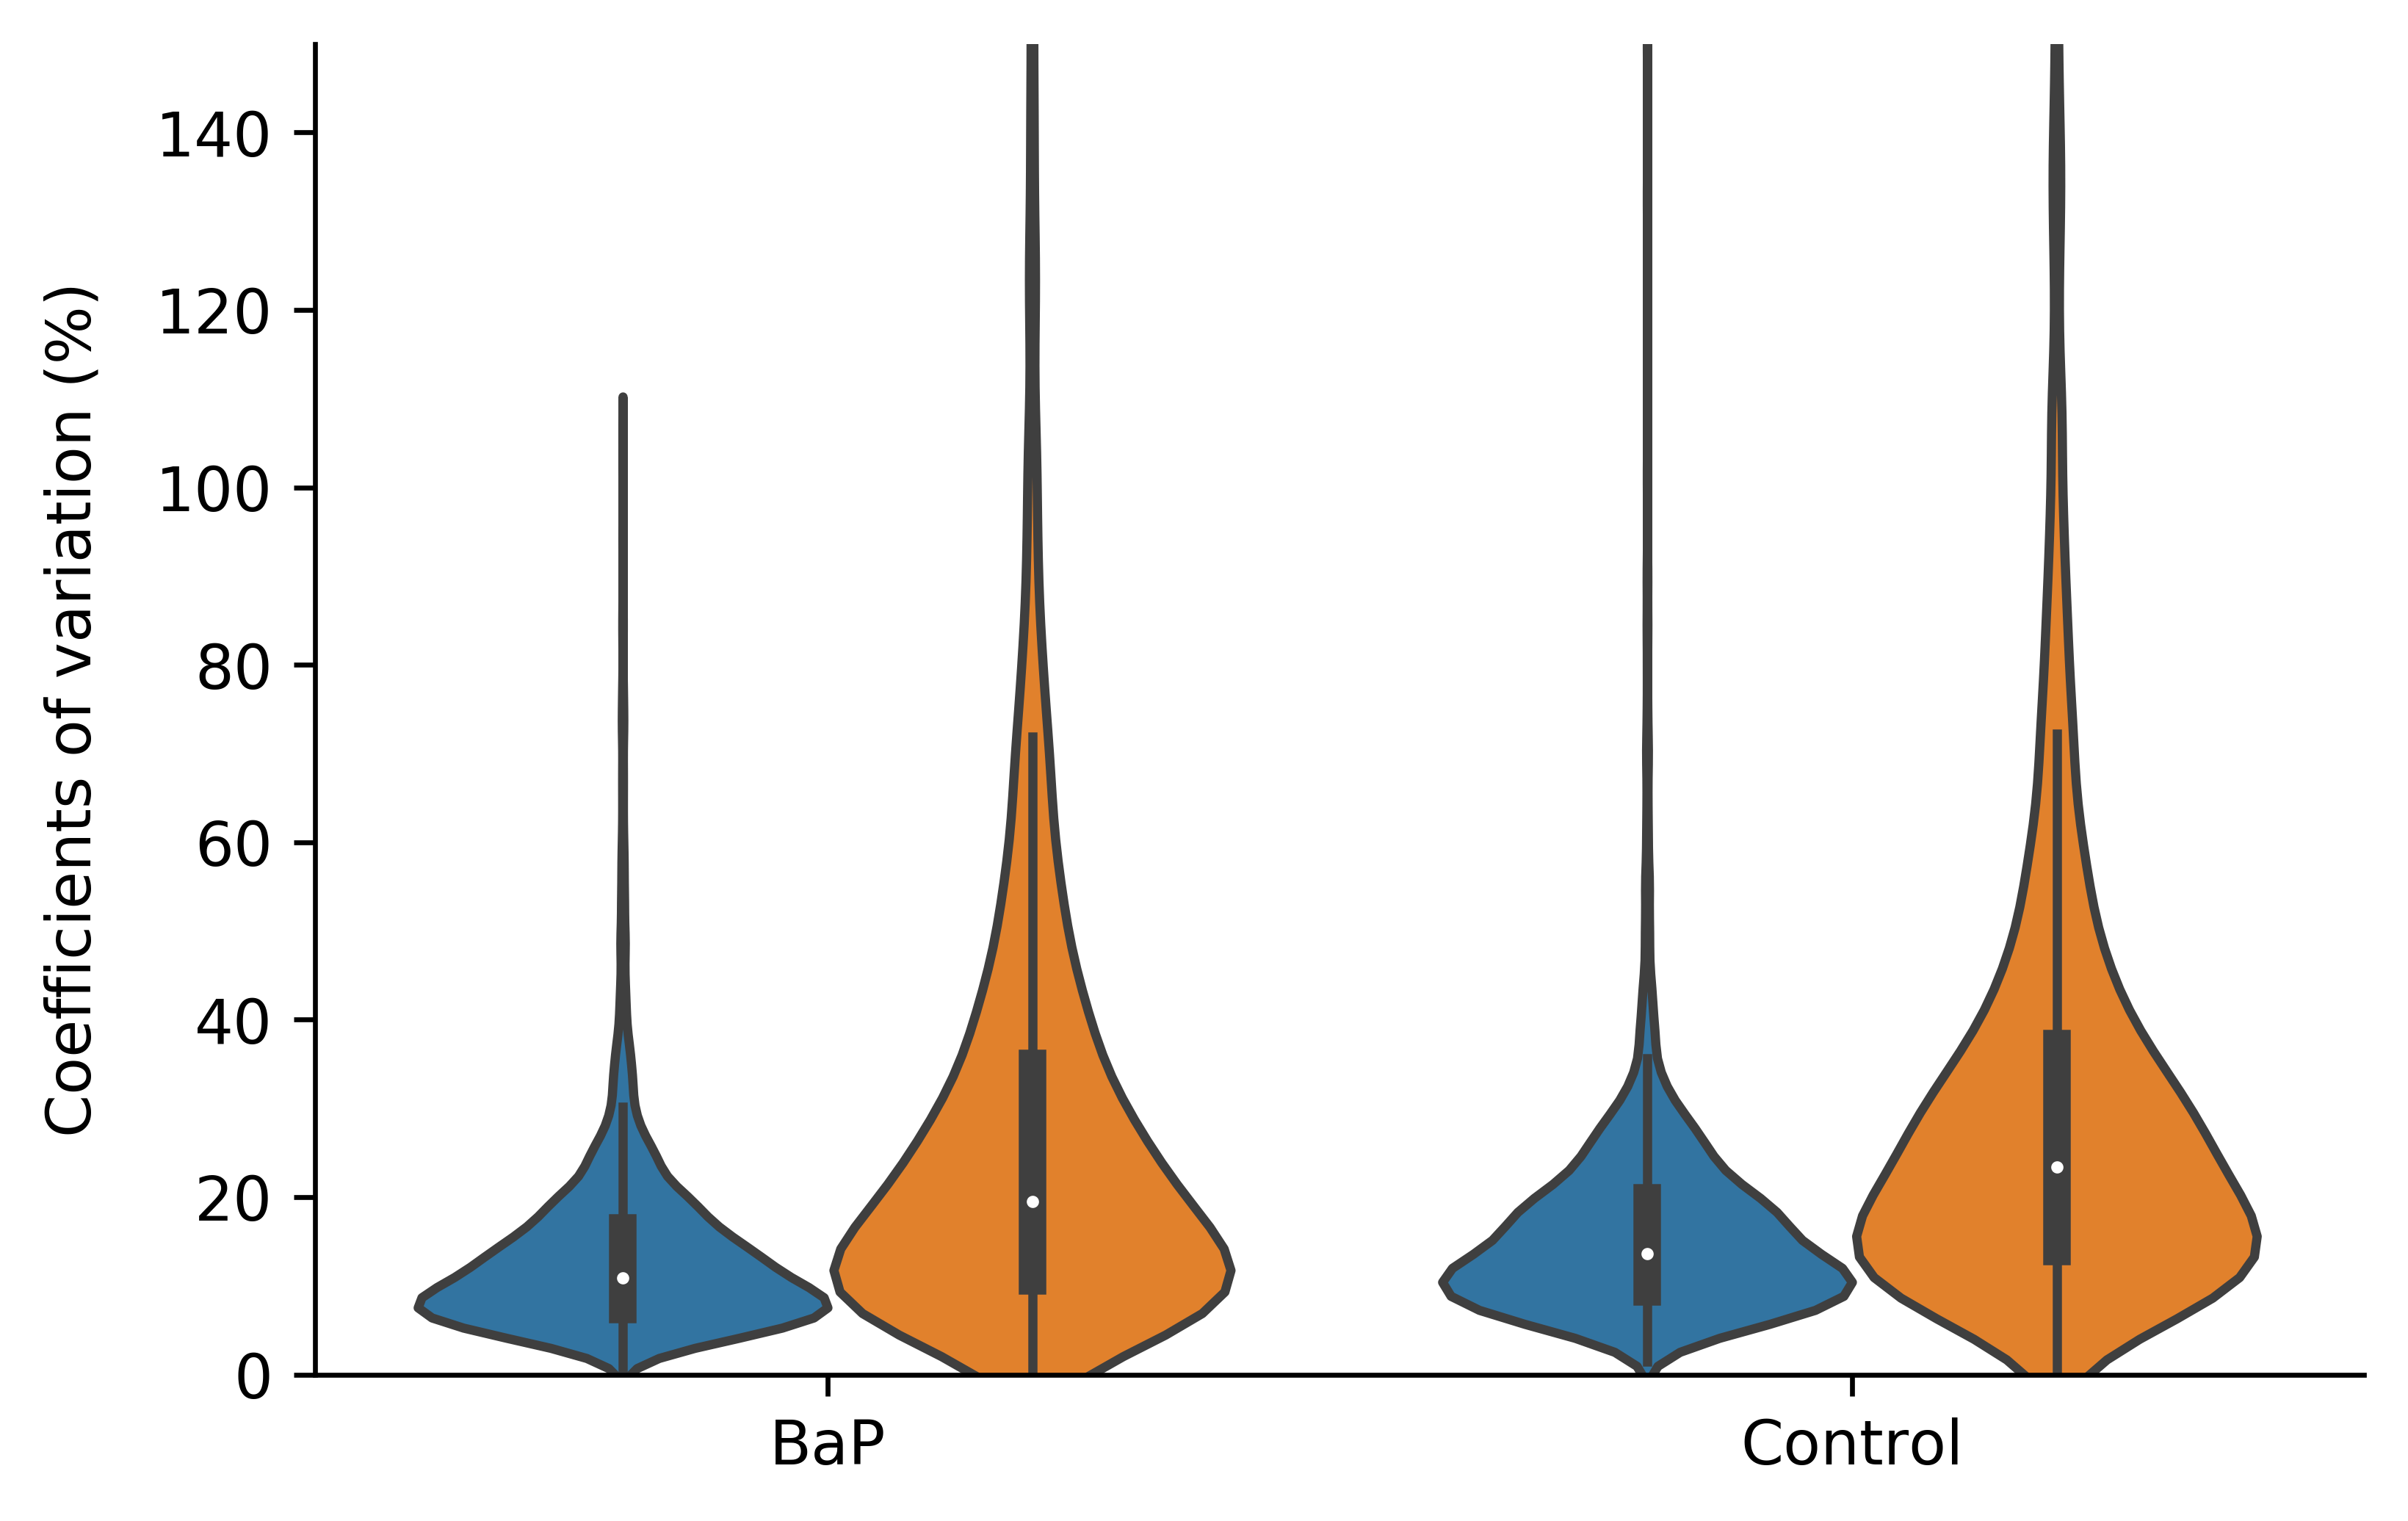

In [144]:
plt.figure(dpi=600)
ax = plt.axes()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ylim(0, 150)
# plt.title("Coefficients of variation (%)")
sns.violinplot(x = "Condition", y="CV[%]", data=msstats_quantile_cv, scale= "count", hue="Type")
ax.get_legend().remove()
plt.ylabel("Coefficients of variation (%)", labelpad=8.5)
plt.xlabel("", labelpad=8.5)
plt.show()

In [151]:
msstats_quantile_cv.groupby("Type")["CV[%]"].mean()

Type
MSstats    14.458684
Proteus    29.160105
Name: CV[%], dtype: float64

In [145]:
no_normalization_protein_expression = pd.read_csv("./PXD020248/no_normalization_protein_expression.csv", header=0, sep=",")

msstats_no_normalization_cv = pd.DataFrame(None,columns = ['ProteinName','BioRep1','BioRep2', 'BioRep3', 'BioRep4', 'BioRep5', 'BioRep6', 'Type', "CV[%]", "Condition"])
for condition, group_condition in no_normalization_protein_expression.groupby("GROUP"):
    for protein, t_sum in group_condition.groupby("Protein"):
        if len(t_sum) <= 3:
            continue
        BioRep1 = np.NaN
        BioRep2 = np.NaN
        BioRep3 = np.NaN
        BioRep4 = np.NaN
        BioRep5 = np.NaN
        BioRep6 = np.NaN
        for _, row in t_sum.iterrows():
            if row["SUBJECT"] == 1 or row["SUBJECT"] == 7:
                BioRep1 = np.exp2(row["LogIntensities"])
            elif row["SUBJECT"] == 2 or row["SUBJECT"] == 8:
                BioRep2 = np.exp2(row["LogIntensities"])
            elif row["SUBJECT"] == 3 or row["SUBJECT"] == 9:
                BioRep3 = np.exp2(row["LogIntensities"])
            elif row["SUBJECT"] == 4 or row["SUBJECT"] == 10:
                BioRep4 = np.exp2(row["LogIntensities"])
            elif row["SUBJECT"] == 5 or row["SUBJECT"] == 11:
                BioRep5 = np.exp2(row["LogIntensities"])
            elif row["SUBJECT"] == 6 or row["SUBJECT"] == 12:
                BioRep6 = np.exp2(row["LogIntensities"])

        mean = np.nanmean([BioRep1, BioRep2, BioRep3, BioRep4, BioRep5, BioRep6])
        std = np.nanstd([BioRep1, BioRep2, BioRep3, BioRep4, BioRep5, BioRep6])
        msstats_no_normalization_cv = msstats_no_normalization_cv.append({'ProteinName': protein,'BioRep1':BioRep1, 
                       'BioRep2': BioRep2, 'BioRep3': BioRep3, "BioRep4": BioRep4, "BioRep5": BioRep5, "BioRep6": BioRep6,
                                        "CV[%]": 100 * (std / mean), "Type": "MSstats", "Condition": condition}, ignore_index=True)

In [146]:
prodat_long["Condition"] = prodat_long.apply(lambda x: "BaP" if x["MS runs"].split("_")[0] == "BaP" else "Control", axis=1)

for condition, group_condition in prodat_long.groupby("Condition"):
    for protein, t_sum in group_condition.groupby("ProteinName"):
        if len(t_sum) <= 3:
            continue
        BioRep1 = np.NaN
        BioRep2 = np.NaN
        BioRep3 = np.NaN
        BioRep4 = np.NaN
        BioRep5 = np.NaN
        BioRep6 = np.NaN
        for _, row in t_sum.iterrows():
            if str(row["SUBJECT"]) == "1" or str(row["SUBJECT"]) == "7":
                BioRep1 = row["Intensity"]
            elif str(row["SUBJECT"]) == "2" or str(row["SUBJECT"]) == "8":
                BioRep2 = row["Intensity"]
            elif str(row["SUBJECT"]) == "3" or str(row["SUBJECT"]) == "9":
                BioRep3 = row["Intensity"]
            elif str(row["SUBJECT"]) == "4" or str(row["SUBJECT"]) == "10":
                BioRep4 = row["Intensity"]
            elif str(row["SUBJECT"]) == "5" or str(row["SUBJECT"]) == "11":
                BioRep5 = row["Intensity"]
            elif str(row["SUBJECT"]) == "6" or str(row["SUBJECT"]) == "12":
                BioRep6 = row["Intensity"]

        mean = np.nanmean([BioRep1, BioRep2, BioRep3, BioRep4, BioRep5, BioRep6])
        std = np.nanstd([BioRep1, BioRep2, BioRep3, BioRep4, BioRep5, BioRep6])
        msstats_no_normalization_cv = msstats_no_normalization_cv.append({'ProteinName': protein,'BioRep1':BioRep1, 
                       'BioRep2': BioRep2, 'BioRep3': BioRep3, "BioRep4": BioRep4, "BioRep5": BioRep5, "BioRep6": BioRep6,
                                        "CV[%]": 100 * (std / mean), "Type": "Proteus", "Condition": condition}, ignore_index=True)

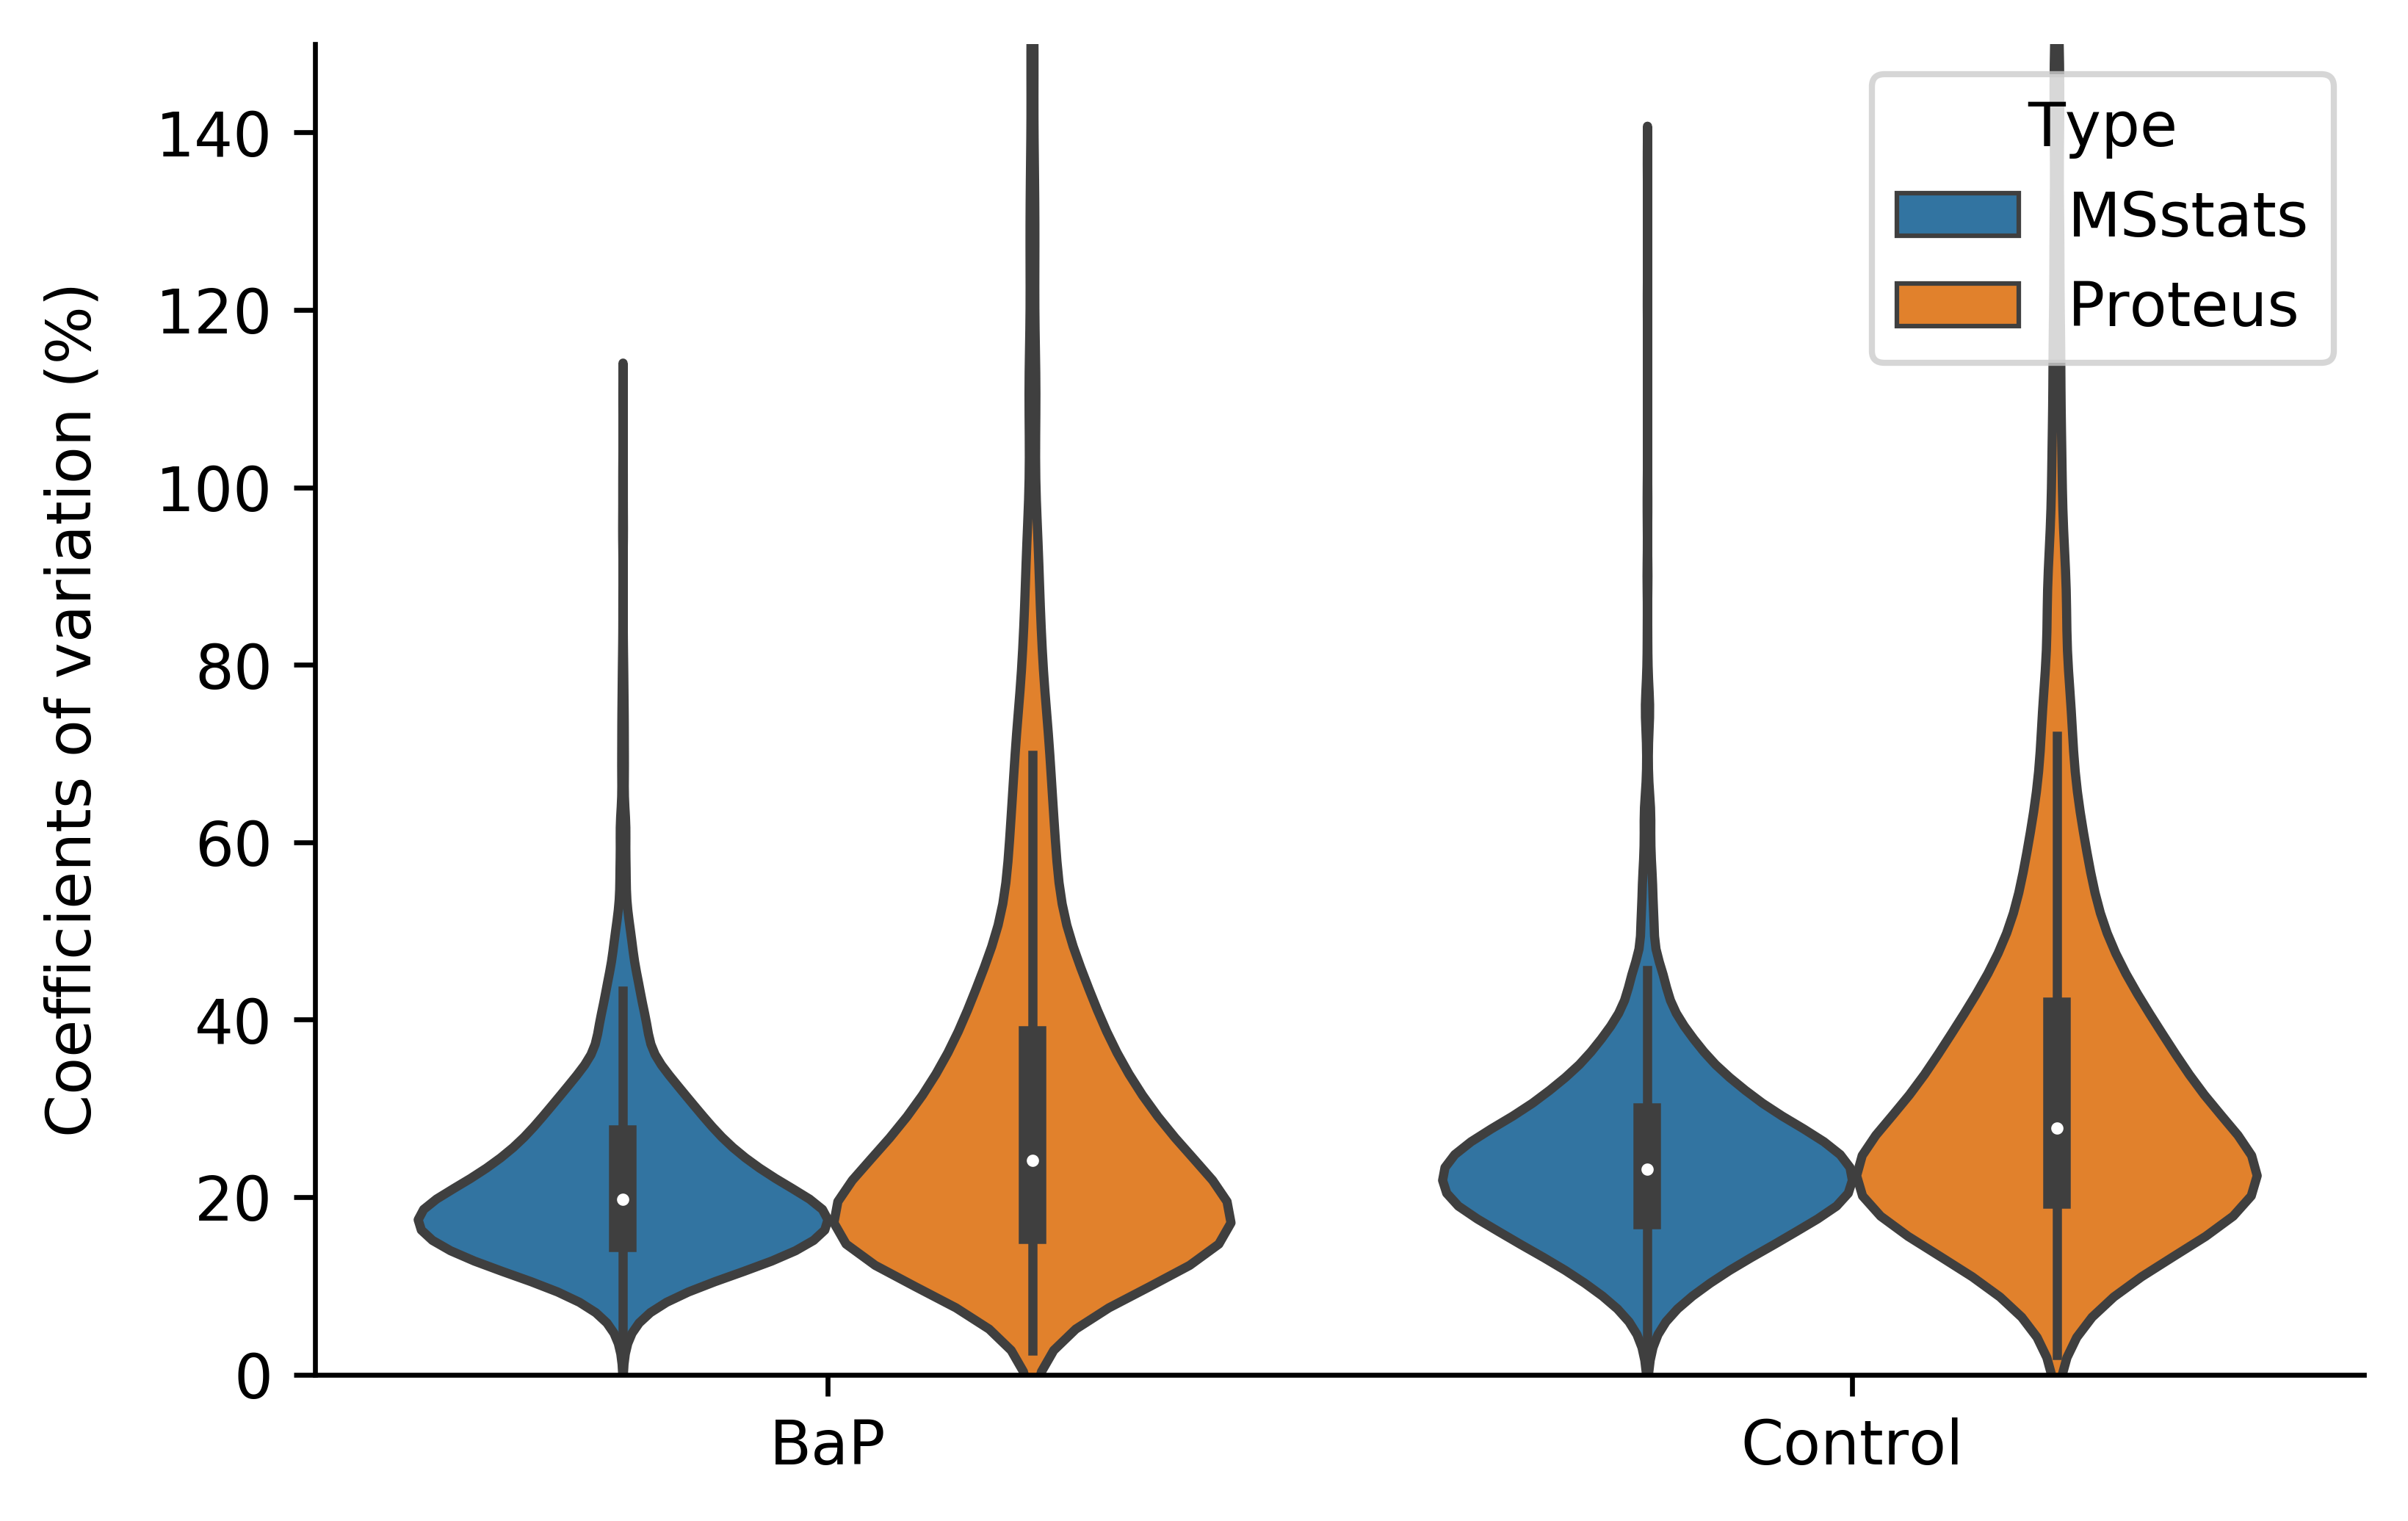

In [148]:
plt.figure(dpi=600)
ax = plt.axes()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ylim(0, 150)
# plt.title("Coefficients of variation (%)")
sns.violinplot(x = "Condition", y="CV[%]", data=msstats_no_normalization_cv, scale= "count", hue="Type")

plt.ylabel("Coefficients of variation (%)", labelpad=8.5)
plt.xlabel("", labelpad=8.5)
plt.show()

In [149]:
msstats_no_normalization_cv.groupby("Type")["CV[%]"].mean()

Type
MSstats    23.236858
Proteus    33.424236
Name: CV[%], dtype: float64

C:\Users\ChengXin\MyProgram\python\anaconda\pro\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\ChengXin\MyProgram\python\anaconda\pro\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


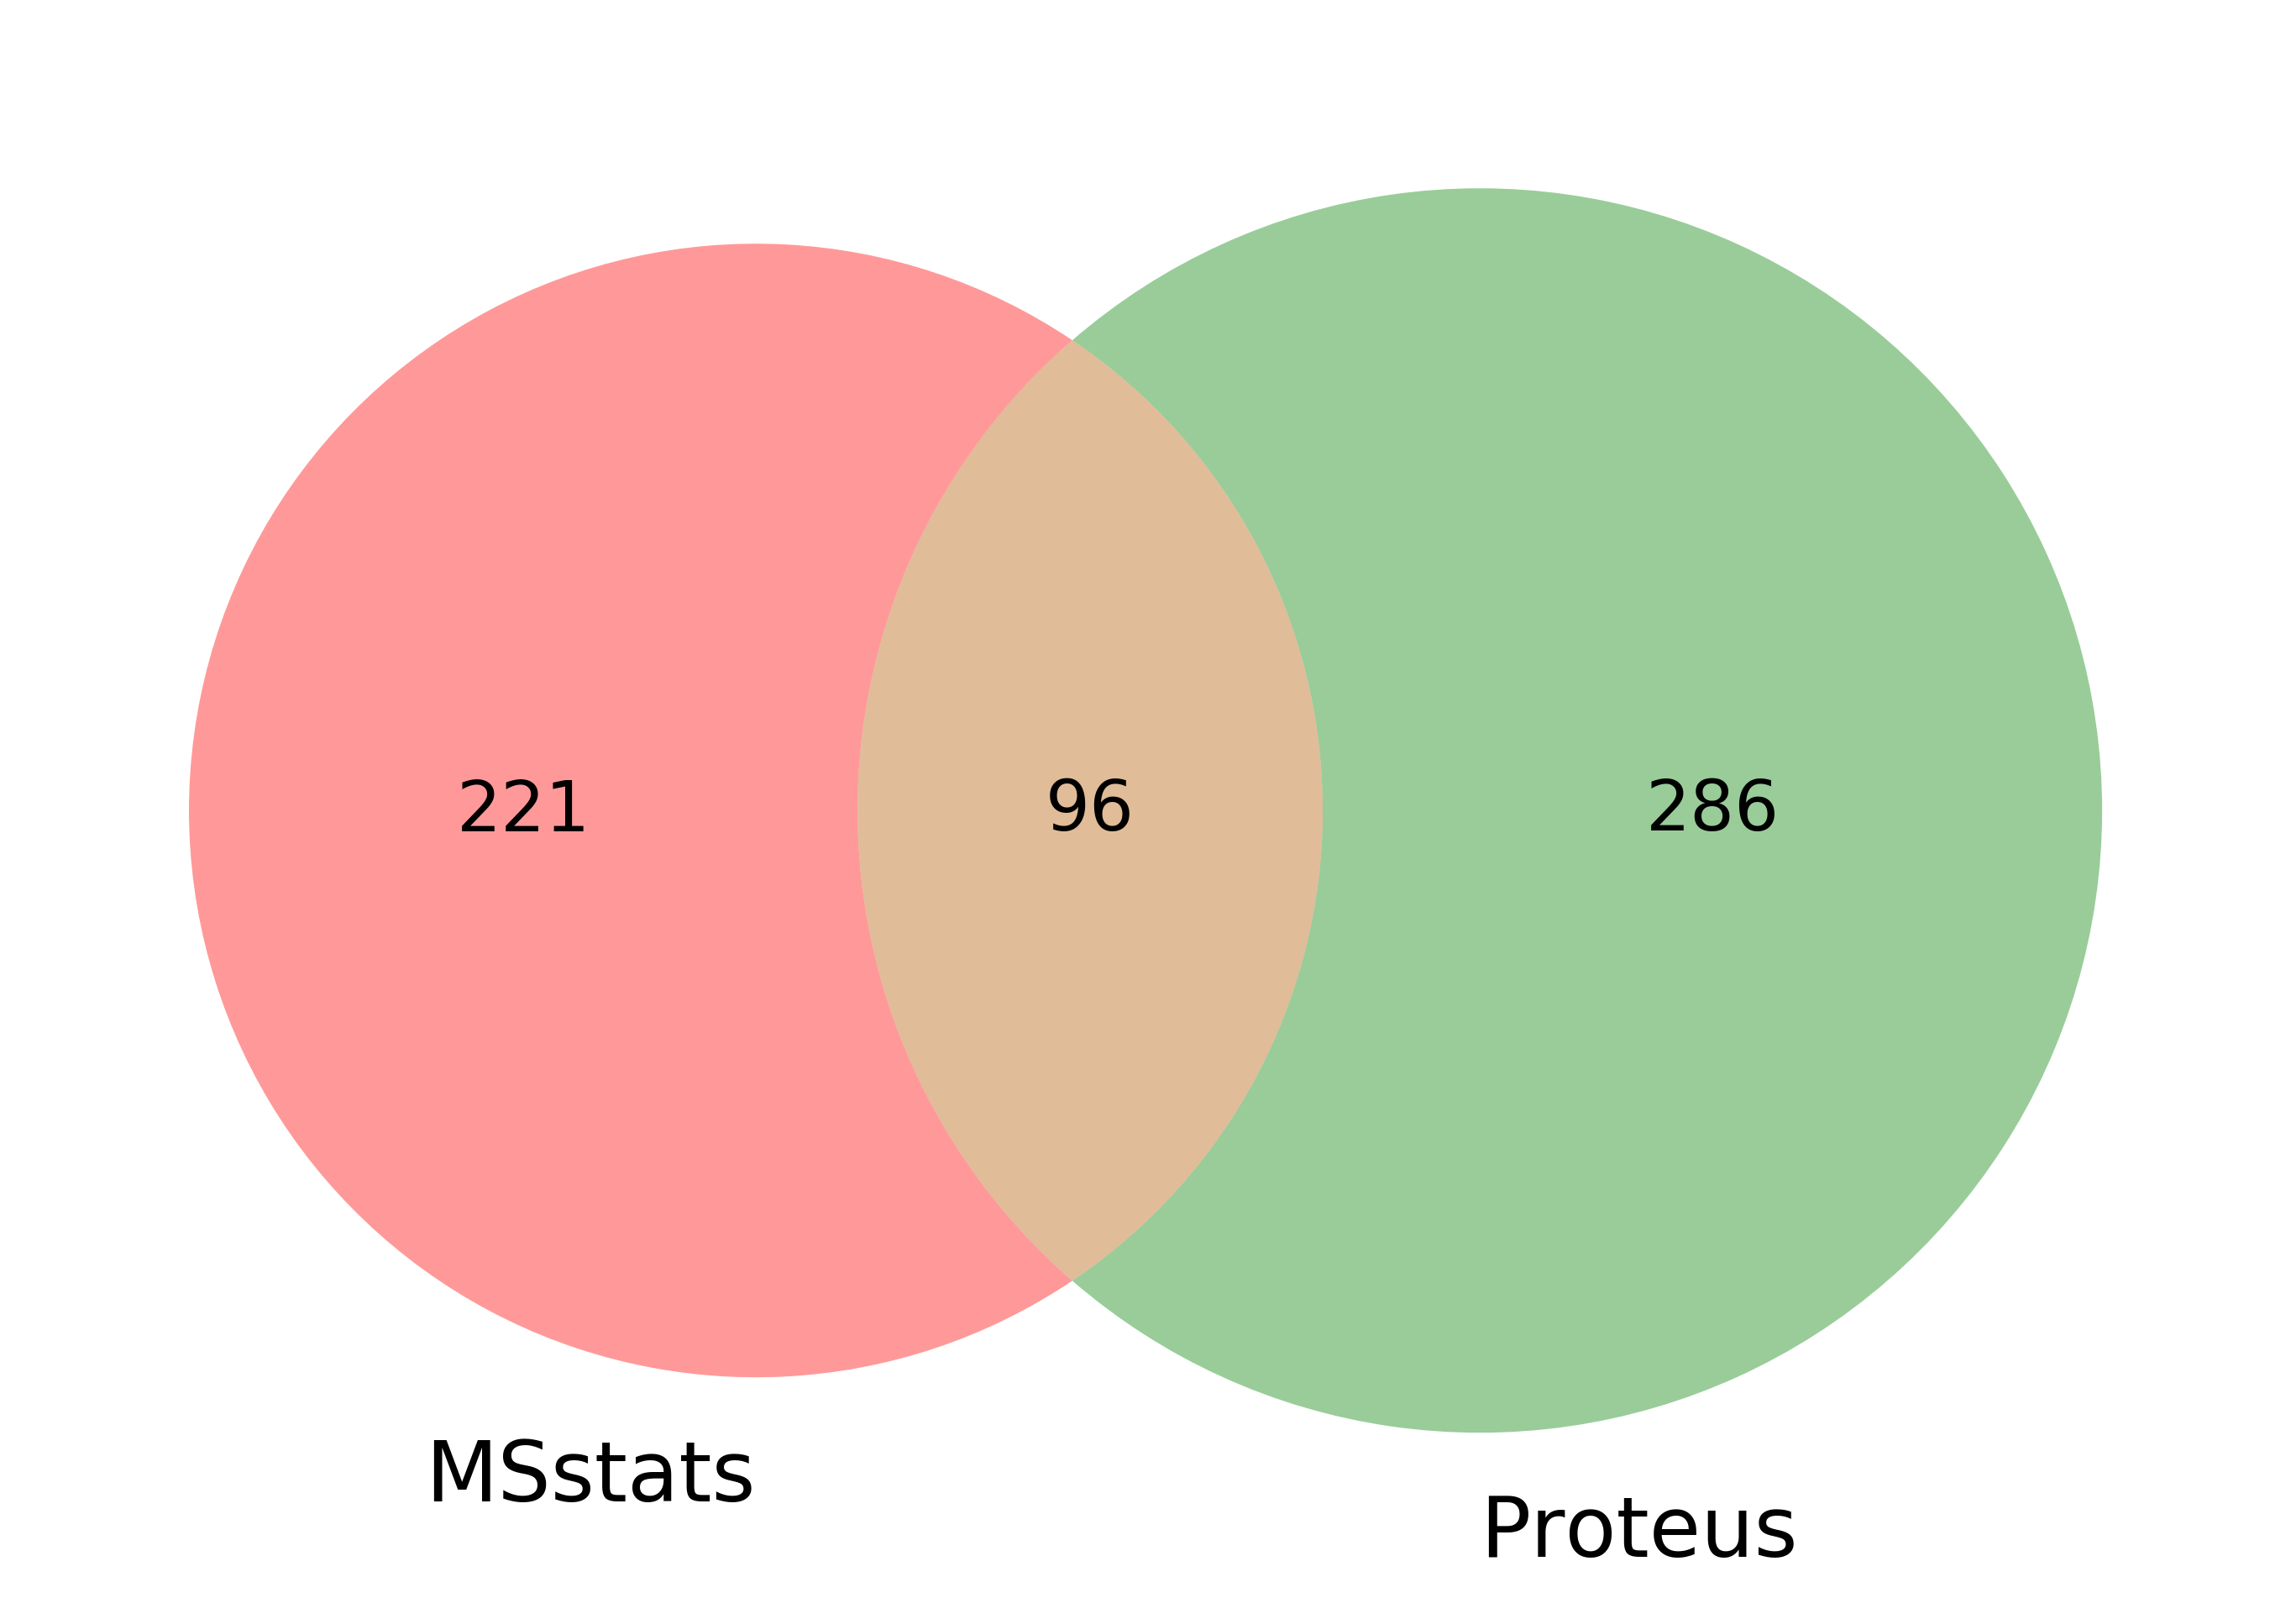

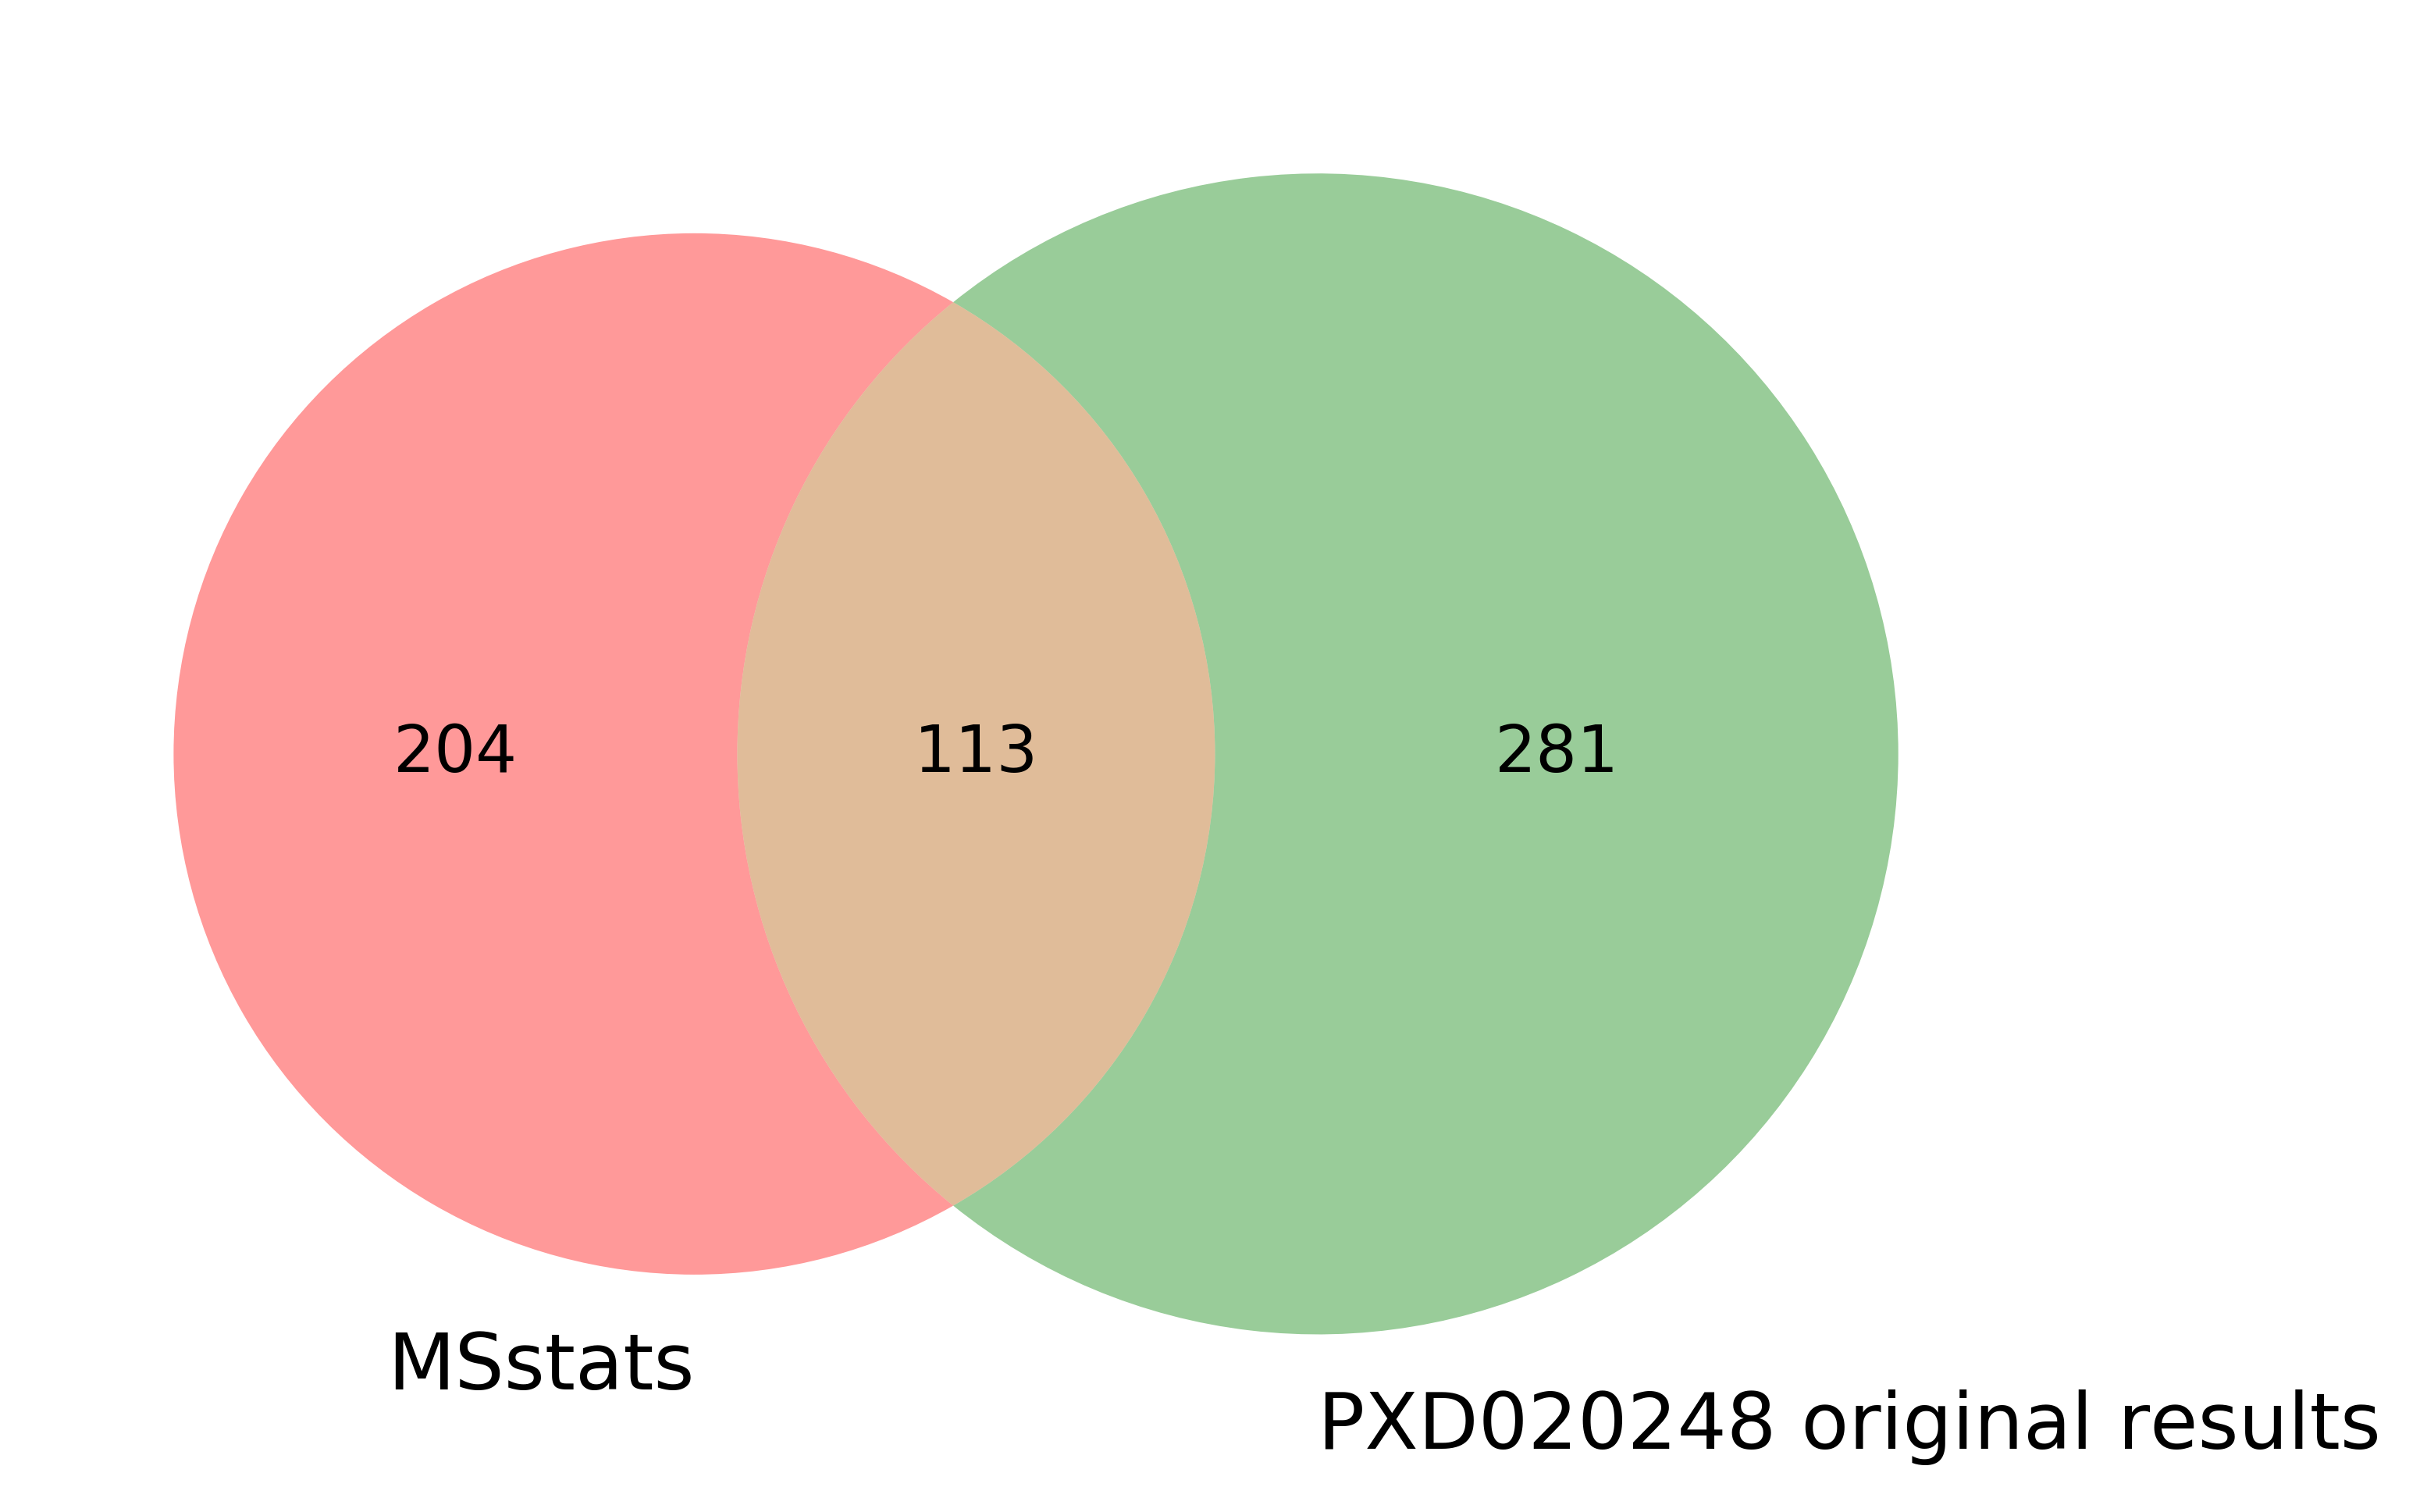

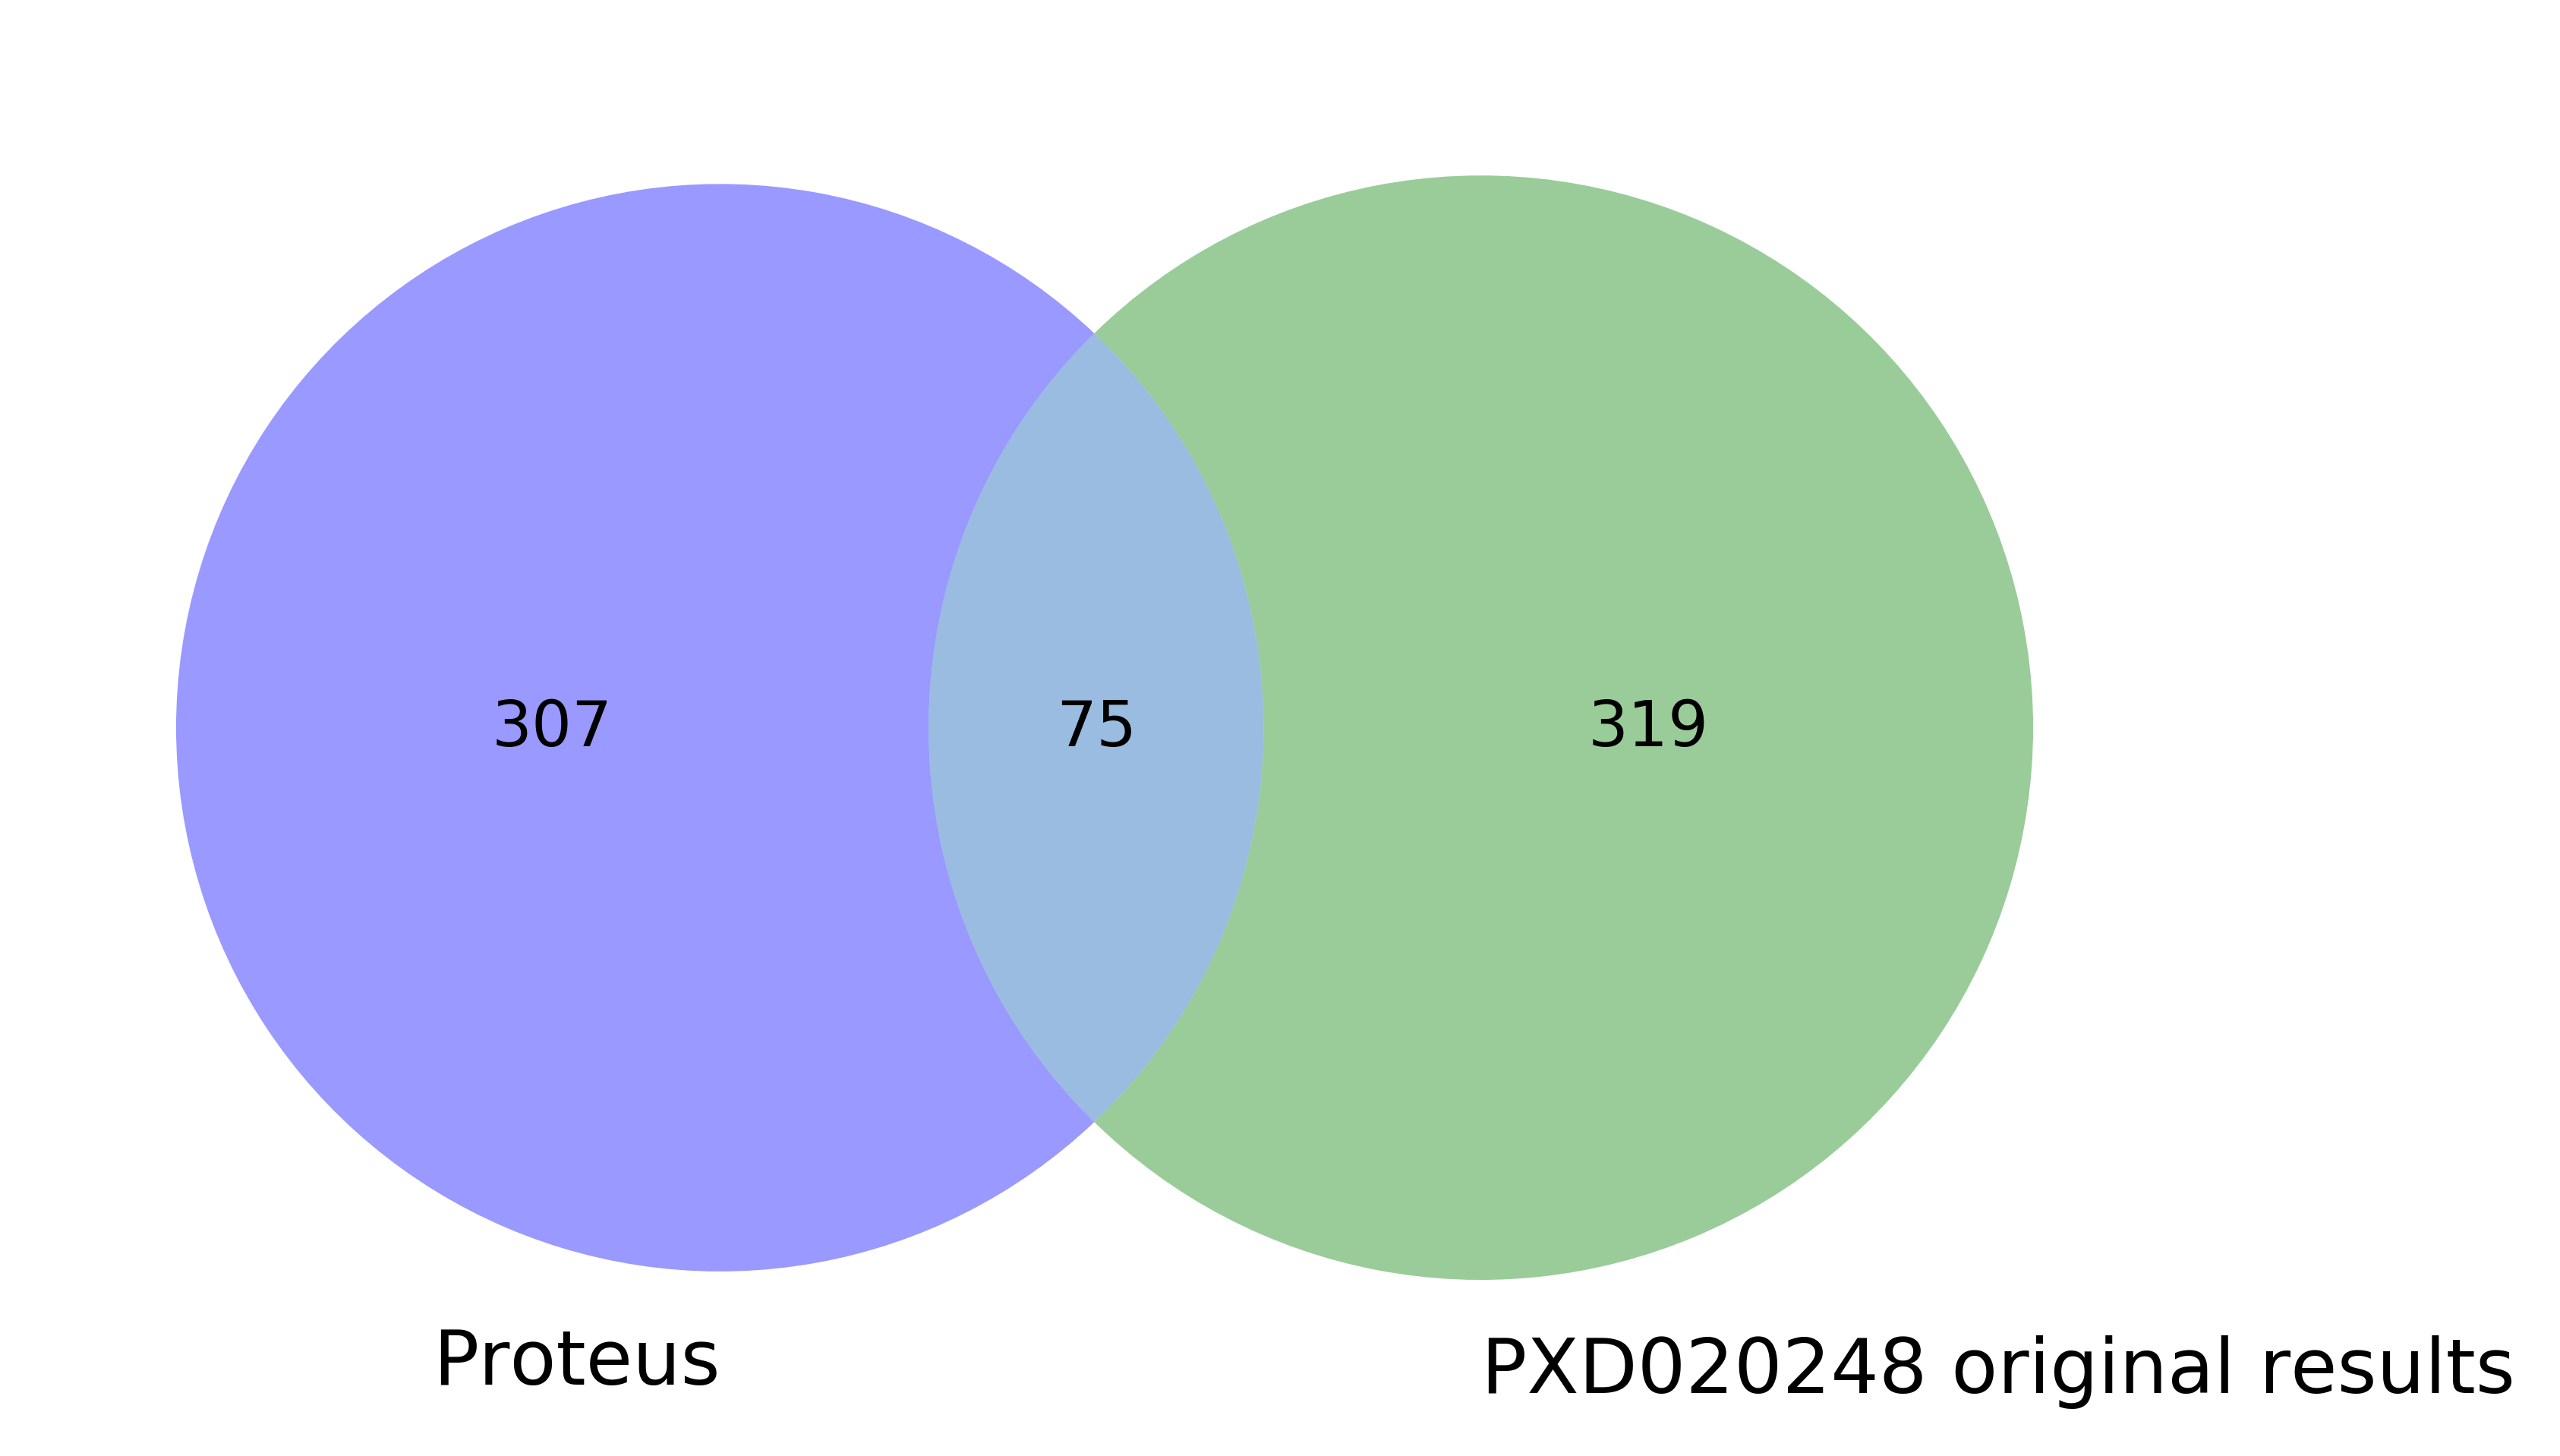

In [5]:
# pvalue < 0.05 and |log2FC| > 0.5
# from pyvenn import venn
from matplotlib_venn import venn2

em_comparison_res = pd.read_csv('./PXD020248/filter_em_comparison_res.csv', sep=',')
em_comparison_res = em_comparison_res[['Protein', 'Label', 'log2FC', 'pvalue', 'adj.pvalue']].dropna()
em_comparison_res["-Log10(p-value)"] = -np.log10(em_comparison_res['pvalue'])
em_comparison_res_dep = em_comparison_res[em_comparison_res["pvalue"] < 0.05]
em_comparison_res_dep["ProteinEntry"] = em_comparison_res_dep.apply(lambda x: ";".join(x.Protein.split("|")[1::2]), axis=1)


prodat_med_comp_res = pd.read_csv('./PXD020248/prodat_med_comp_res_filter.csv', sep=',')
prodat_med_comp_res = prodat_med_comp_res[['protein', 'logFC', 'adj.P.Val', 'P.Value']].dropna()
prodat_med_comp_res["-Log10(p-value)"] = -np.log10(prodat_med_comp_res['P.Value'])
prodat_med_comp_res_dep = prodat_med_comp_res[(prodat_med_comp_res["P.Value"] < 0.05)]
prodat_med_comp_res_dep["ProteinEntry"] = prodat_med_comp_res_dep.apply(lambda x: ";".join(x.protein.split("|")[1::2]), axis=1)

OriginalResultlfq = pd.read_excel("./PXD020248/1-s2.0-S0300483X20302912-mmc2.xlsx", sheet_name="sTable 1", header=3)
OrginalDEP = OriginalResultlfq[OriginalResultlfq["raw p-value <= 0.05"] == True]

# labels = venn.get_labels([set(em_comparison_res_dep['ProteinEntry']), set(prodat_med_comp_res_dep['ProteinEntry'])], set_colors=("r","g"))
# fig, ax = venn.venn2(labels, names=["MSstats", "Proteus"],dpi=600)
# plt.show()

plt.figure(dpi=600)
venn2(subsets=[set(em_comparison_res_dep['ProteinEntry']), set(prodat_med_comp_res_dep['ProteinEntry'])], set_labels=("MSstats", "Proteus"), set_colors=("r","g"))
plt.show()

# labels = venn.get_labels([set(prodat_med_comp_res_dep['ProteinEntry']), set(OrginalDEP['Accession'])])
# fig, ax = venn.venn2(labels, names=["MSstats", "Proteus"],dpi=600)
# plt.show()

plt.figure(dpi=600)
venn2(subsets=[set(em_comparison_res_dep['ProteinEntry']), set(OrginalDEP['Accession'])], set_labels=("MSstats", "PXD020248 original results"), set_colors=("r","g"))
plt.show()

plt.figure(dpi=600)
venn2(subsets=[set(prodat_med_comp_res_dep['ProteinEntry']), set(OrginalDEP['Accession'])], set_labels=("Proteus", "PXD020248 original results"), set_colors=("b","g"))
plt.show()

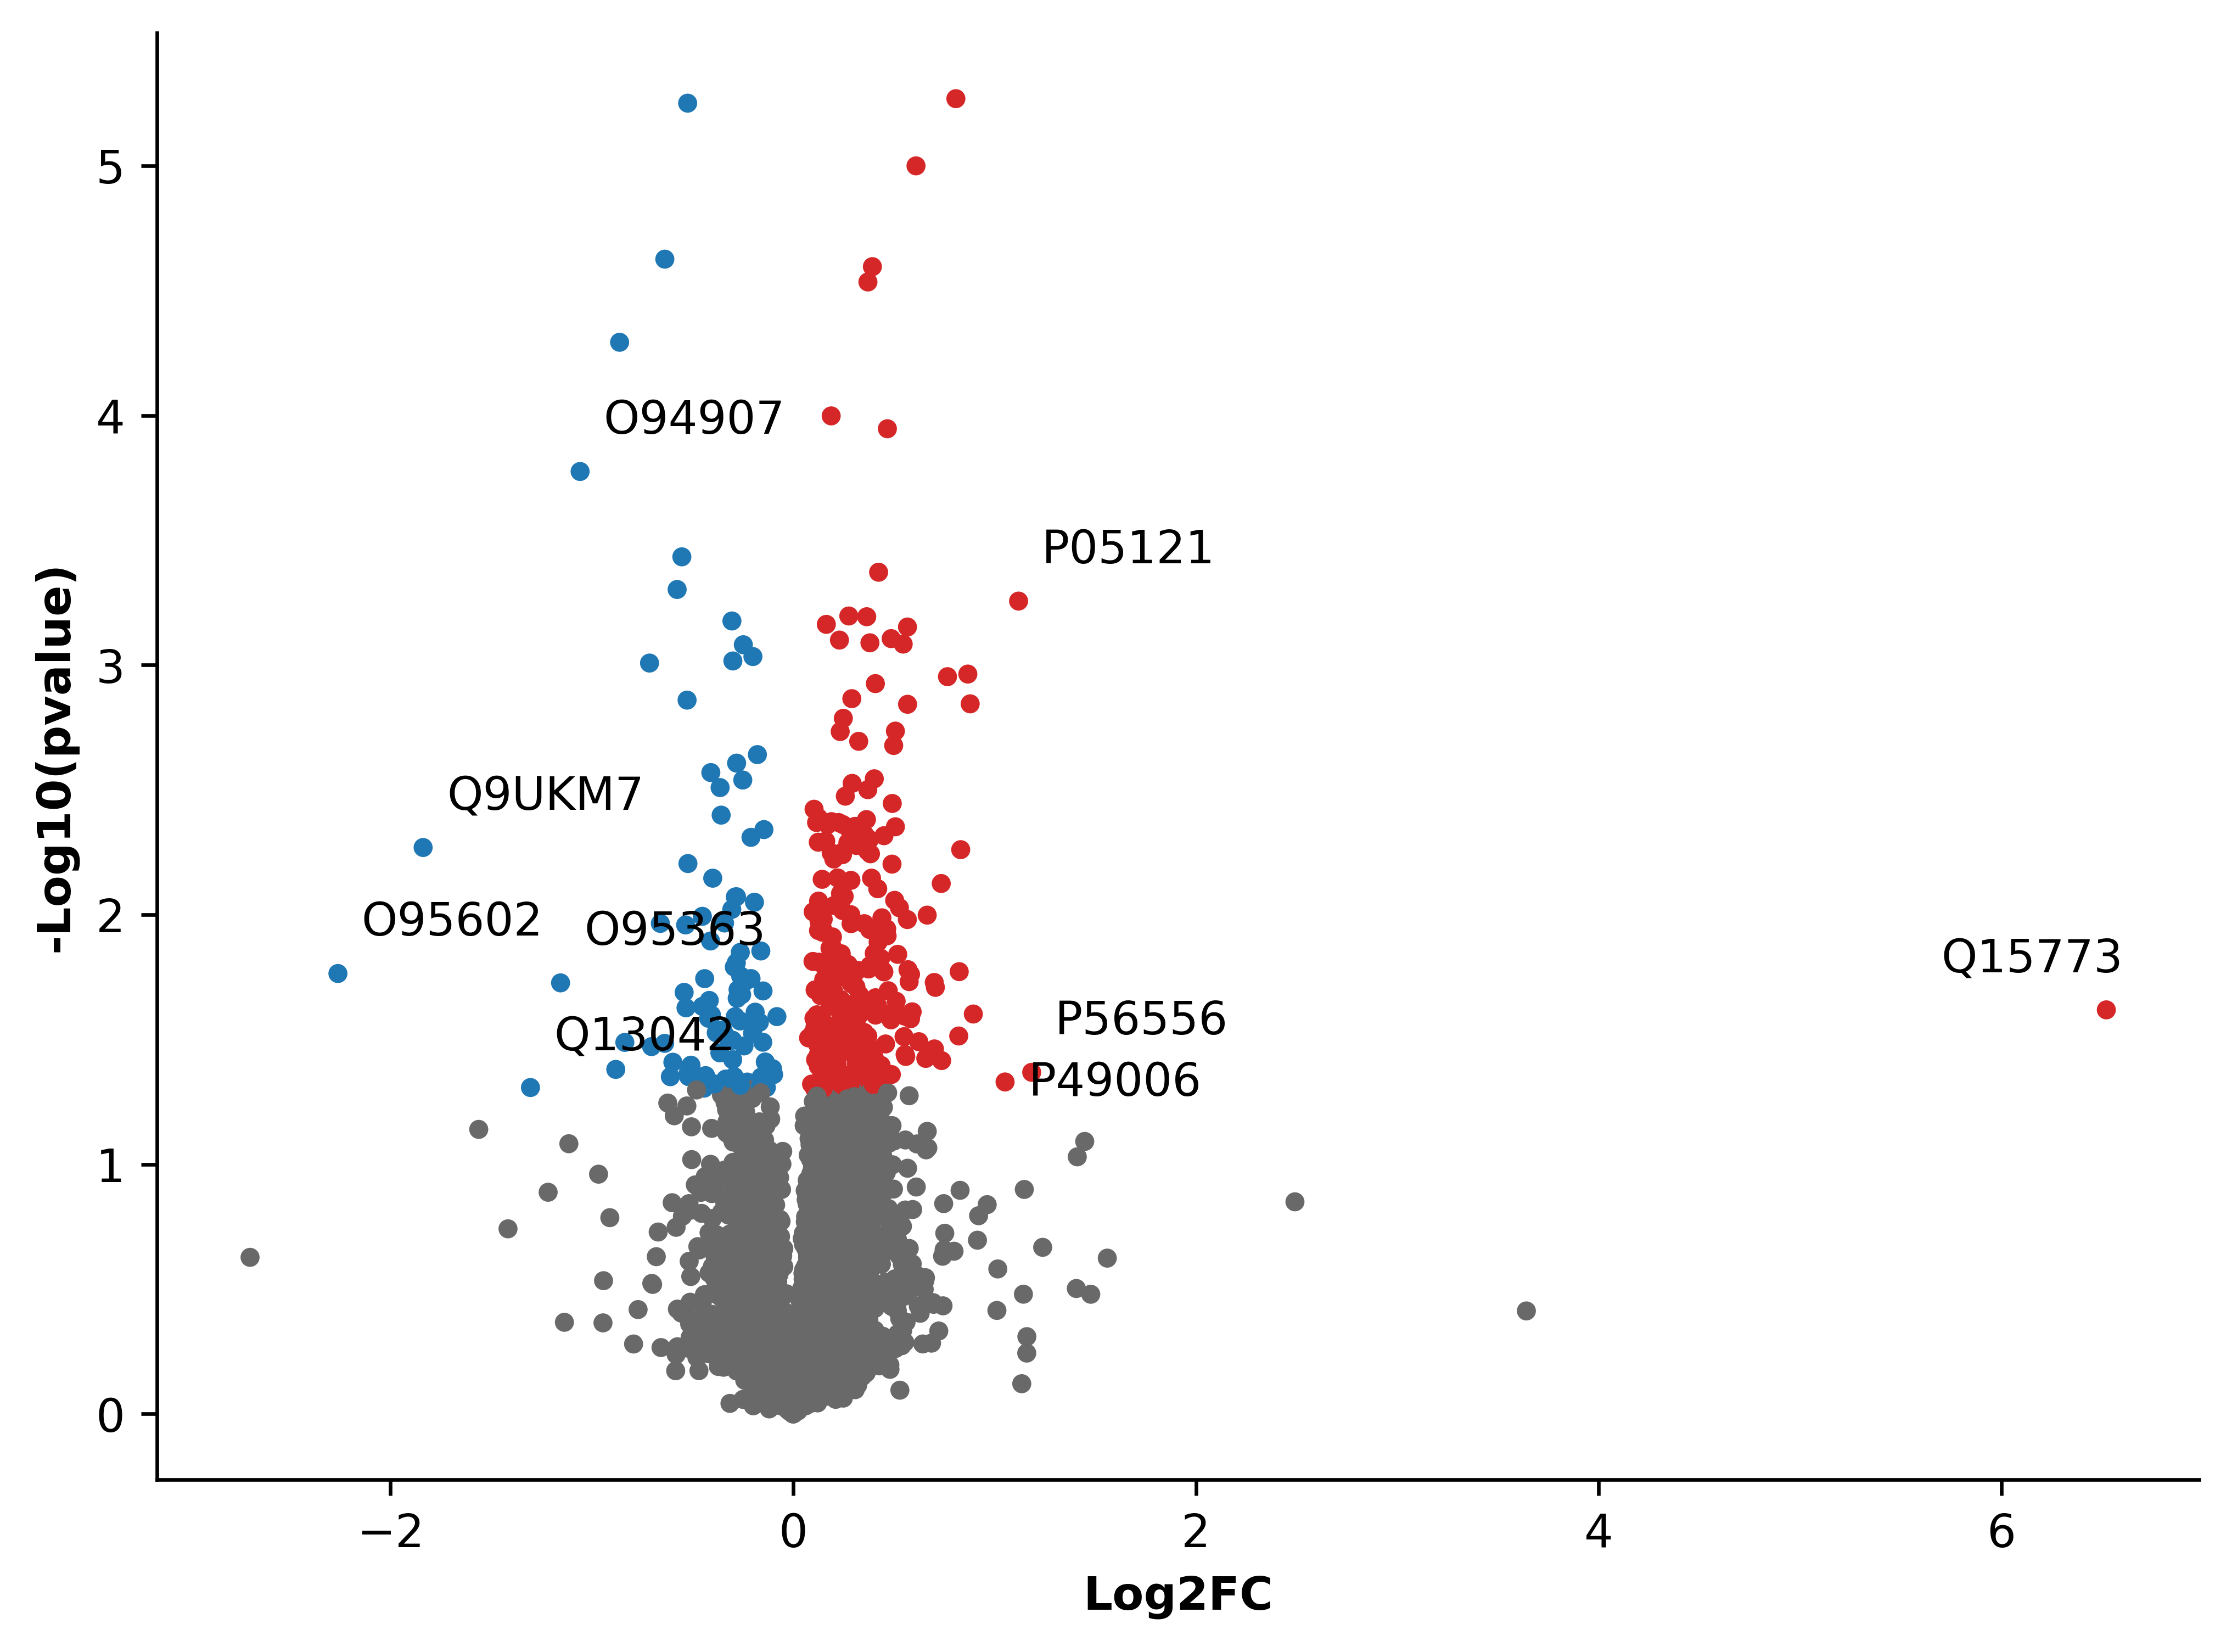

In [87]:
#up, normal, down
em_comparison_res['group'] = 'black'
em_comparison_res.loc[(em_comparison_res['log2FC'] > 0)&(em_comparison_res['pvalue'] < 0.05),'group'] = 'tab:red' 
em_comparison_res.loc[(em_comparison_res['log2FC'] < 0)&(em_comparison_res['pvalue'] < 0.05),'group'] = 'tab:blue'
em_comparison_res.loc[em_comparison_res['pvalue'] >= 0.05,'group'] = 'dimgrey'


xmin=-2
xmax=2
ymin=-2
ymax=10
fig = plt.figure(figsize=(8, 32), dpi=600)
i = 1
for comp in np.unique(em_comparison_res['Label']):
    data = em_comparison_res[em_comparison_res['Label'] == comp]
    ax = fig.add_subplot(410 + i)0
#     ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax), title='')
    ax.scatter(data['log2FC'], data["-Log10(p-value)"], s=10, c=data['group'])
    ax.set_ylabel('-Log10(pvalue)',fontweight='bold')
    ax.set_xlabel('Log2FC',fontweight='bold')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False) 
    
#     ax.vlines(-1, ymin, ymax, color='dimgrey',linestyle='dashed', linewidth=1) 
#     ax.vlines(1, ymin, ymax, color='dimgrey',linestyle='dashed', linewidth=1) 
#     ax.hlines(-np.log10(0.05), xmin, xmax, color='dimgrey',linestyle='dashed', linewidth=1)

#     ax.set_xticks(range(-2,2,1)) 
#     ax.set_yticks(range(0,,3)) 
#     ax.set_title(comp)
    i += 1
    t = []
    for _,row in data[(data['group'] != 'dimgrey')&(np.abs(data['log2FC']) > 1)].iterrows():
        t.append(ax.annotate(row['Protein'].split("|")[1], xy = (row['log2FC'], row['-Log10(p-value)']), xytext = (row['log2FC']+0.1, row['-Log10(p-value)']+0.1)))

adjust_text(t, )
plt.subplots_adjust(wspace=0.5,hspace=0.5) 
plt.show()

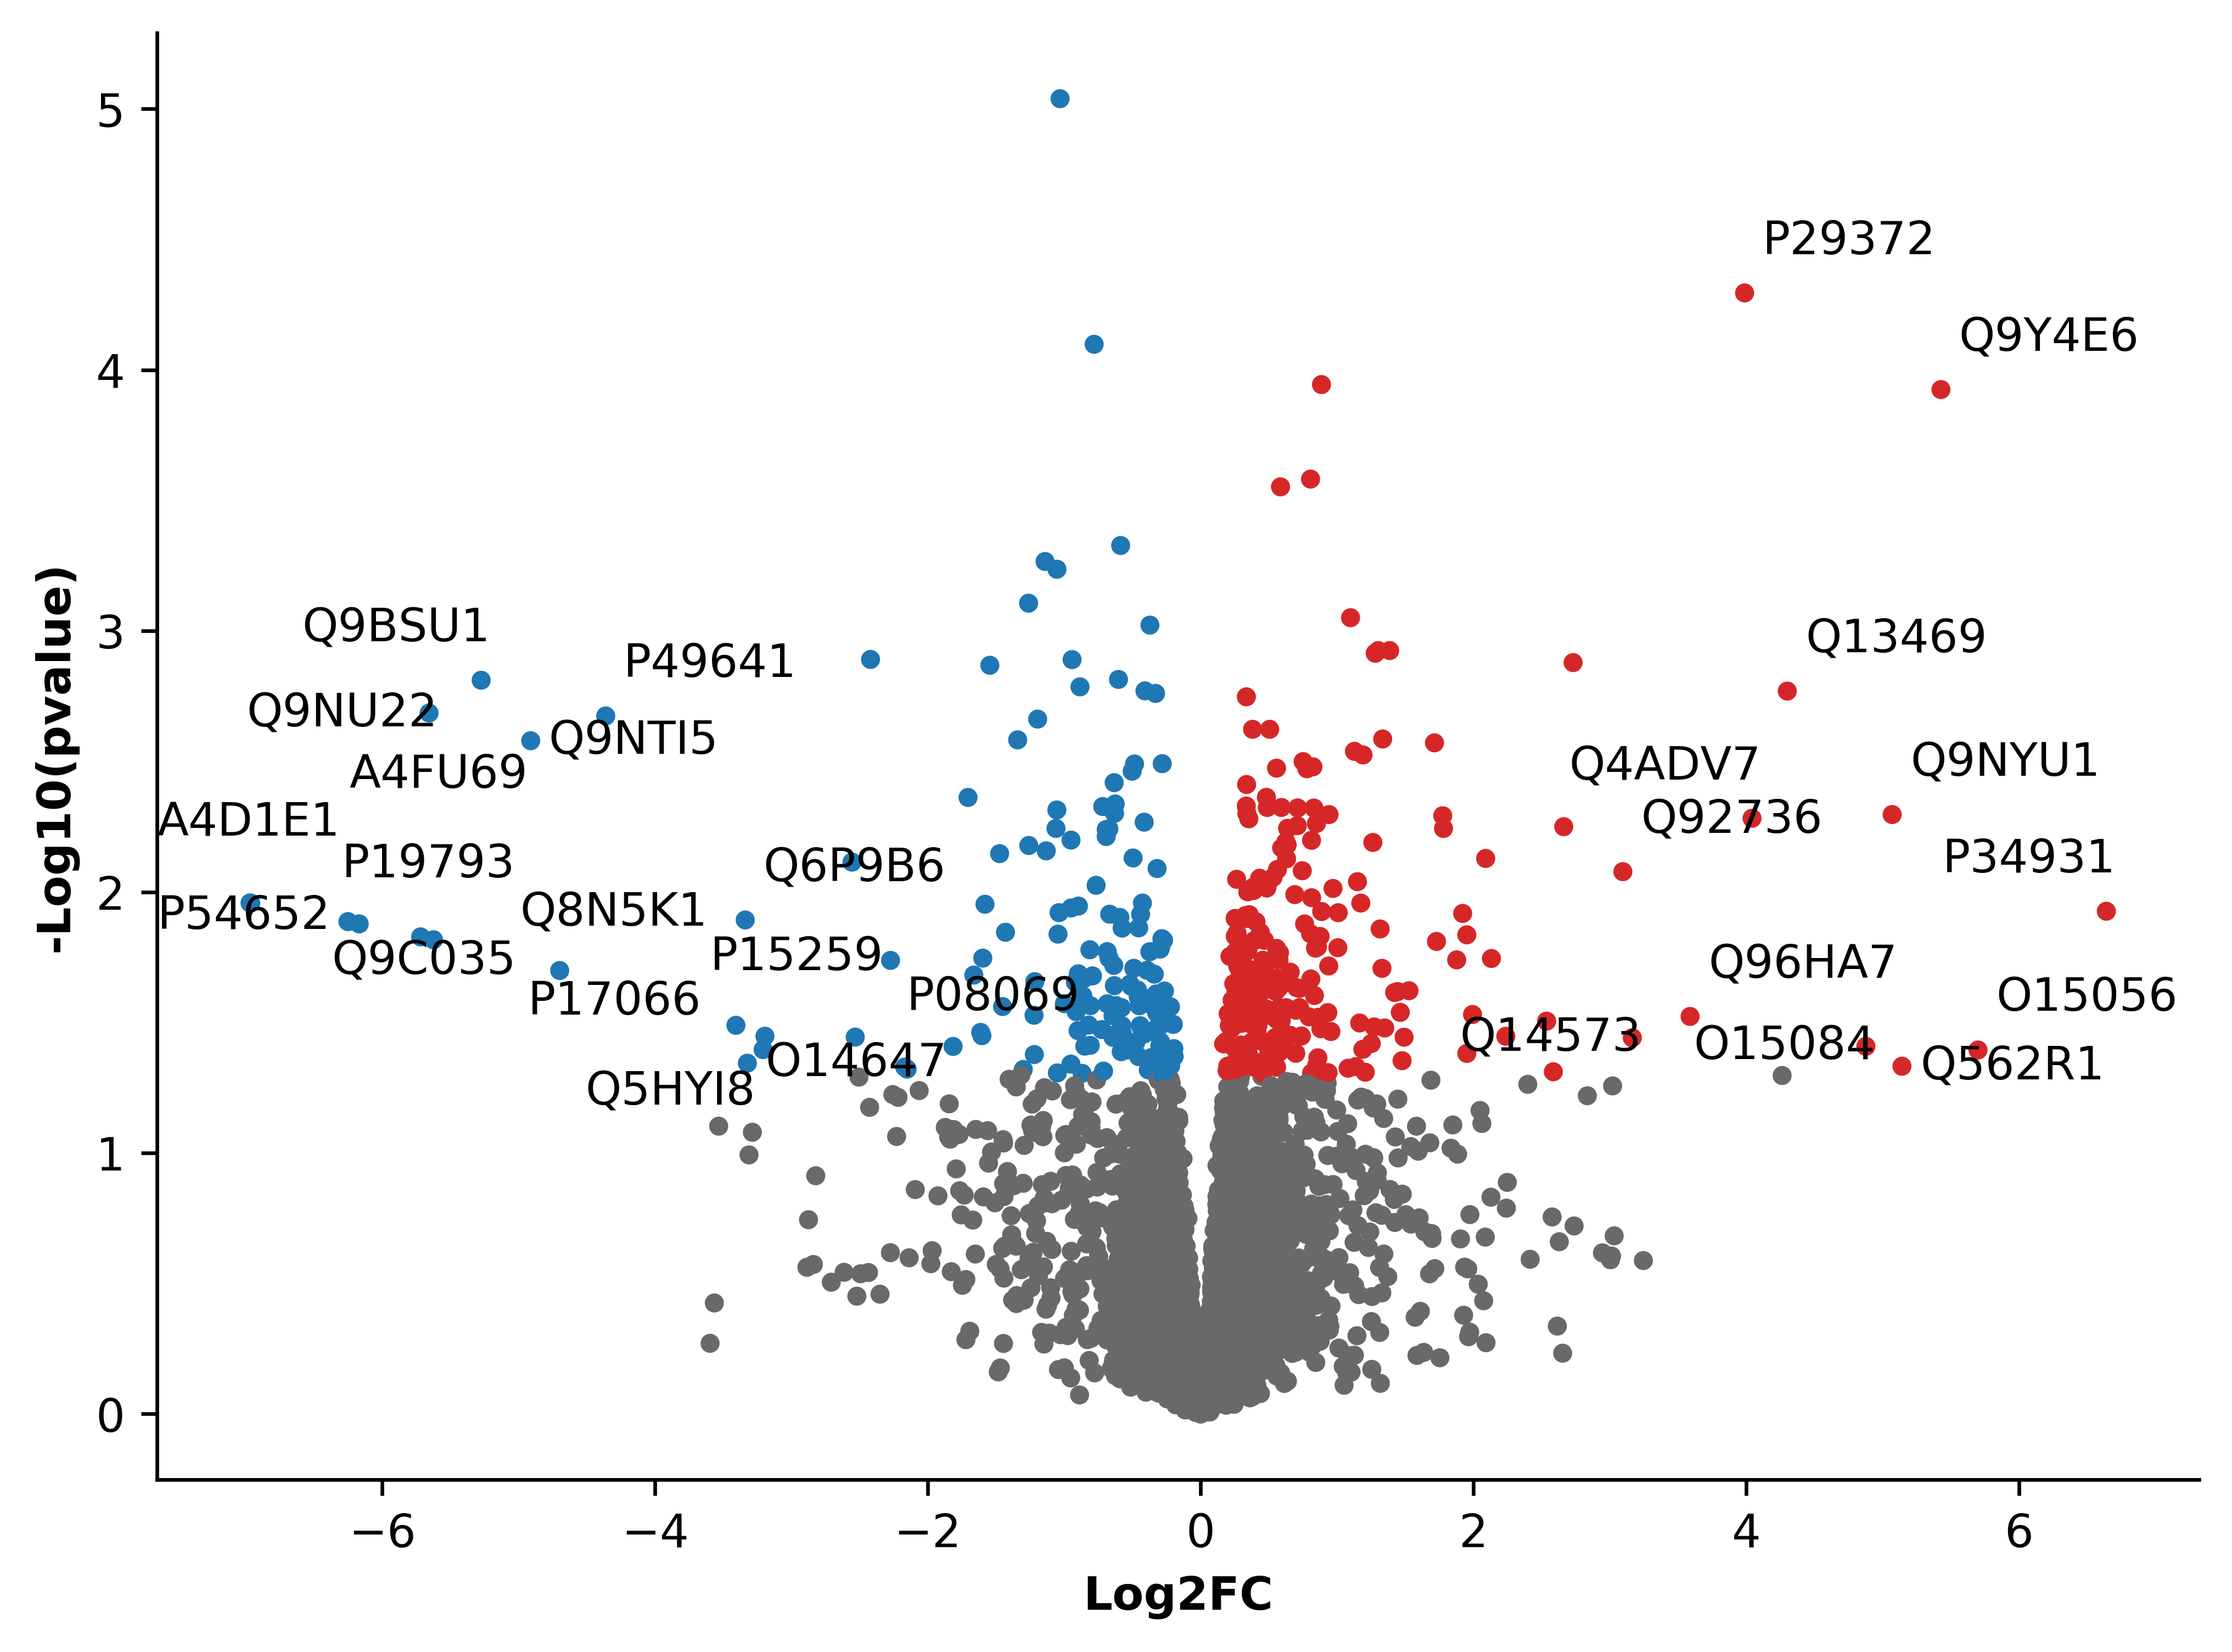

In [85]:
#up, normal, down
prodat_med_comp_res['group'] = 'black'
prodat_med_comp_res['logFC'] = -prodat_med_comp_res['logFC']
prodat_med_comp_res.loc[(prodat_med_comp_res['logFC'] > 0)&(prodat_med_comp_res['P.Value'] < 0.05),'group'] = 'tab:red' 
prodat_med_comp_res.loc[(prodat_med_comp_res['logFC'] < 0)&(prodat_med_comp_res['P.Value'] < 0.05),'group'] = 'tab:blue'
prodat_med_comp_res.loc[prodat_med_comp_res['P.Value'] >= 0.05,'group'] = 'dimgrey'


xmin=-2
xmax=2
ymin=-2
ymax=10
fig = plt.figure(figsize=(8, 32), dpi=600)
i = 1

data = prodat_med_comp_res
ax = fig.add_subplot(410 + i)
#     ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax), title='')
ax.scatter(data['logFC'], data["-Log10(p-value)"], s=10, c=data['group'])
ax.set_ylabel('-Log10(pvalue)',fontweight='bold')
ax.set_xlabel('Log2FC',fontweight='bold')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False) 

i += 1
t = []
for _,row in data[(data['group'] != 'dimgrey')&(np.abs(data['logFC']) > 3)].iterrows():
    t.append(ax.annotate(row['protein'].split("|")[1], xy = (row['logFC'], row['-Log10(p-value)']), xytext = (row['logFC']+0.1, row['-Log10(p-value)']+0.1)))

adjust_text(t, )
plt.subplots_adjust(wspace=0.5,hspace=0.5) 
plt.show()

C:\Users\ChengXin\MyProgram\python\anaconda\pro\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\ChengXin\MyProgram\python\anaconda\pro\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


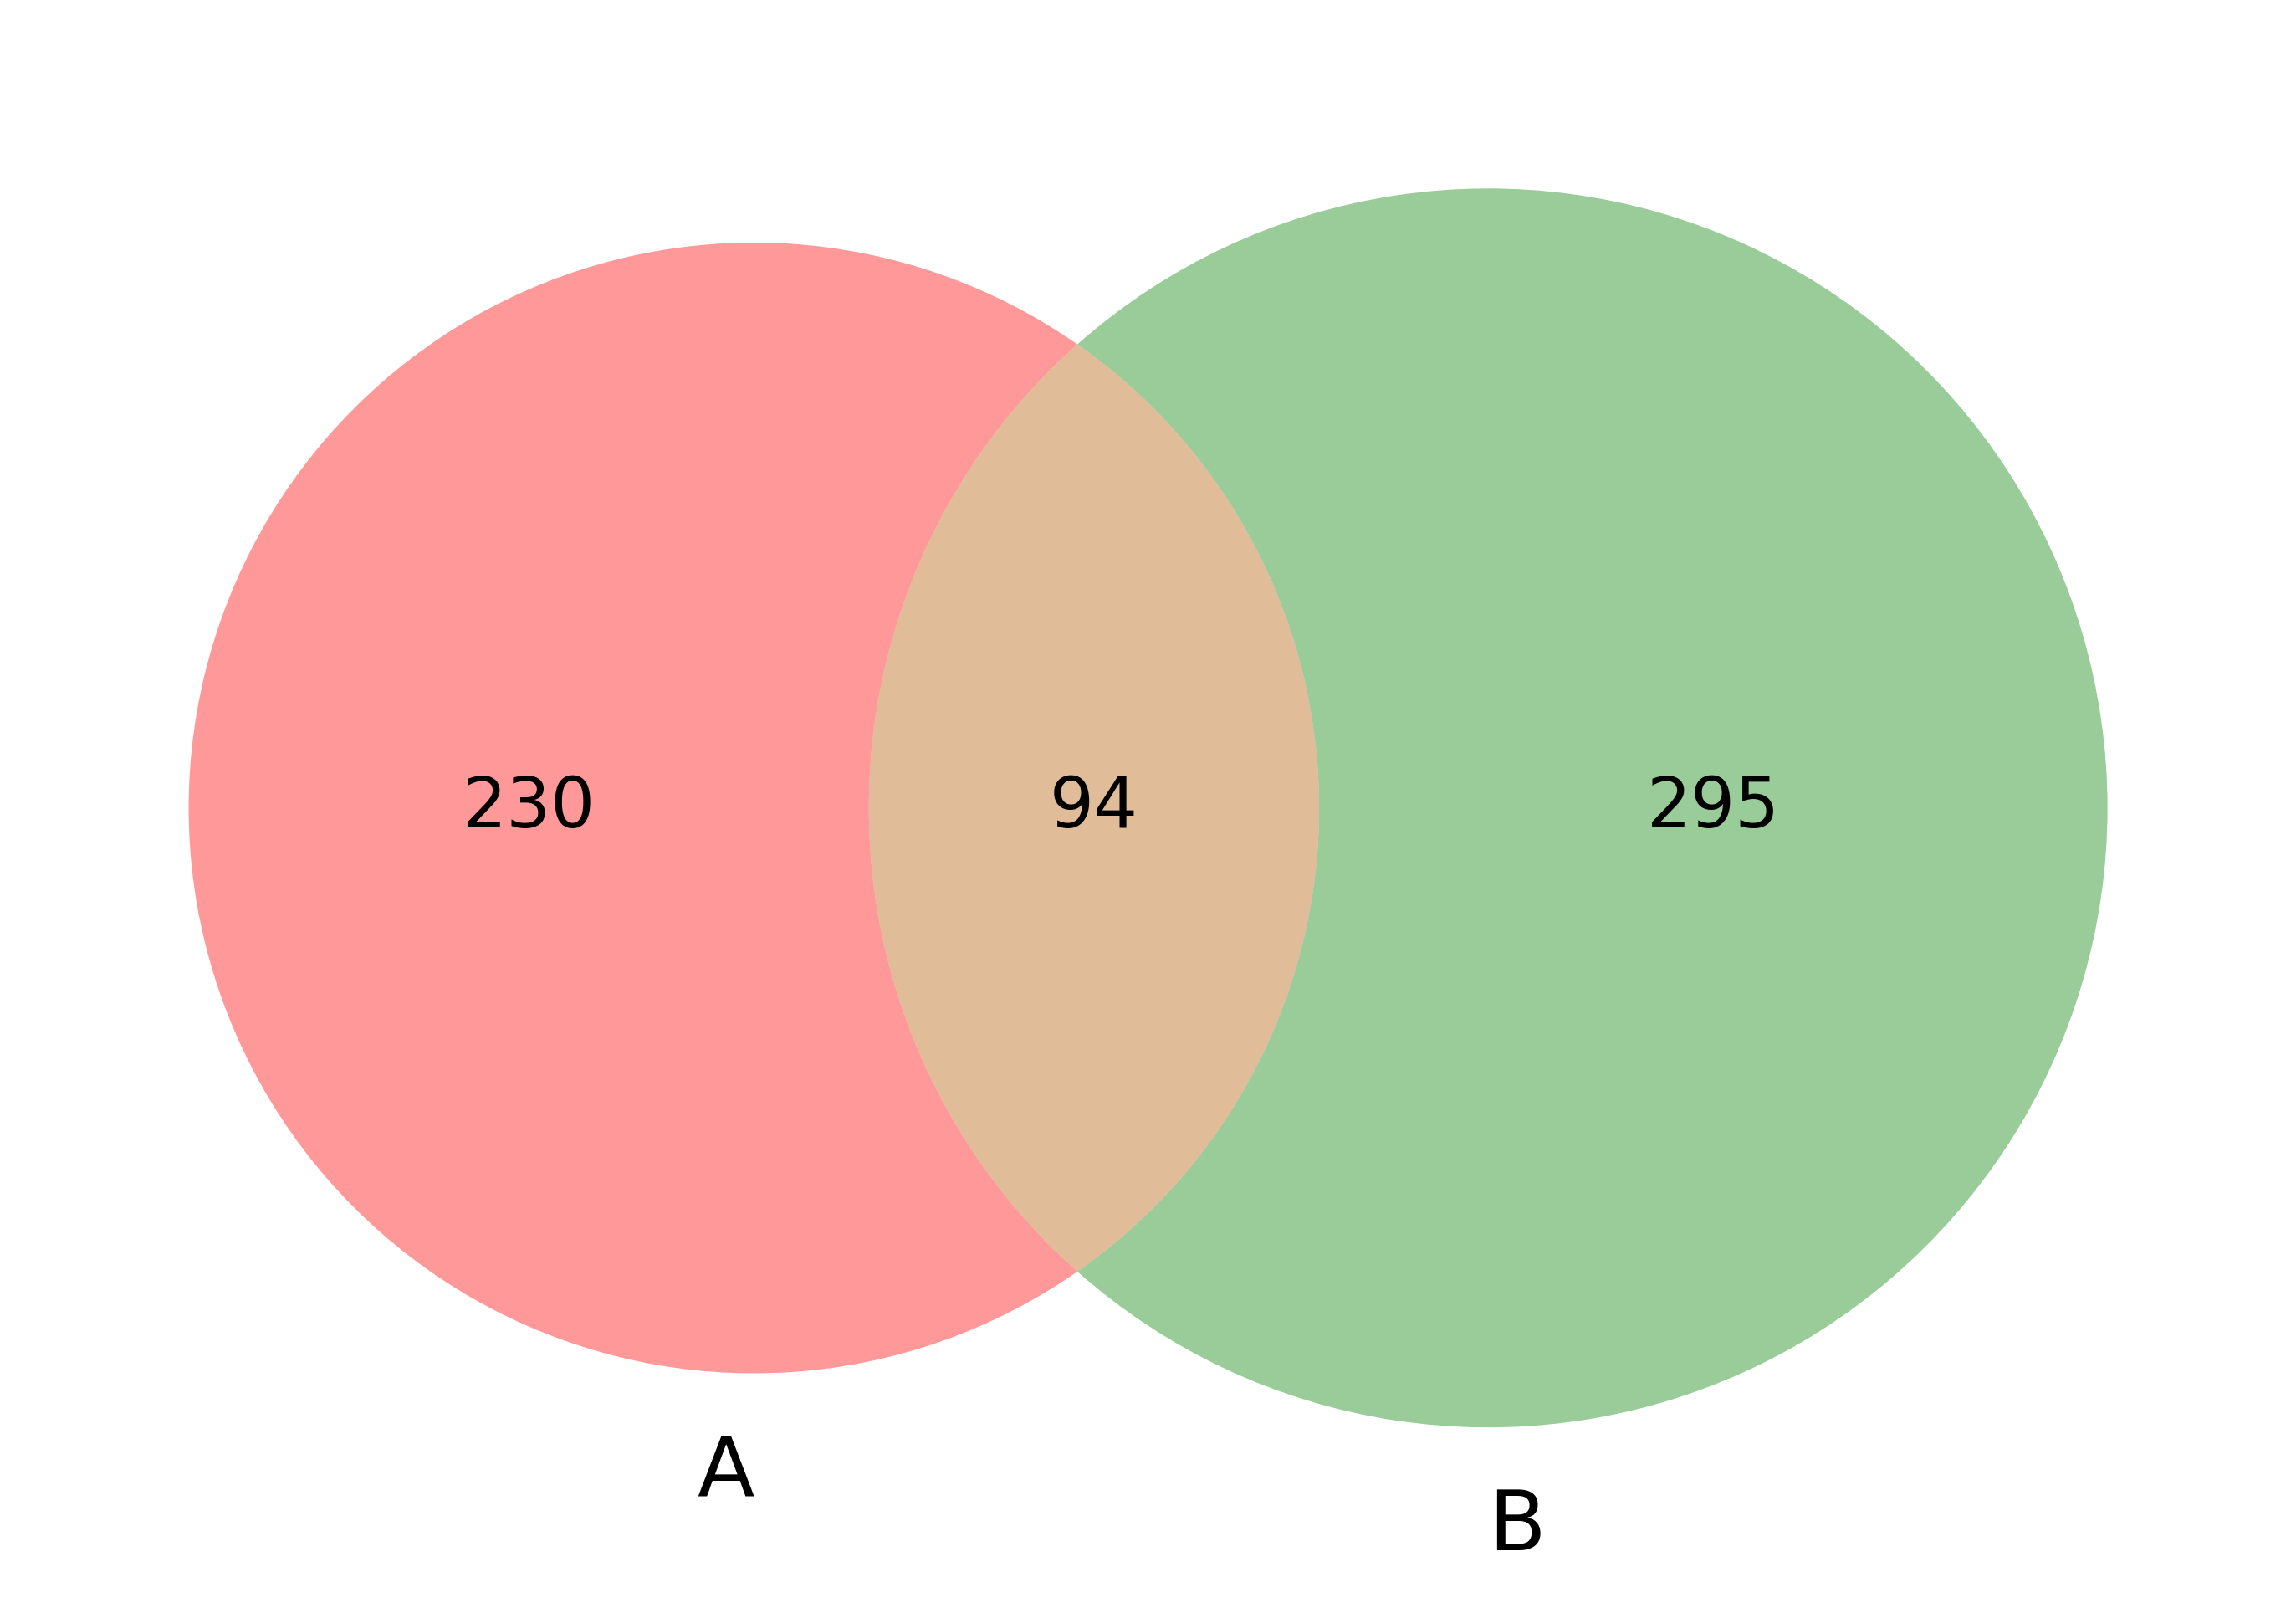

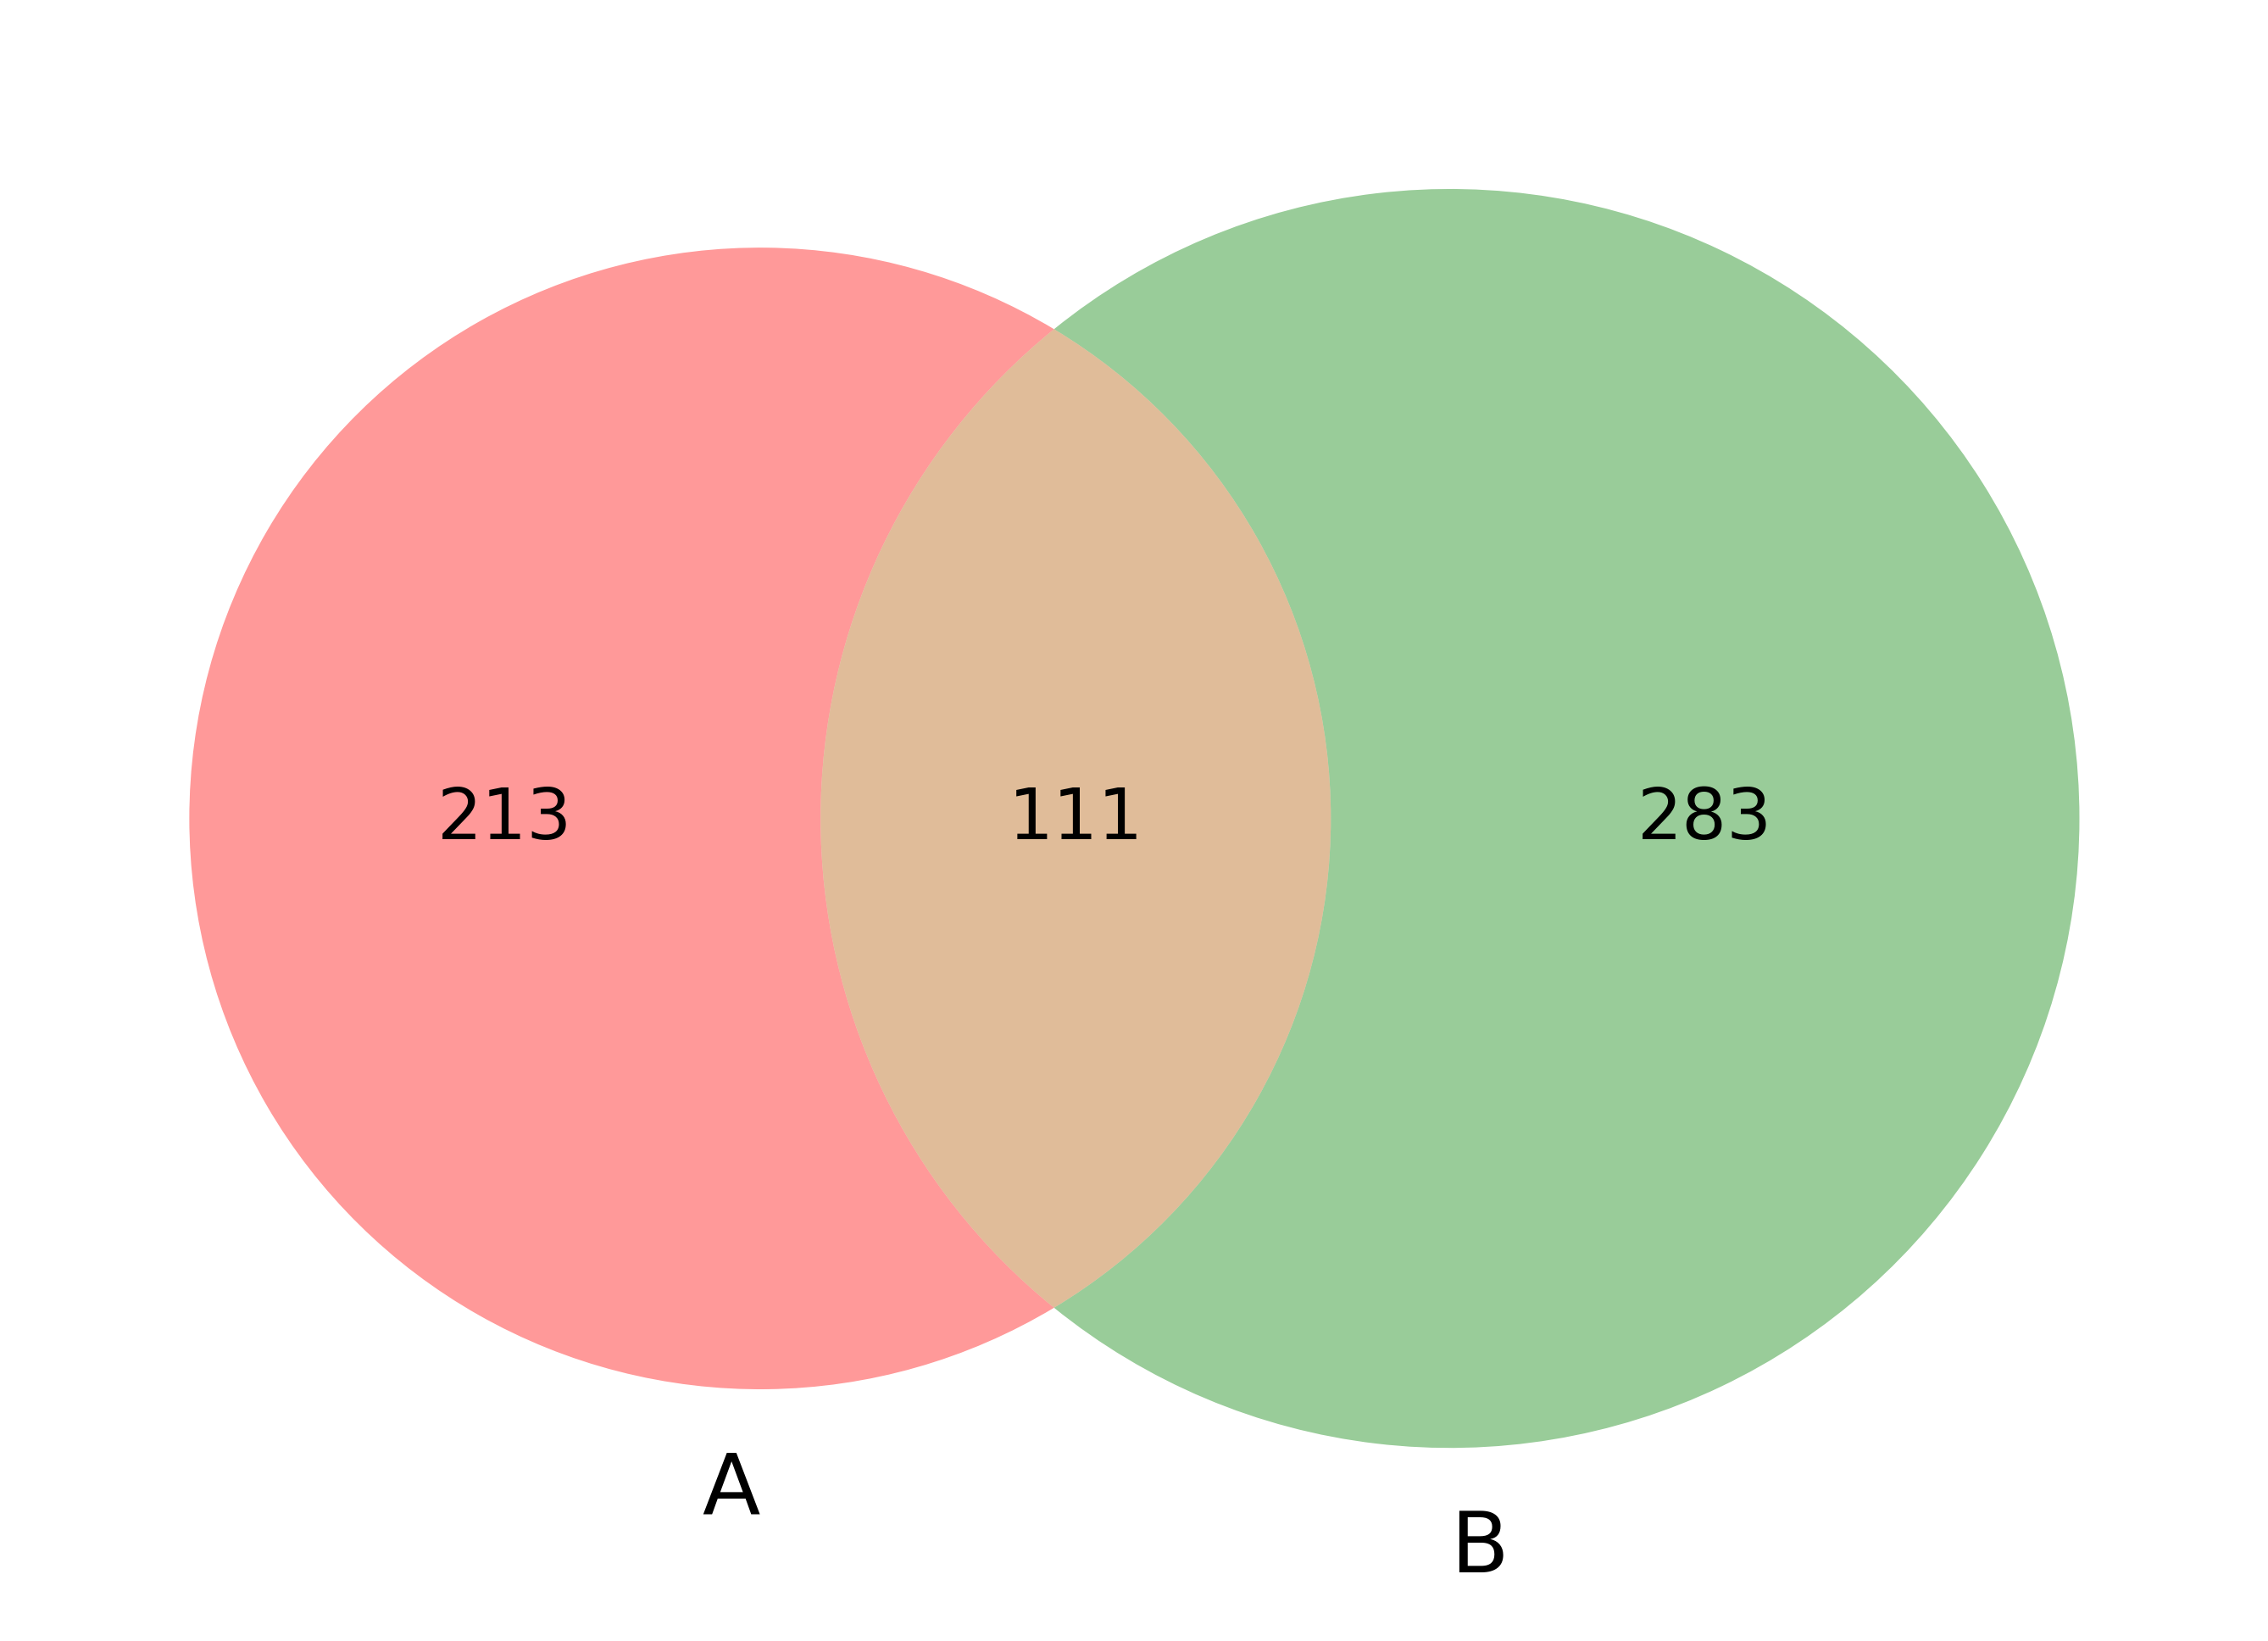

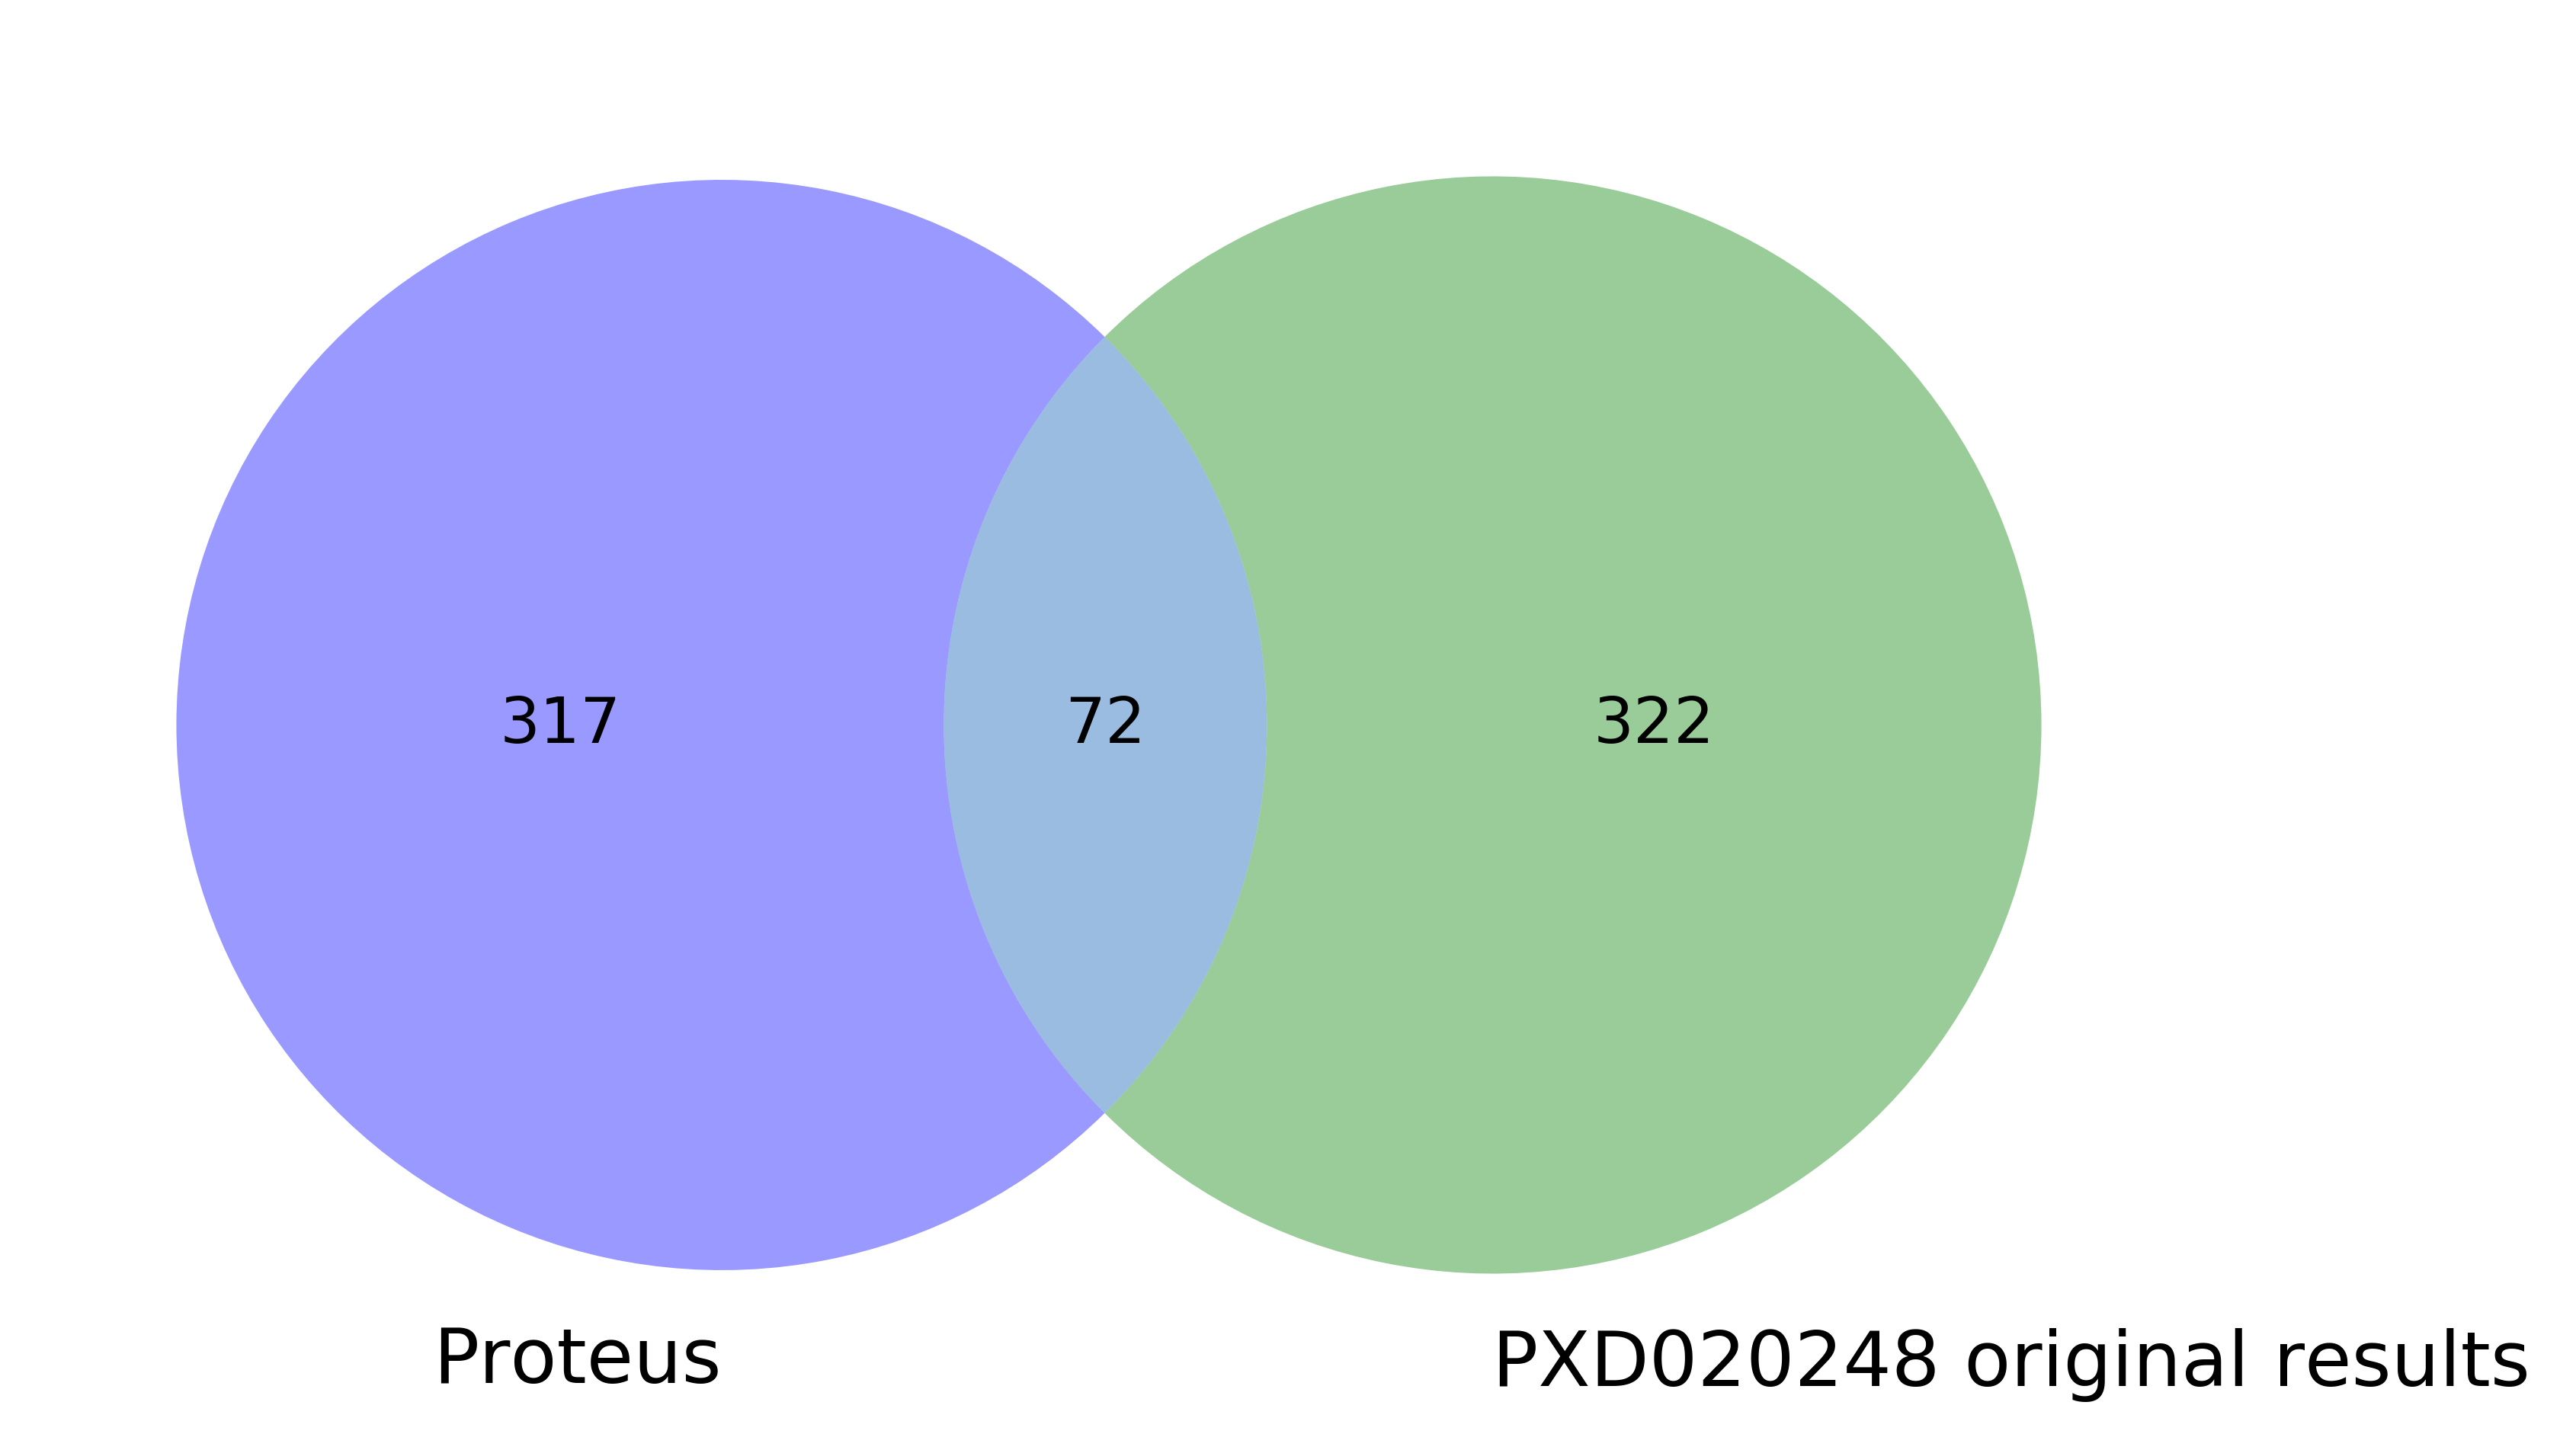

In [6]:
# pvalue < 0.05 and |log2FC| > 0.5
from pyvenn import venn

quantile_comparison_res = pd.read_csv('./PXD020248/quantile_comparison_res_filter.csv', sep=',')
quantile_comparison_res = quantile_comparison_res[['Protein', 'Label', 'log2FC', 'pvalue', 'adj.pvalue']].dropna()
quantile_comparison_res["-Log10(p-value)"] = -np.log10(quantile_comparison_res['pvalue'])
quantile_comparison_res_dep = quantile_comparison_res[quantile_comparison_res["pvalue"] < 0.05]
quantile_comparison_res_dep["ProteinEntry"] = quantile_comparison_res_dep.apply(lambda x: ";".join(x["Protein"].split("|")[1::2]), axis=1)

prodat_quantile_comp_res = pd.read_csv('./PXD020248/prodat_quantile_comp_res_filter.csv', sep=',')
prodat_quantile_comp_res = prodat_quantile_comp_res[['protein', 'logFC', 'adj.P.Val', 'P.Value']].dropna()
prodat_quantile_comp_res["-Log10(p-value)"] = -np.log10(prodat_quantile_comp_res['P.Value'])
prodat_quantile_comp_res_dep = prodat_quantile_comp_res[prodat_quantile_comp_res["P.Value"] < 0.05]
prodat_quantile_comp_res_dep["ProteinEntry"] = prodat_quantile_comp_res_dep.apply(lambda x: ";".join(x["protein"].split("|")[1::2]), axis=1)


OriginalResultlfq = pd.read_excel("./PXD020248/1-s2.0-S0300483X20302912-mmc2.xlsx", sheet_name="sTable 1", header=3)
OrginalDEP = OriginalResultlfq[OriginalResultlfq["raw p-value <= 0.05"] == True]

plt.figure(dpi=600)
venn2(subsets=[set(quantile_comparison_res_dep['ProteinEntry']), set(prodat_quantile_comp_res_dep['ProteinEntry'])], set_labels=("A", "B"), set_colors=("r","g"))
plt.show()

# labels = venn.get_labels([set(prodat_quantile_comp_res_dep['ProteinEntry']), set(OrginalDEP['Accession'])])
# fig, ax = venn.venn2(labels, names=["MSstats", "Proteus"],dpi=600)
# plt.show()

plt.figure(dpi=600)
venn2(subsets=[set(quantile_comparison_res_dep['ProteinEntry']), set(OrginalDEP['Accession'])], set_labels=("A", "B"), set_colors=("r","g"))
plt.show()

plt.figure(dpi=600)
venn2(subsets=[set(prodat_quantile_comp_res_dep['ProteinEntry']), set(OrginalDEP['Accession'])], set_labels=("Proteus", "PXD020248 original results"), set_colors=("b","g"))
plt.show()

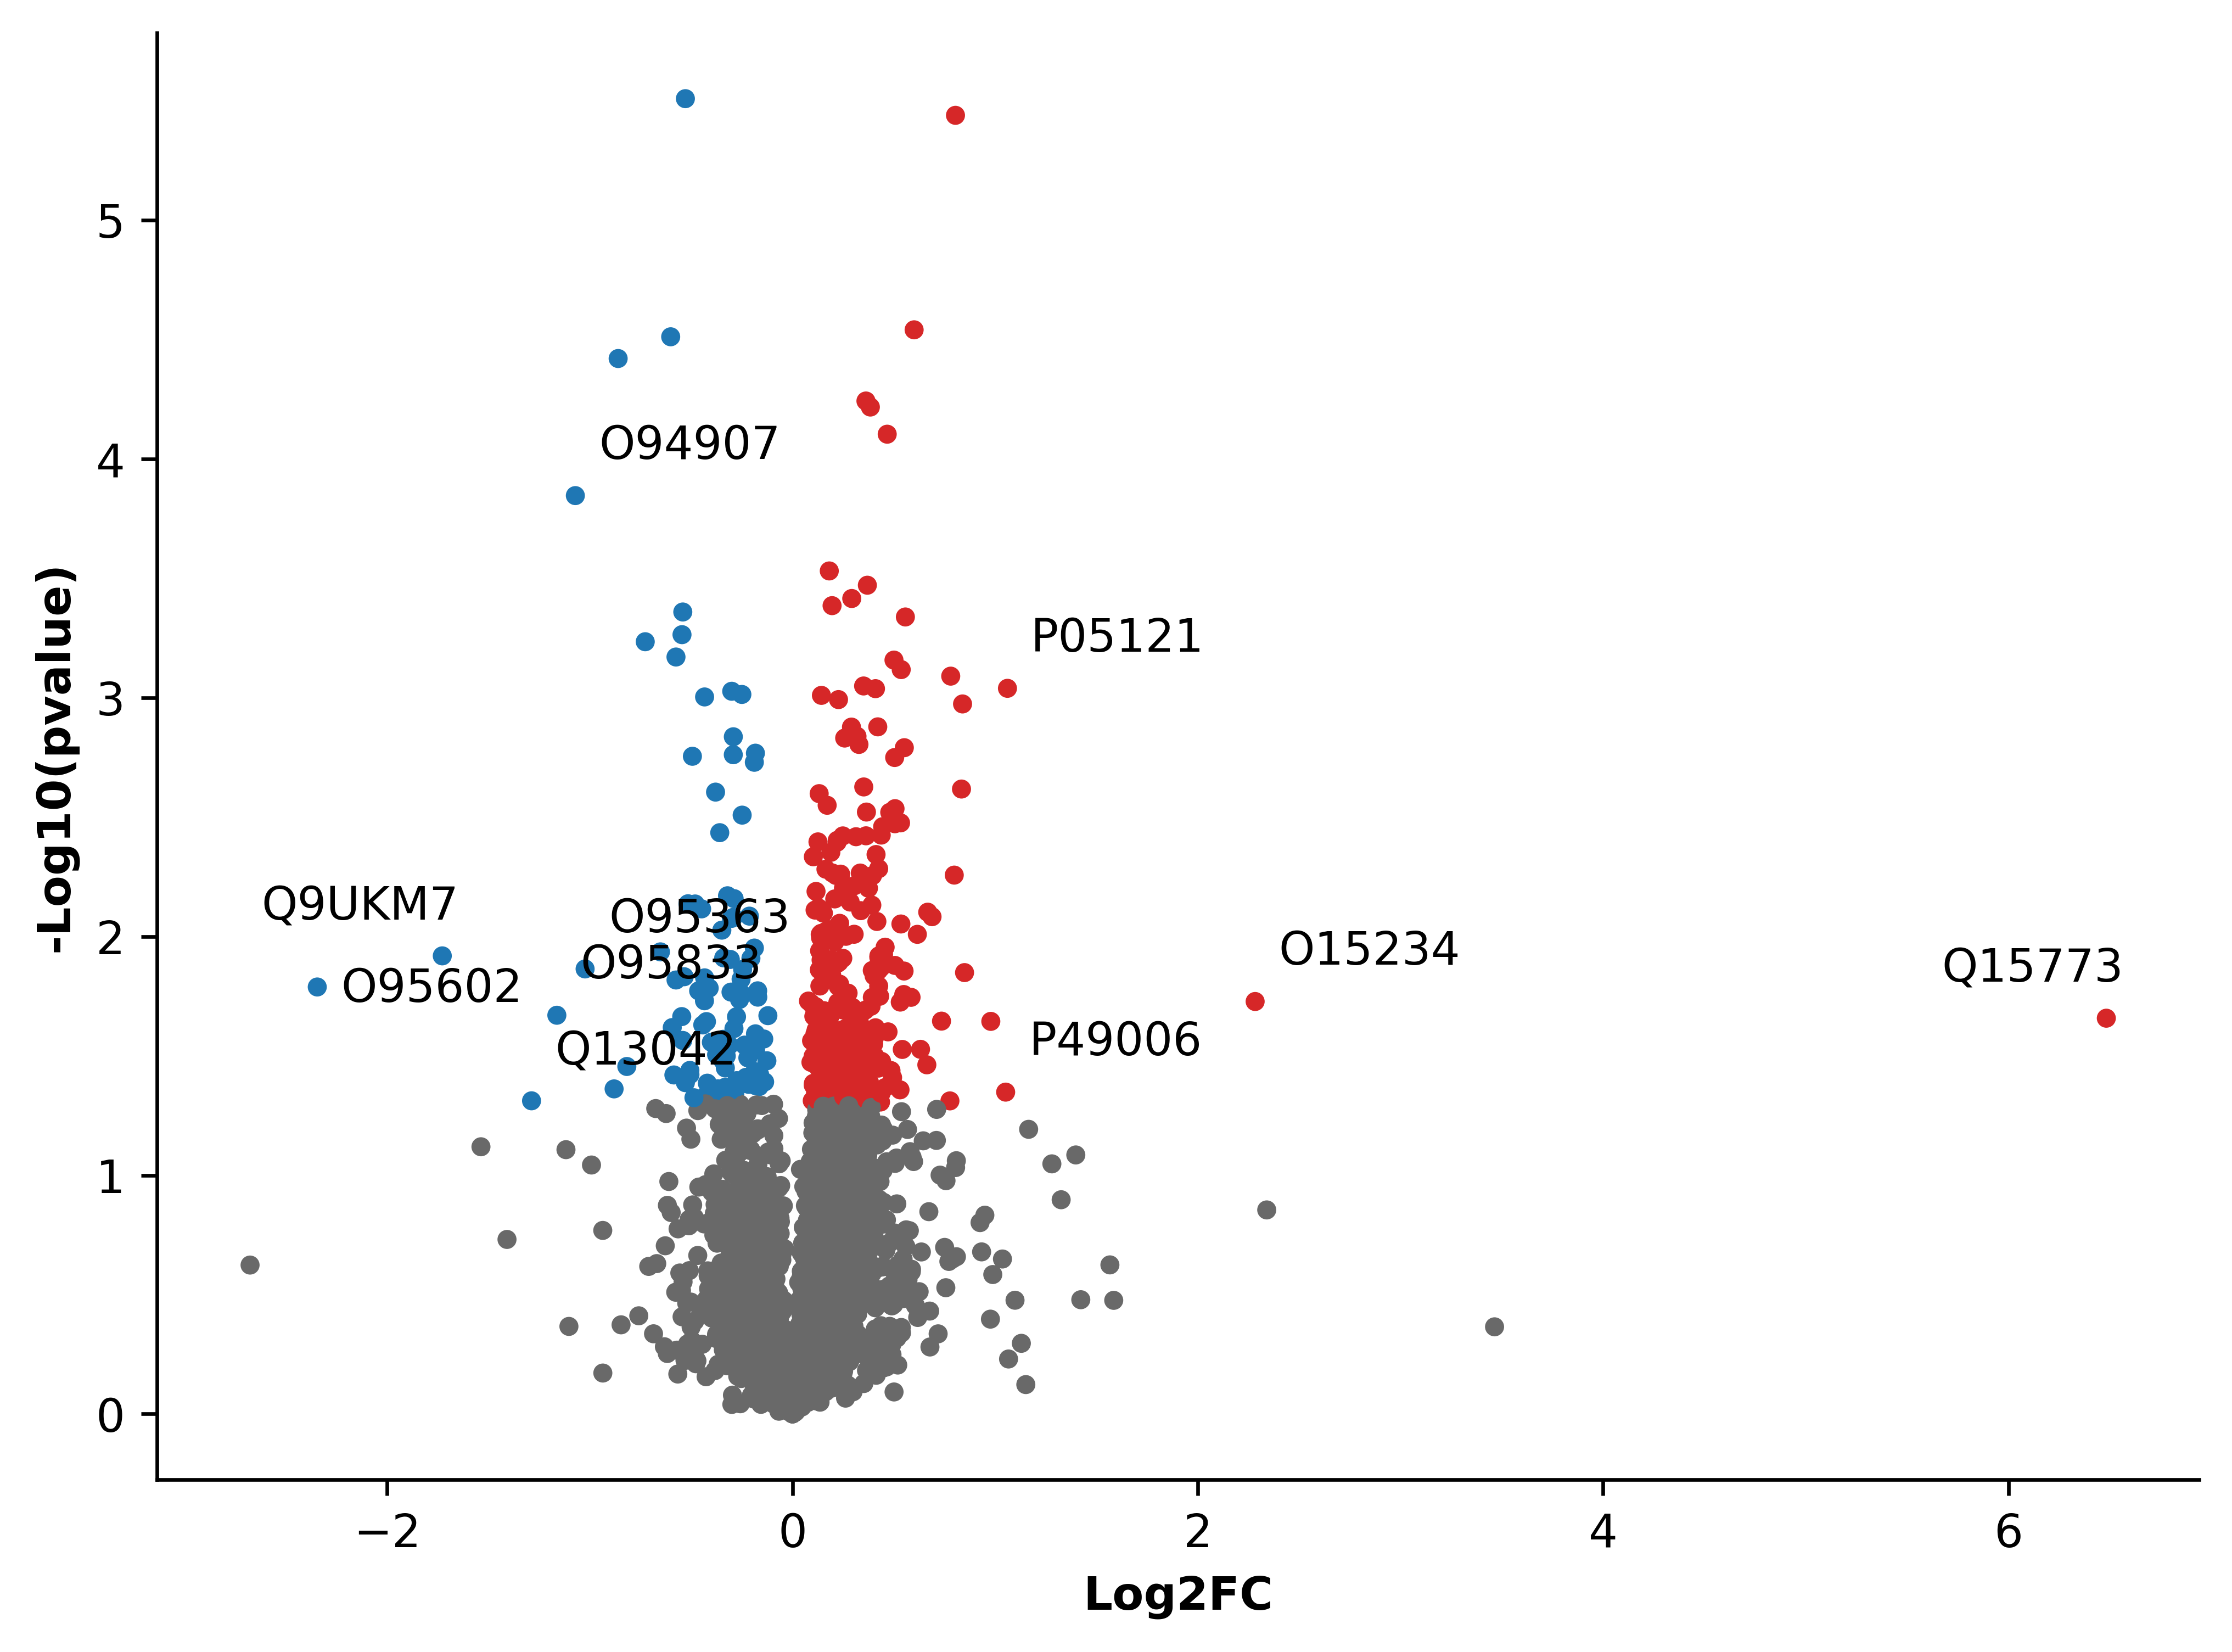

In [82]:
#up, normal, down
quantile_comparison_res['group'] = 'black'
quantile_comparison_res.loc[(quantile_comparison_res['log2FC'] > 0)&(quantile_comparison_res['pvalue'] < 0.05),'group'] = 'tab:red' 
quantile_comparison_res.loc[(quantile_comparison_res['log2FC'] < 0)&(quantile_comparison_res['pvalue'] < 0.05),'group'] = 'tab:blue'
quantile_comparison_res.loc[quantile_comparison_res['pvalue'] >= 0.05,'group'] = 'dimgrey'


xmin=-2
xmax=2
ymin=-2
ymax=10
fig = plt.figure(figsize=(8, 32), dpi=600)
i = 1
for comp in np.unique(quantile_comparison_res['Label']):
    data = quantile_comparison_res[quantile_comparison_res['Label'] == comp]
    ax = fig.add_subplot(410 + i)
#     ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax), title='')
    ax.scatter(data['log2FC'], data["-Log10(p-value)"], s=10, c=data['group'])
    ax.set_ylabel('-Log10(pvalue)',fontweight='bold')
    ax.set_xlabel('Log2FC',fontweight='bold')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False) 
    
#     ax.vlines(-1, ymin, ymax, color='dimgrey',linestyle='dashed', linewidth=1) 
#     ax.vlines(1, ymin, ymax, color='dimgrey',linestyle='dashed', linewidth=1) 
#     ax.hlines(-np.log10(0.05), xmin, xmax, color='dimgrey',linestyle='dashed', linewidth=1)

#     ax.set_xticks(range(-2,2,1)) 
#     ax.set_yticks(range(0,,3)) 
#     ax.set_title(comp)
    i += 1
    t = []
    for _,row in data[(data['group'] != 'dimgrey')&(np.abs(data['log2FC']) > 1)].iterrows():
        t.append(ax.annotate(row['Protein'].split("|")[1], xy = (row['log2FC'], row['-Log10(p-value)']), xytext = (row['log2FC']+0.1, row['-Log10(p-value)']+0.1)))

adjust_text(t, )
plt.subplots_adjust(wspace=0.5,hspace=0.5) 
plt.show()

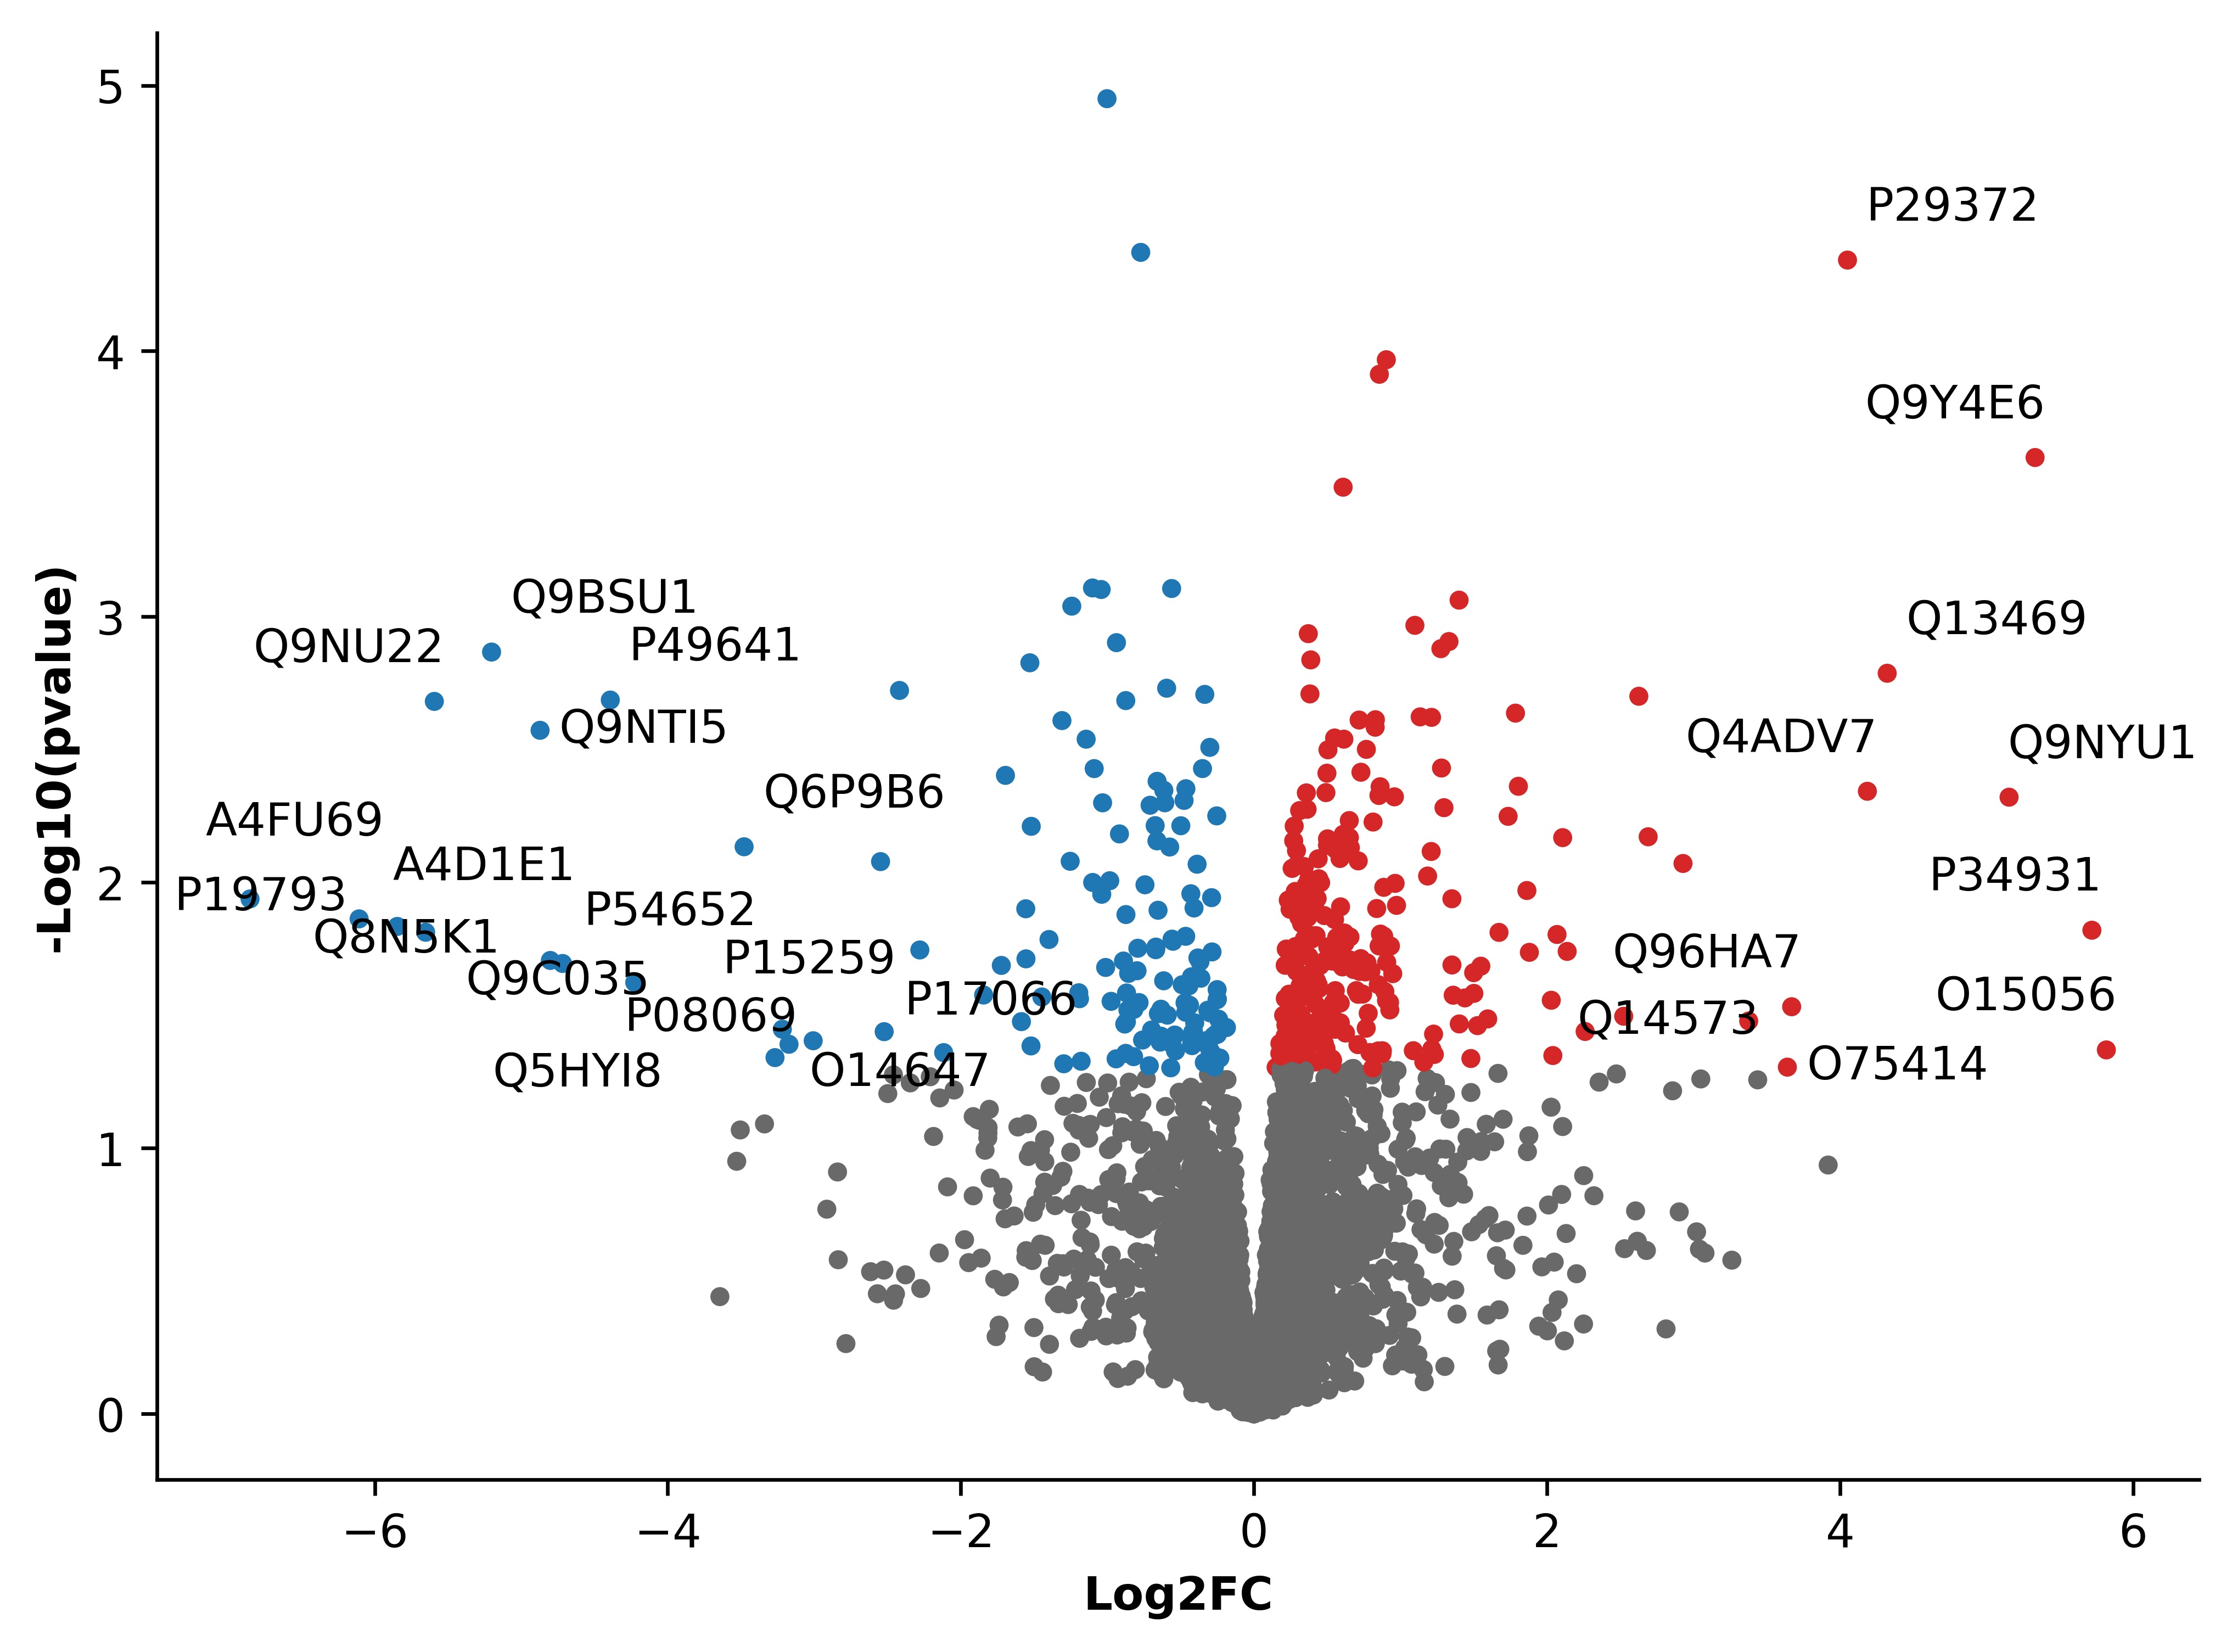

In [81]:
#up, normal, down
prodat_quantile_comp_res['group'] = 'black'
prodat_quantile_comp_res['logFC'] = -prodat_quantile_comp_res['logFC']
prodat_quantile_comp_res.loc[(prodat_quantile_comp_res['logFC'] > 0)&(prodat_quantile_comp_res['P.Value'] < 0.05),'group'] = 'tab:red' 
prodat_quantile_comp_res.loc[(prodat_quantile_comp_res['logFC'] < 0)&(prodat_quantile_comp_res['P.Value'] < 0.05),'group'] = 'tab:blue'
prodat_quantile_comp_res.loc[prodat_quantile_comp_res['P.Value'] >= 0.05,'group'] = 'dimgrey'


xmin=-2
xmax=2
ymin=-2
ymax=10
fig = plt.figure(figsize=(8, 32), dpi=600)
i = 1

data = prodat_quantile_comp_res
ax = fig.add_subplot(410 + i)
#     ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax), title='')
ax.scatter(data['logFC'], data["-Log10(p-value)"], s=10, c=data['group'])
ax.set_ylabel('-Log10(pvalue)',fontweight='bold')
ax.set_xlabel('Log2FC',fontweight='bold')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False) 

i += 1
t = []
for _,row in data[(data['group'] != 'dimgrey')&(np.abs(data['logFC']) > 3)].iterrows():
    t.append(ax.annotate(row['protein'].split("|")[1], xy = (row['logFC'], row['-Log10(p-value)']), xytext = (row['logFC']+0.1, row['-Log10(p-value)']+0.1)))
adjust_text(t,)
plt.subplots_adjust(wspace=0.5,hspace=0.5) 
plt.show()

C:\Users\ChengXin\MyProgram\python\anaconda\pro\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\ChengXin\MyProgram\python\anaconda\pro\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


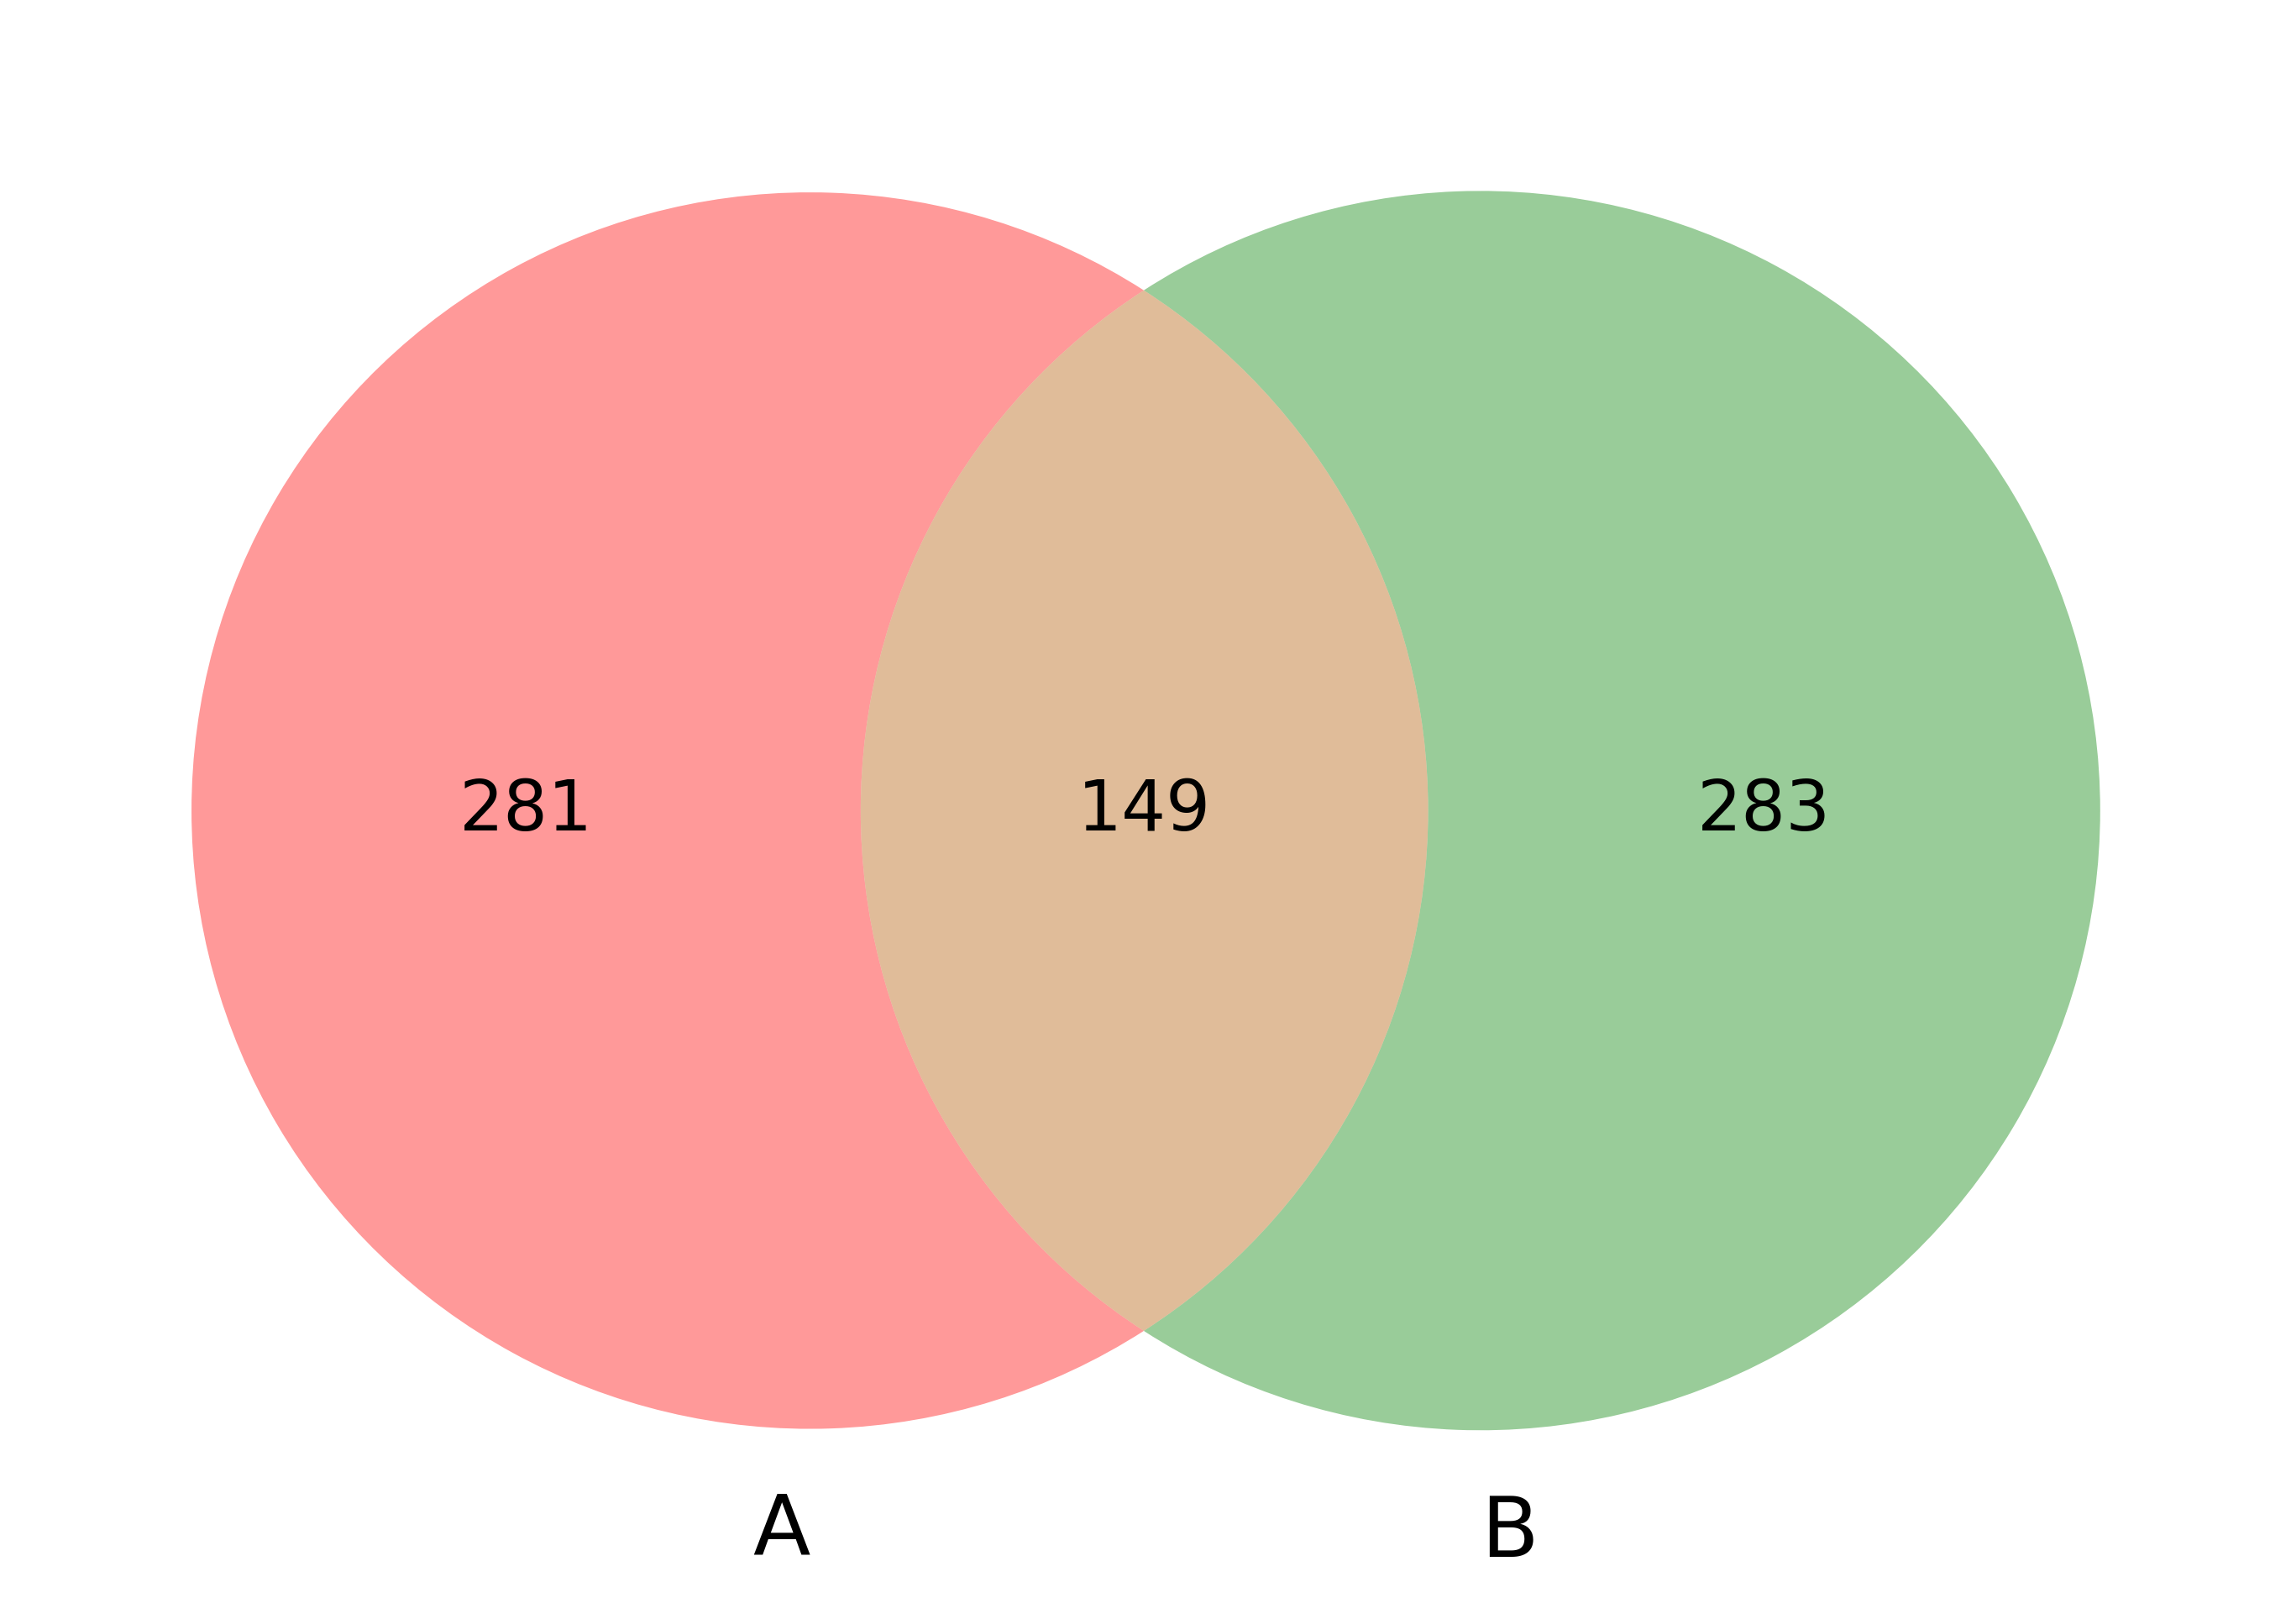

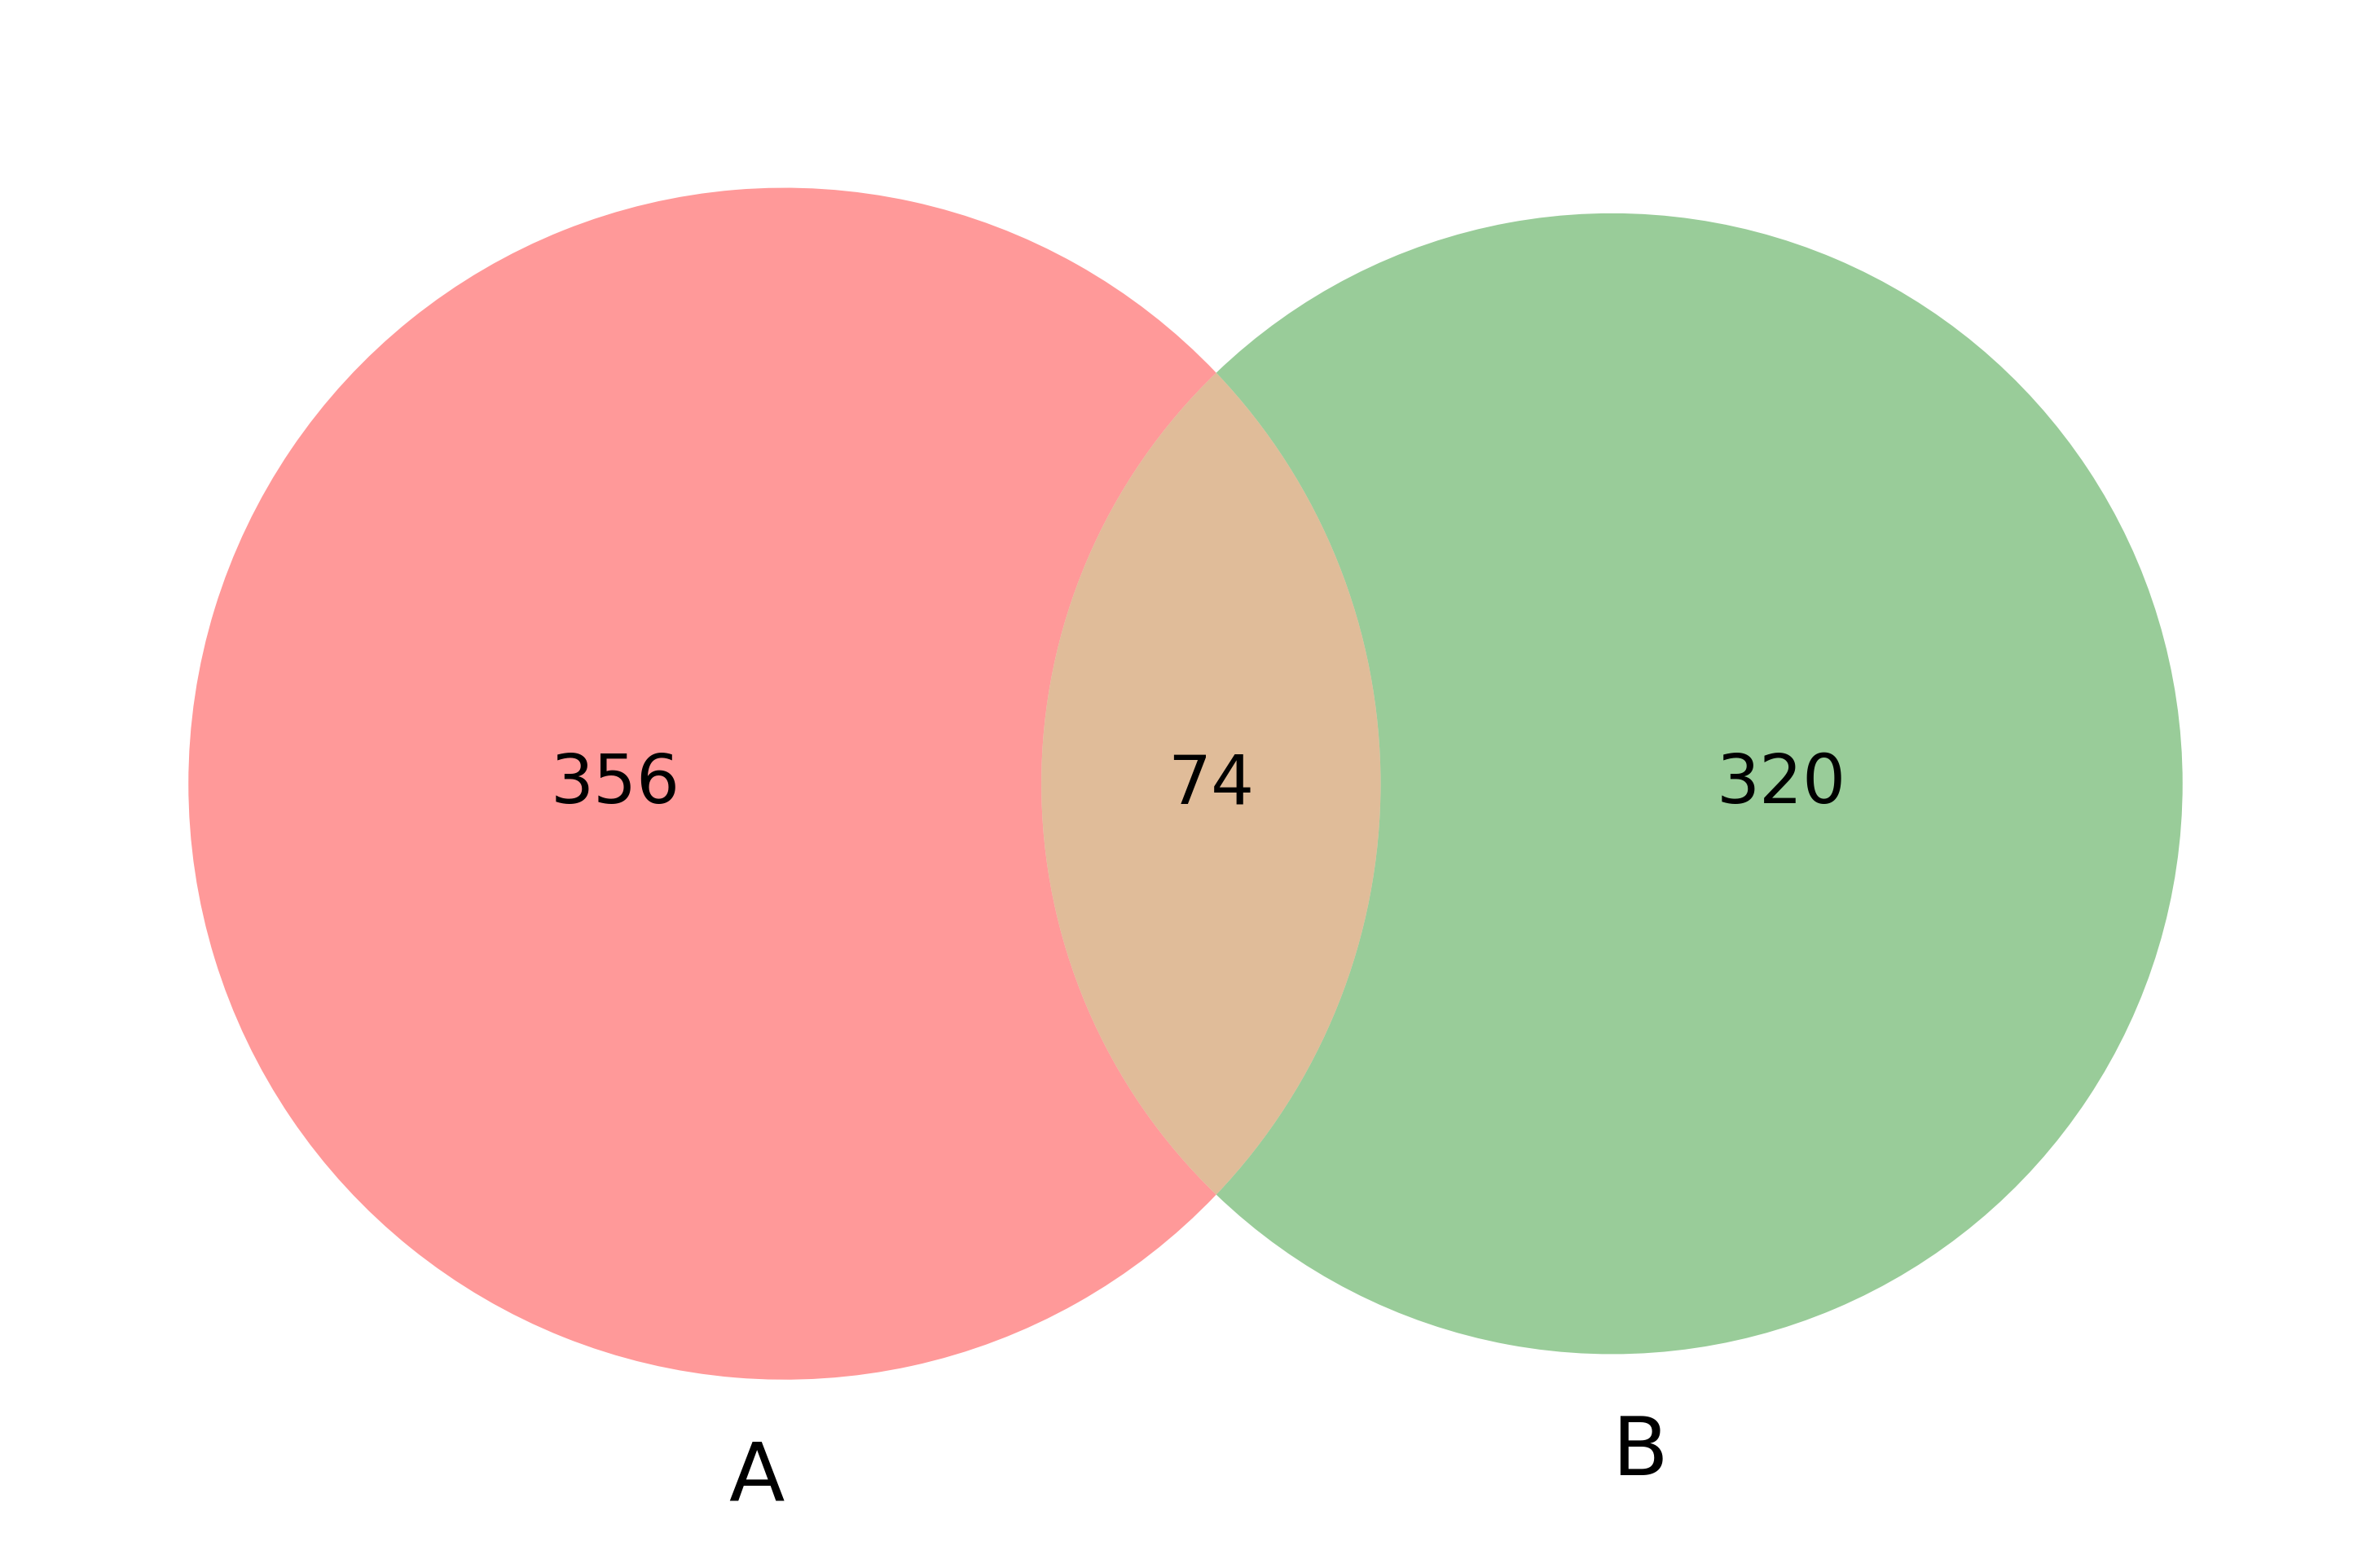

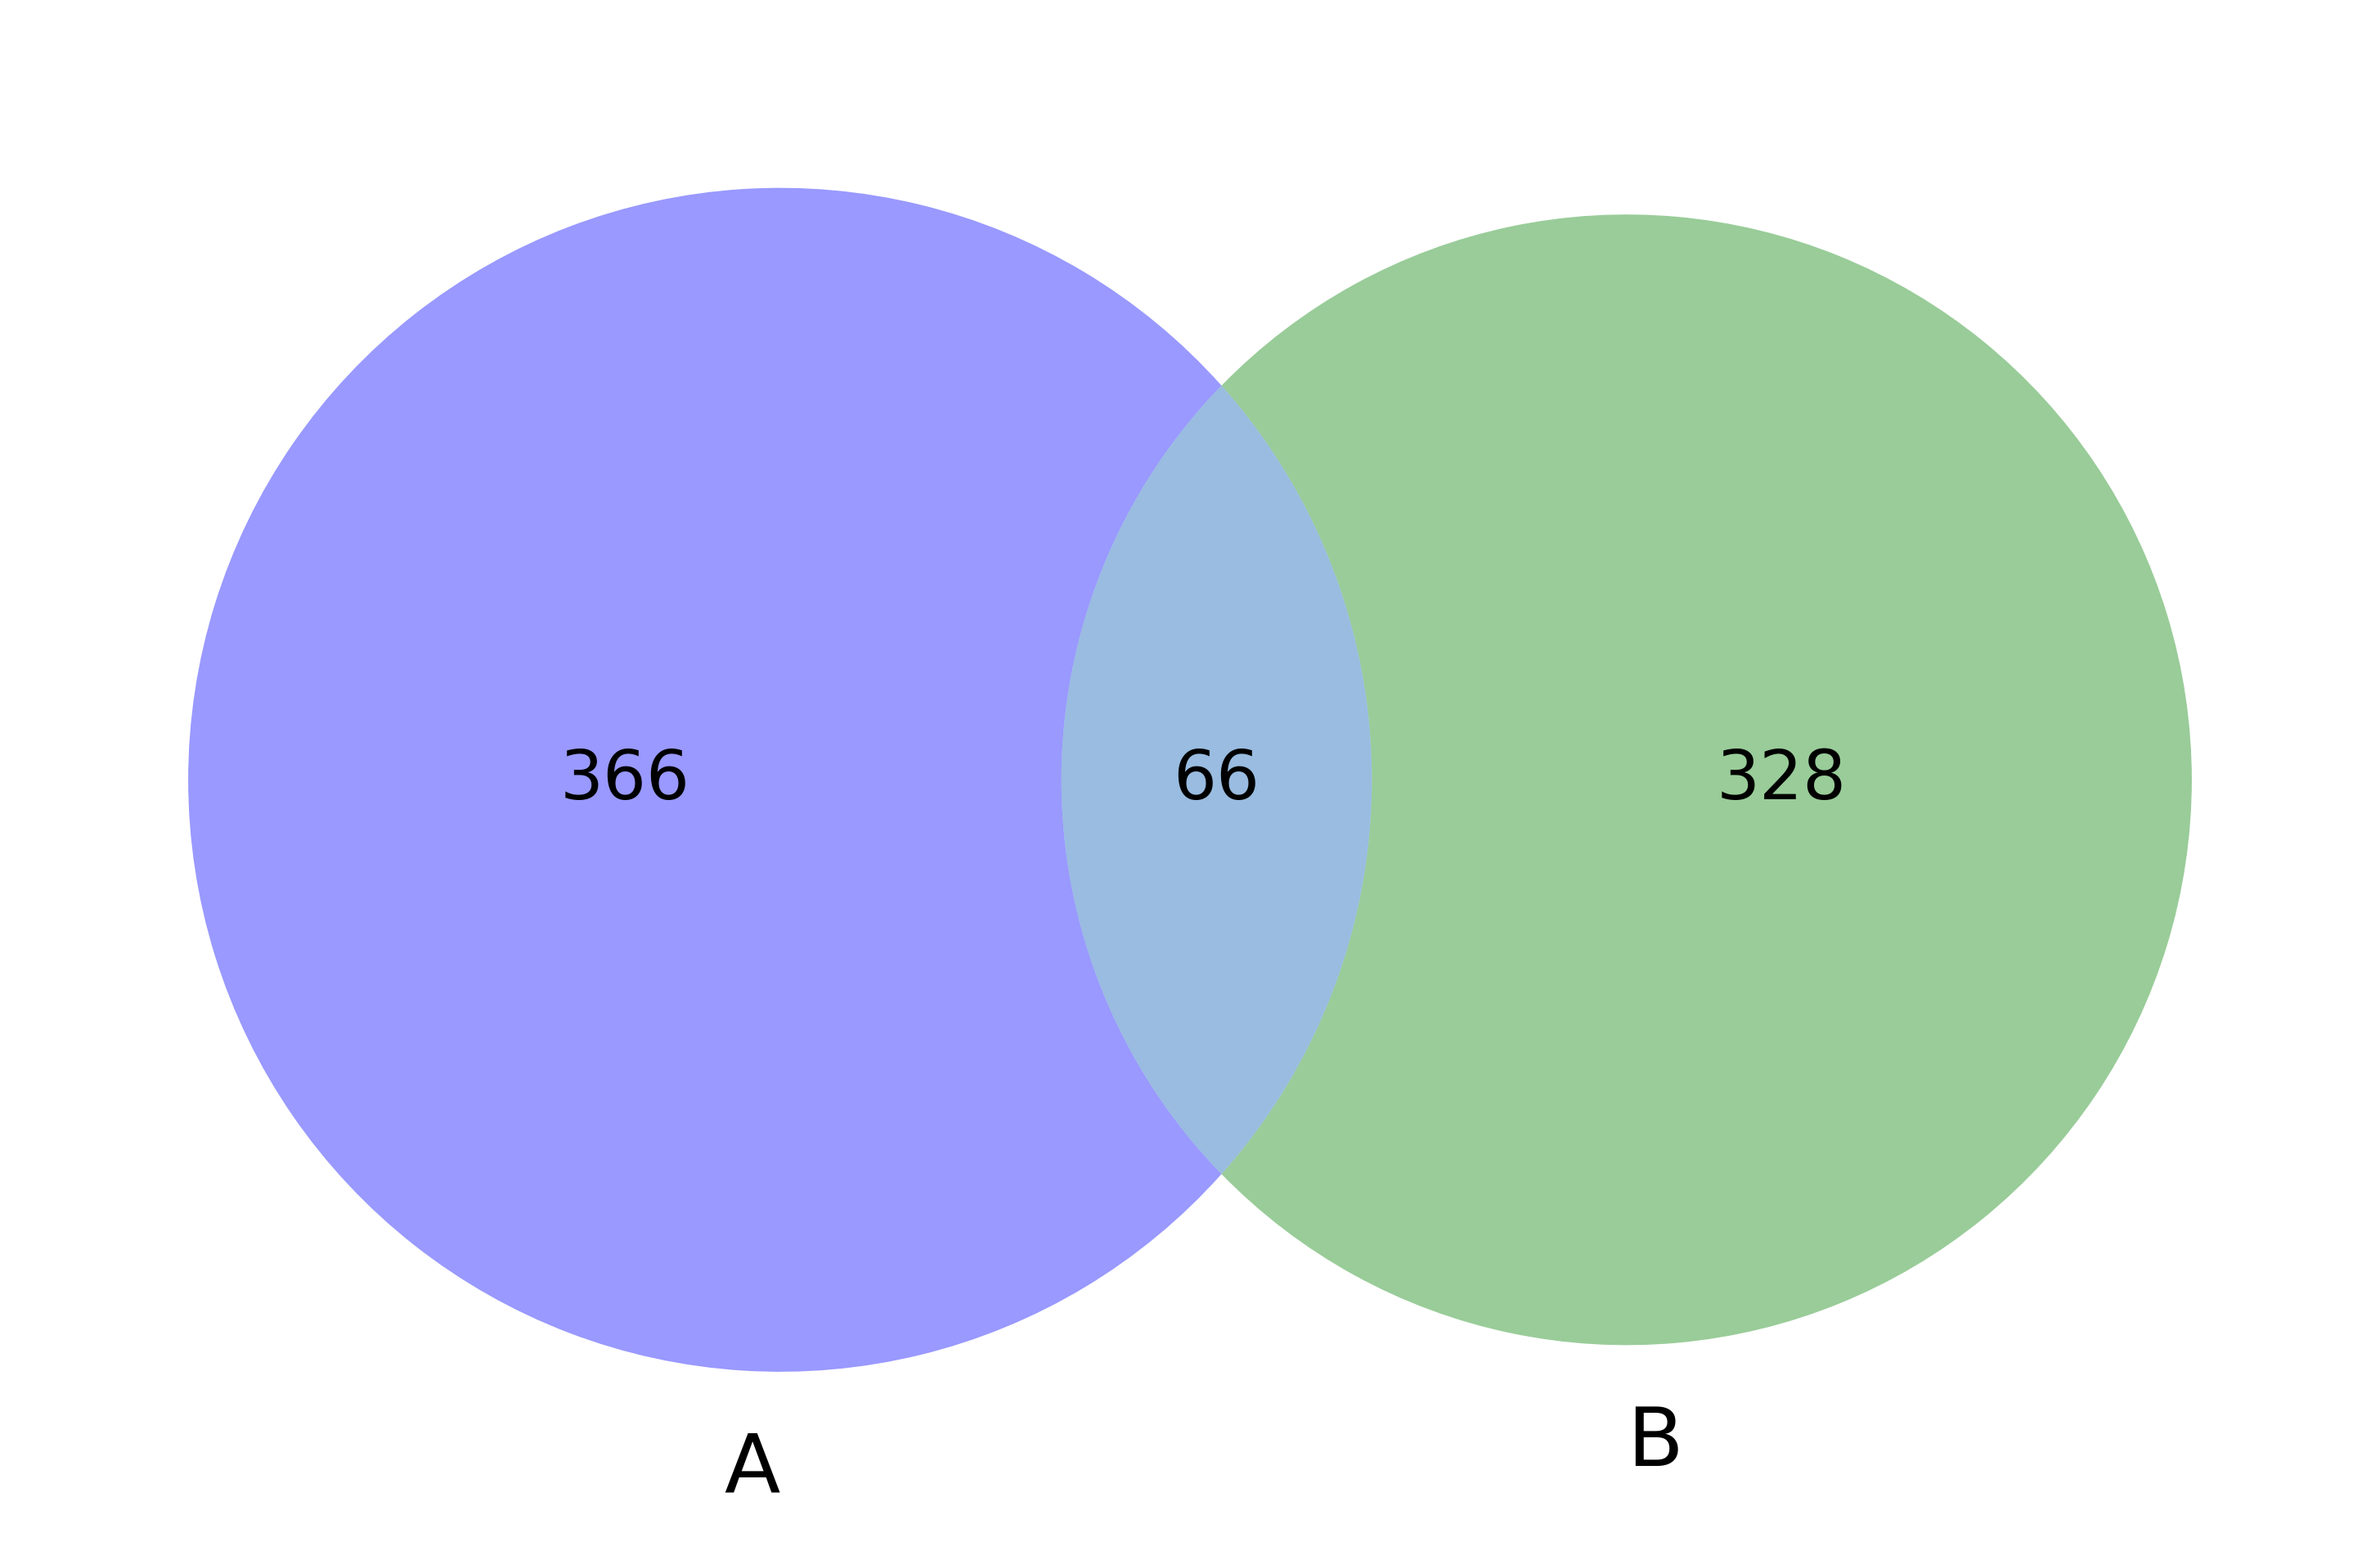

In [7]:
# pvalue < 0.05 and |log2FC| > 0.5
from pyvenn import venn

no_normalization_comparison_res = pd.read_csv('./PXD020248/no_normalization_comparison_res_filter.csv', sep=',')
no_normalization_comparison_res = no_normalization_comparison_res[['Protein', 'Label', 'log2FC', 'pvalue', 'adj.pvalue']].dropna()
no_normalization_comparison_res["-Log10(p-value)"] = -np.log10(no_normalization_comparison_res['pvalue'])
no_normalization_comparison_res_dep = no_normalization_comparison_res[no_normalization_comparison_res["pvalue"] < 0.05]
no_normalization_comparison_res_dep["ProteinEntry"] = no_normalization_comparison_res_dep.apply(lambda x: ";".join(x["Protein"].split("|")[1::2]), axis=1)

prodat_comp_res = pd.read_csv('./PXD020248/prodat_comp_res_filter.csv', sep=',')
prodat_comp_res = prodat_comp_res[['protein', 'logFC', 'adj.P.Val', 'P.Value']].dropna()
prodat_comp_res["-Log10(p-value)"] = -np.log10(prodat_comp_res['P.Value'])
prodat_comp_res_dep = prodat_comp_res[prodat_comp_res["P.Value"] < 0.05]
prodat_comp_res_dep["ProteinEntry"] = prodat_comp_res_dep.apply(lambda x: ";".join(x["protein"].split("|")[1::2]), axis=1)

OriginalResultlfq = pd.read_excel("./PXD020248/1-s2.0-S0300483X20302912-mmc2.xlsx", sheet_name="sTable 1", header=3)
OrginalDEP = OriginalResultlfq[OriginalResultlfq["raw p-value <= 0.05"] == True]

plt.figure(dpi=600)
venn2(subsets=[set(no_normalization_comparison_res_dep['ProteinEntry']), set(prodat_comp_res_dep['ProteinEntry'])], set_colors=("r","g"))
plt.show()

# labels = venn.get_labels([set(prodat_comp_res_dep['ProteinEntry']), set(OrginalDEP['Accession'])])
# fig, ax = venn.venn2(labels, names=["MSstats", "Proteus"],dpi=600)
# plt.show()


plt.figure(dpi=600)
venn2(subsets=[set(no_normalization_comparison_res_dep['ProteinEntry']), set(OrginalDEP['Accession'])], set_colors=("r","g"))
plt.show()

plt.figure(dpi=600)
venn2(subsets=[set(prodat_comp_res_dep['ProteinEntry']), set(OrginalDEP['Accession'])], set_colors=("b","g"))
plt.show()

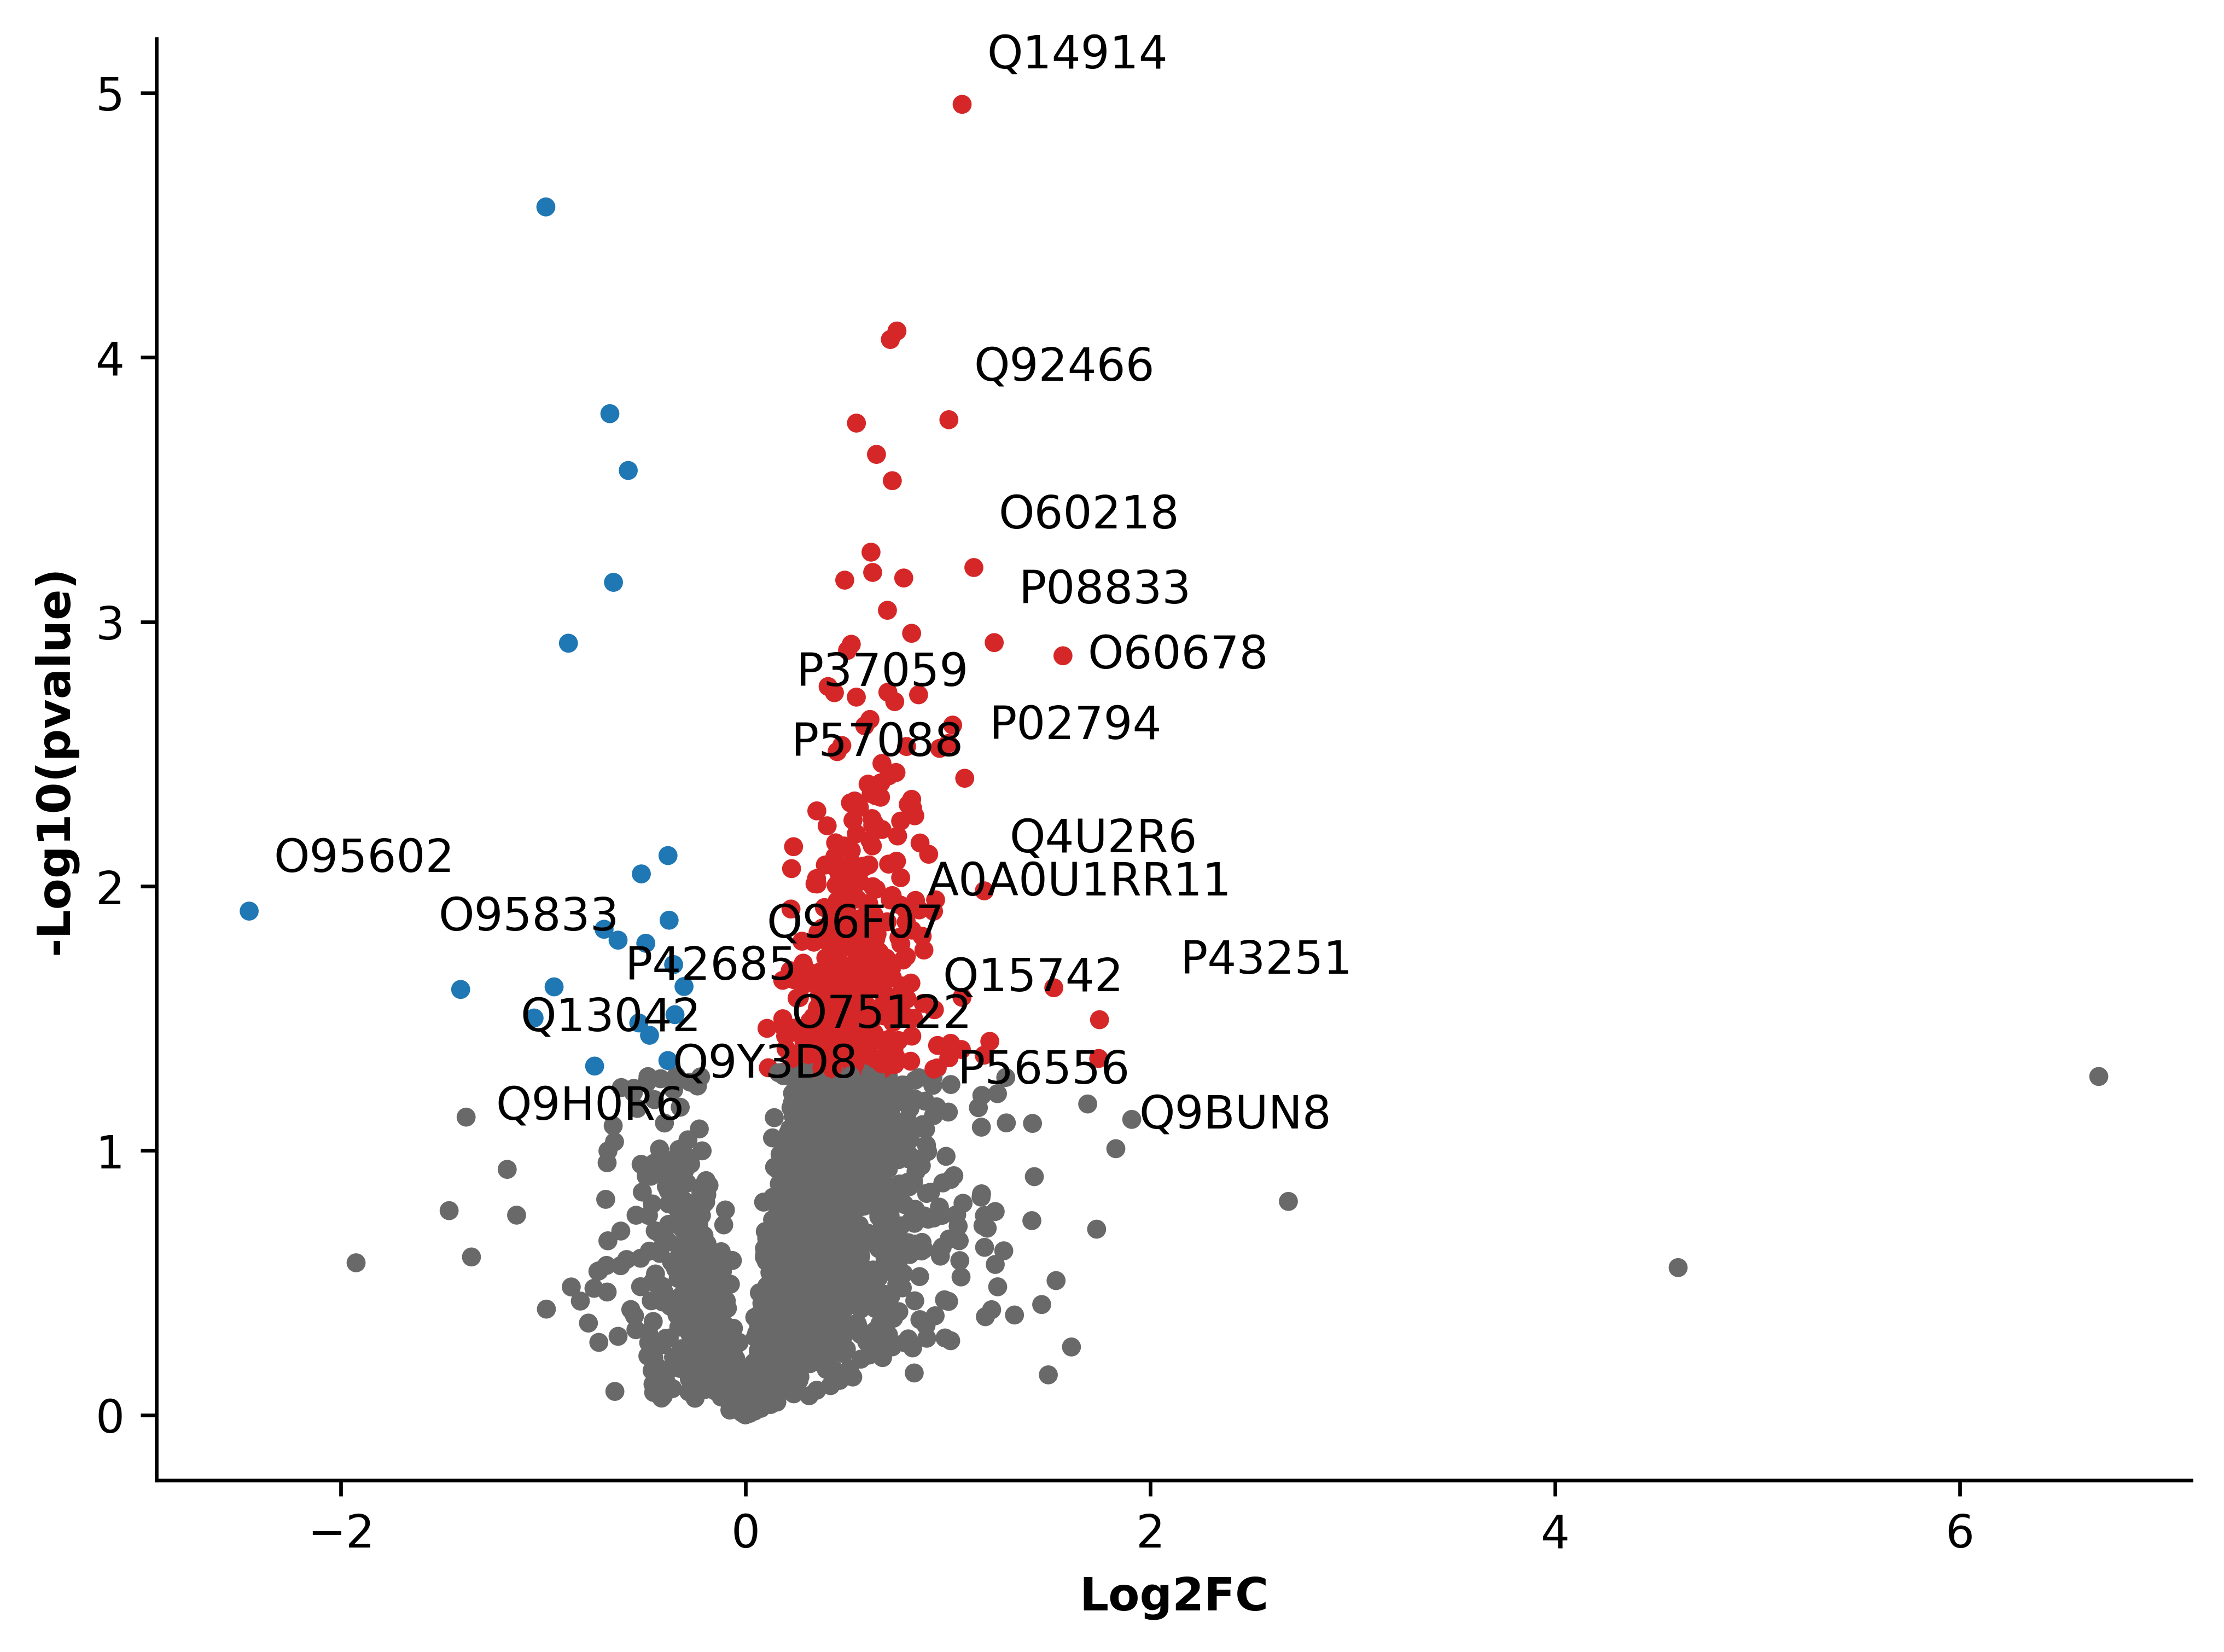

In [77]:
#up, normal, down
no_normalization_comparison_res['group'] = 'black'
no_normalization_comparison_res.loc[(no_normalization_comparison_res['log2FC'] > 0)&(no_normalization_comparison_res['pvalue'] < 0.05),'group'] = 'tab:red' 
no_normalization_comparison_res.loc[(no_normalization_comparison_res['log2FC'] < 0)&(no_normalization_comparison_res['pvalue'] < 0.05),'group'] = 'tab:blue'
no_normalization_comparison_res.loc[no_normalization_comparison_res['pvalue'] >= 0.05,'group'] = 'dimgrey'


xmin=-2
xmax=2
ymin=-2
ymax=10
fig = plt.figure(figsize=(8, 32), dpi=600)
i = 1
for comp in np.unique(no_normalization_comparison_res['Label']):
    data = no_normalization_comparison_res[no_normalization_comparison_res['Label'] == comp]
    ax = fig.add_subplot(410 + i)
#     ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax), title='')
    ax.scatter(data['log2FC'], data["-Log10(p-value)"], s=10, c=data['group'])
    ax.set_ylabel('-Log10(pvalue)',fontweight='bold')
    ax.set_xlabel('Log2FC',fontweight='bold')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False) 
    
#     ax.vlines(-1, ymin, ymax, color='dimgrey',linestyle='dashed', linewidth=1) 
#     ax.vlines(1, ymin, ymax, color='dimgrey',linestyle='dashed', linewidth=1) 
#     ax.hlines(-np.log10(0.05), xmin, xmax, color='dimgrey',linestyle='dashed', linewidth=1)

#     ax.set_xticks(range(-2,2,1)) 
#     ax.set_yticks(range(0,,3)) 
#     ax.set_title(comp)
    i += 1
    t = []
    for _,row in data[(data['group'] != 'dimgrey')&(np.abs(data['log2FC']) > 1)].iterrows():
        t.append(ax.annotate(row['Protein'].split("|")[1], xy = (row['log2FC'], row['-Log10(p-value)']), xytext = (row['log2FC'] + 0.1, row['-Log10(p-value)'] + 0.1)))
        
adjust_text(t)
plt.subplots_adjust(wspace=0.5,hspace=0.5) 
plt.show()

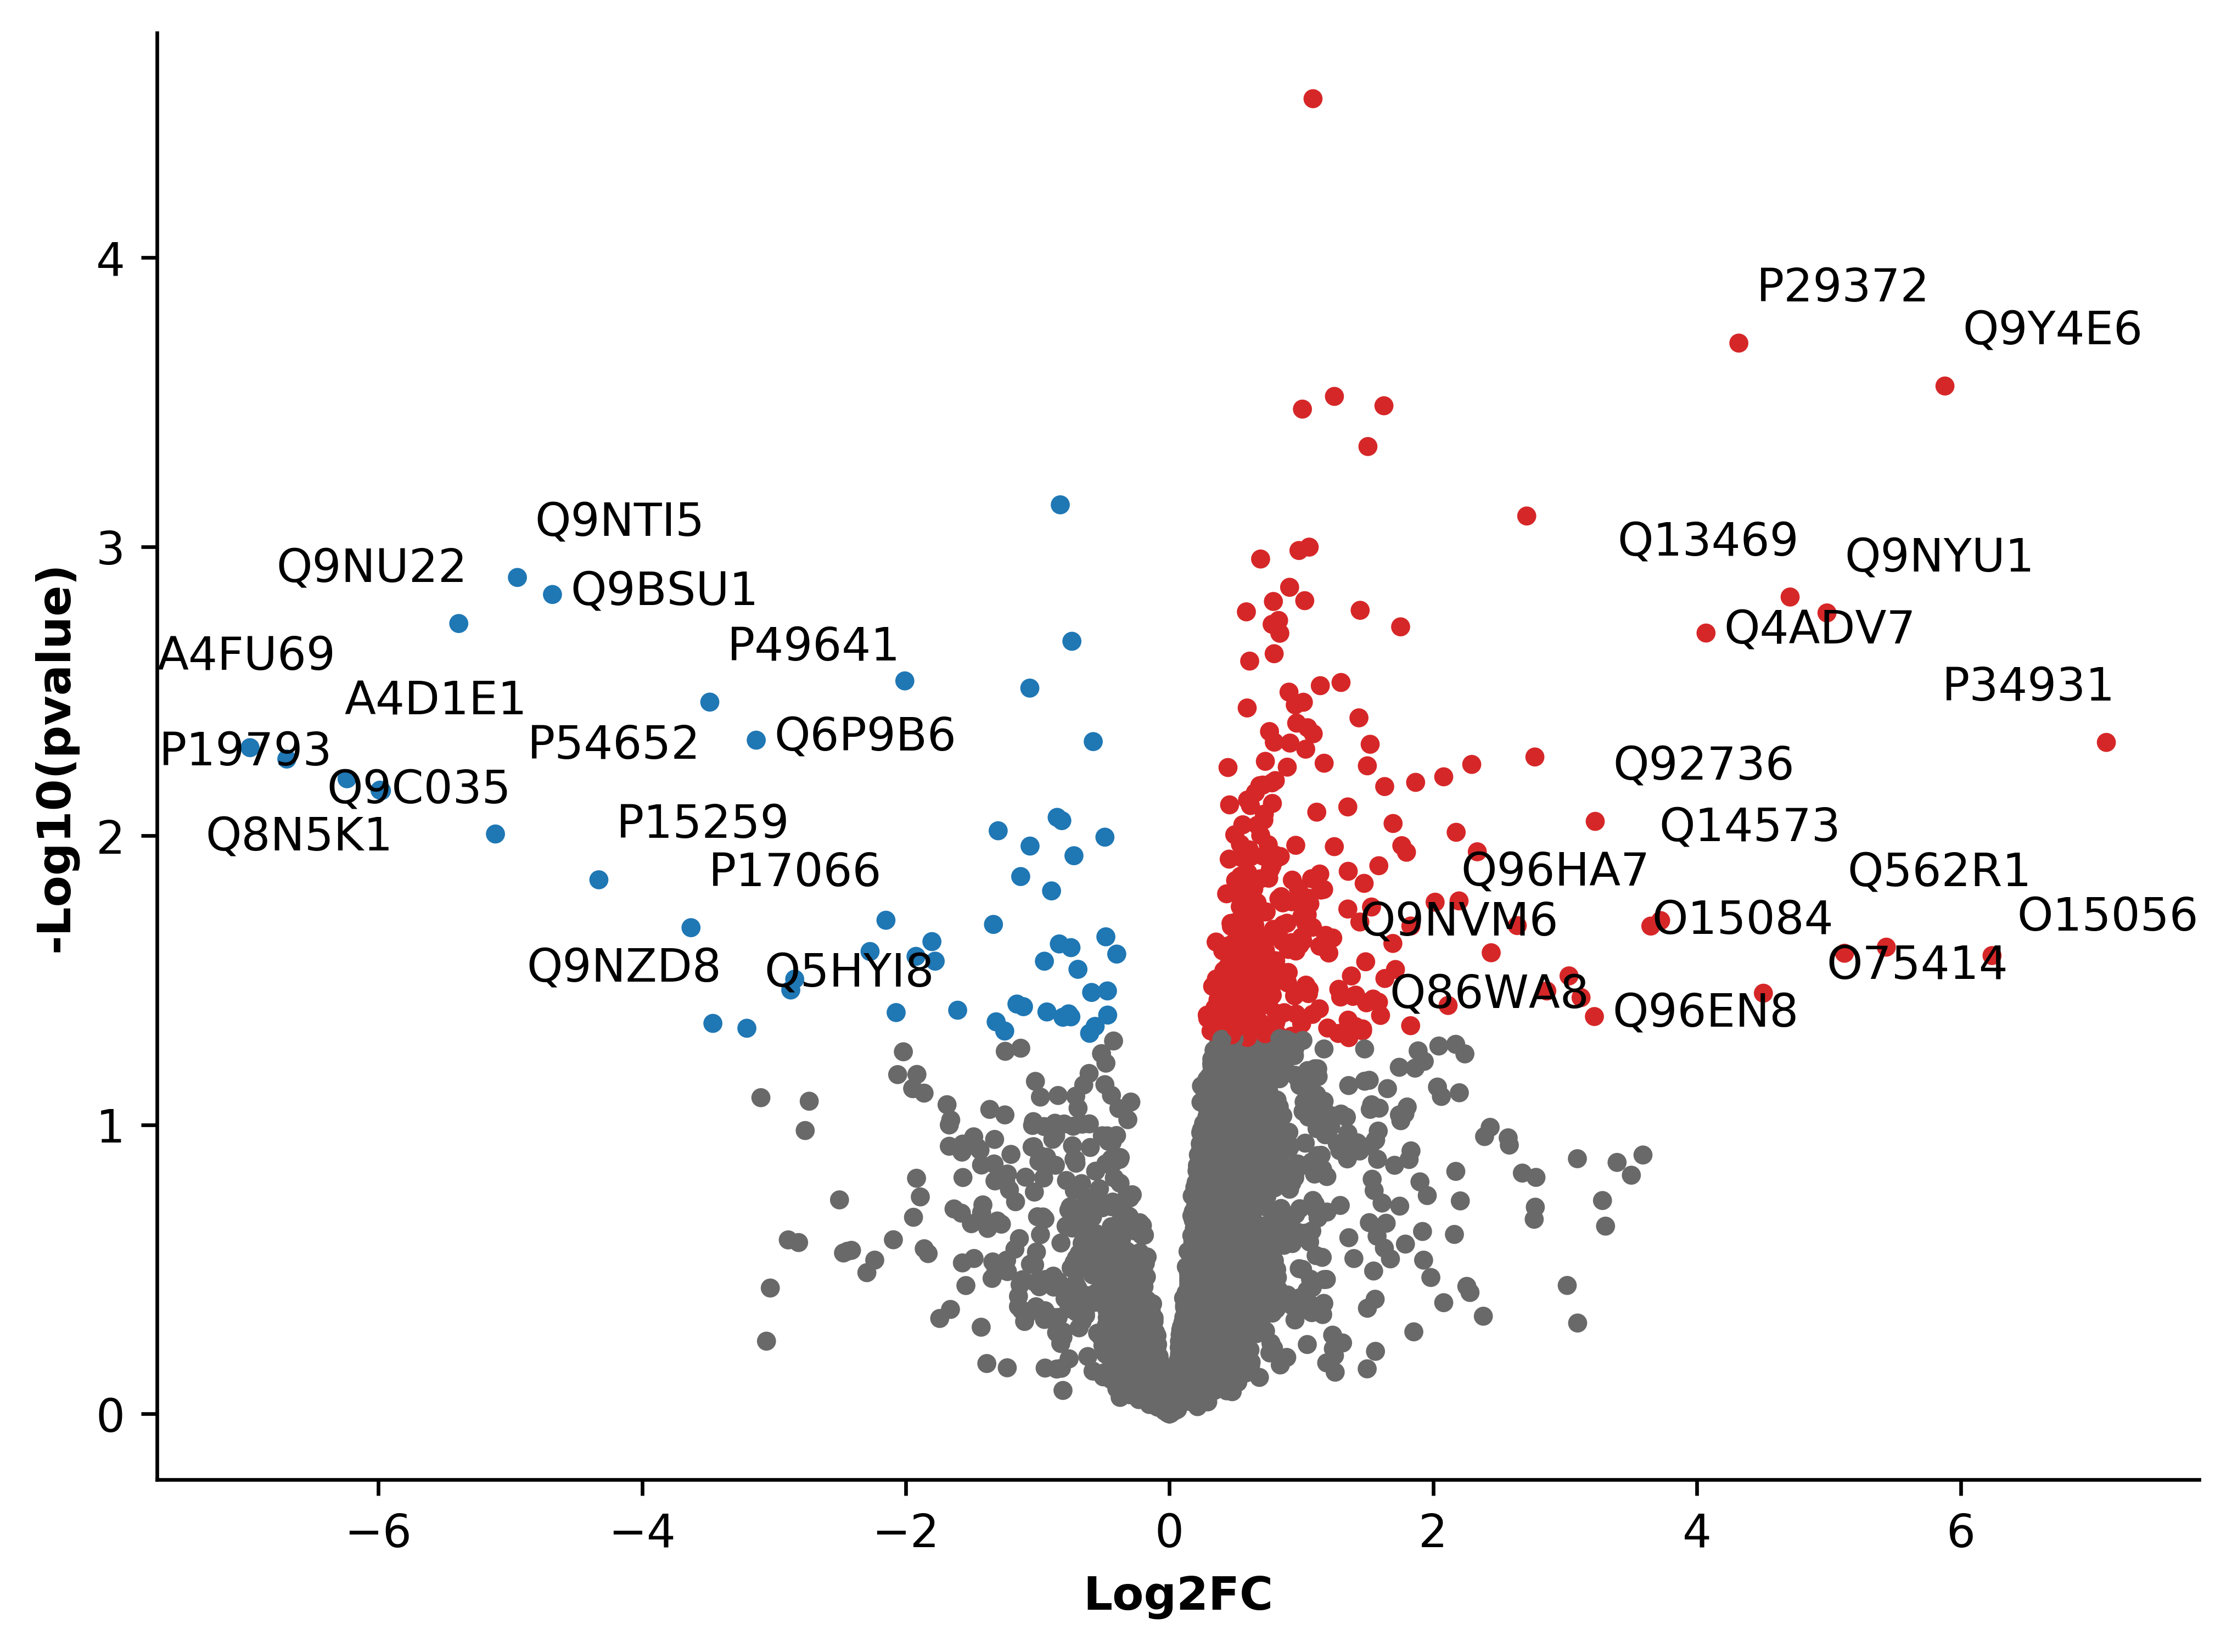

In [78]:
#up, normal, down
prodat_comp_res['group'] = 'black'
prodat_comp_res['logFC'] = -prodat_comp_res['logFC']
prodat_comp_res.loc[(prodat_comp_res['logFC'] > 0)&(prodat_comp_res['P.Value'] < 0.05),'group'] = 'tab:red' 
prodat_comp_res.loc[(prodat_comp_res['logFC'] < 0)&(prodat_comp_res['P.Value'] < 0.05),'group'] = 'tab:blue'
prodat_comp_res.loc[prodat_comp_res['P.Value'] >= 0.05,'group'] = 'dimgrey'
from adjustText import adjust_text

xmin=-2
xmax=2
ymin=-2
ymax=10
fig = plt.figure(figsize=(8, 32), dpi=600)
i = 1

data = prodat_comp_res
ax = fig.add_subplot(410 + i)
#     ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax), title='')
ax.scatter(data['logFC'], data["-Log10(p-value)"], s=10, c=data['group'])
ax.set_ylabel('-Log10(pvalue)',fontweight='bold')
ax.set_xlabel('Log2FC',fontweight='bold')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False) 

i += 1
t =[]
for _,row in data[(data['group'] != 'dimgrey')&(np.abs(data['logFC']) > 3)].iterrows():
    t.append(ax.annotate(row['protein'].split("|")[1], xy = (row['logFC'], row['-Log10(p-value)']), xytext = (row['logFC']+0.1, row['-Log10(p-value)']+0.1)))

adjust_text(t,)
plt.subplots_adjust(wspace=0.5,hspace=0.5) 
plt.show()

### Study the those proteins in proteus that are not in msstats

In [78]:
quantms_em_protein_expression = pd.read_csv("./PXD020248/protein_expression.csv", header=0, sep=",")
prodatmed = pd.read_csv("./PXD020248/prodatmed.csv", index_col=0)

prodatmed = prodatmed.dropna(how="all")

quantified_both_proteins = set(quantms_em_protein_expression["Protein"]).intersection(set(prodatmed.index))
print(len(quantified_both_proteins))

only_quantified_MSstats = set(quantms_em_protein_expression["Protein"]) - set(prodatmed.index)
print(len(only_quantified_MSstats))

only_quantified_proteus = set(prodatmed.index) - set(quantms_em_protein_expression["Protein"])
print(len(only_quantified_proteus))

4208
0
288


In [81]:
only_quantified_proteus

{'sp|A0A0B4J2D5|GAL3B_HUMAN;sp|P0DPI2|GAL3A_HUMAN',
 'sp|A4D1E1|Z804B_HUMAN',
 'sp|A4FU69|EFCB5_HUMAN',
 'sp|A8MWD9|RUXGL_HUMAN;sp|P62308|RUXG_HUMAN',
 'sp|B7ZAP0|RBG10_HUMAN',
 'sp|E9PAV3|NACAM_HUMAN;sp|Q13765|NACA_HUMAN',
 'sp|O00142|KITM_HUMAN',
 'sp|O00160|MYO1F_HUMAN',
 'sp|O00257|CBX4_HUMAN',
 'sp|O14640|DVL1_HUMAN;sp|P54792|DVLP1_HUMAN',
 'sp|O14772|FPGT_HUMAN',
 'sp|O14950|ML12B_HUMAN;sp|P19105|ML12A_HUMAN',
 'sp|O14975|S27A2_HUMAN',
 'sp|O15056|SYNJ2_HUMAN',
 'sp|O43663|PRC1_HUMAN',
 'sp|O60503|ADCY9_HUMAN',
 'sp|O60825|F262_HUMAN',
 'sp|O60830|TI17B_HUMAN',
 'sp|O75330|HMMR_HUMAN',
 'sp|O75354|ENTP6_HUMAN',
 'sp|O75438|NDUB1_HUMAN',
 'sp|O75503|CLN5_HUMAN',
 'sp|O75648|MTU1_HUMAN',
 'sp|O75781|PALM_HUMAN',
 'sp|O75787|RENR_HUMAN',
 'sp|O94913|PCF11_HUMAN',
 'sp|O94916|NFAT5_HUMAN',
 'sp|O95197|RTN3_HUMAN',
 'sp|O95219|SNX4_HUMAN',
 'sp|O95248|MTMR5_HUMAN',
 'sp|O95249|GOSR1_HUMAN',
 'sp|O95292|VAPB_HUMAN',
 'sp|O95707|RPP29_HUMAN',
 'sp|O95832|CLD1_HUMAN',
 'sp|O95900|TRUB2_H

In [84]:
%%R
quantms.proposed$FeatureLevelData[which(quantms.proposed$FeatureLevelData$PROTEIN=="sp|Q9NYV6|RRN3_HUMAN"),]

 [1] PROTEIN      PEPTIDE      TRANSITION   FEATURE      LABEL       
 [6] GROUP        RUN          SUBJECT      FRACTION     originalRUN 
[11] censored     INTENSITY    ABUNDANCE    newABUNDANCE predicted   
<0 rows> (or 0-length row.names)


In [83]:
%%R
quantms.proposed$ProteinLevelData[which(quantms.proposed$ProteinLevelData$Protein=="sp|Q9NYV6|RRN3_HUMAN"),]


 [1] RUN                    Protein                LogIntensities        
 [4] originalRUN            GROUP                  SUBJECT               
 [7] TotalGroupMeasurements NumMeasuredFeature     MissingPercentage     
[10] more50missing          NumImputedFeature     
<0 rows> (or 0-length row.names)


In [75]:
%%R

head(quantms.proposed$ProteinLevelData)

  RUN               Protein LogIntensities         originalRUN   GROUP SUBJECT
1   1 sp|A0AV96|RBM47_HUMAN       22.02500      BaP_1_1_merged     BaP       1
2   3 sp|A0AV96|RBM47_HUMAN       21.69592      BaP_3_5_merged     BaP       3
3   4 sp|A0AV96|RBM47_HUMAN       22.15484      BaP_4_7_merged     BaP       4
4   5 sp|A0AV96|RBM47_HUMAN       21.99329      BaP_5_9_merged     BaP       5
5   6 sp|A0AV96|RBM47_HUMAN       22.08951     BaP_6_11_merged     BaP       6
6   8 sp|A0AV96|RBM47_HUMAN       21.66122 Control_8_15_merged Control       8
  TotalGroupMeasurements NumMeasuredFeature MissingPercentage more50missing
1                     12                  1               0.5          TRUE
2                     12                  1               0.5          TRUE
3                     12                  2               0.0         FALSE
4                     12                  1               0.5          TRUE
5                     12                  2               0.0      

In [91]:
em_comparison_res = pd.read_csv('./PXD020248/filter_em_comparison_res.csv', sep=',')
em_comparison_res = em_comparison_res.dropna(subset=["pvalue"])
quantile_comparison_res = pd.read_csv('./PXD020248/quantile_comparison_res_filter.csv', sep=',')
quantile_comparison_res = quantile_comparison_res.dropna(subset=["pvalue"])
no_normalization_comparison_res = pd.read_csv('./PXD020248/no_normalization_comparison_res_filter.csv', sep=',')
no_normalization_comparison_res = no_normalization_comparison_res.dropna(subset=["pvalue"])

prodat_med_comp_res = pd.read_csv('./PXD020248/prodat_med_comp_res_filter.csv', sep=',')
prodat_med_comp_res = prodat_med_comp_res.dropna(subset=["adj.P.Val"])
prodat_quantile_comp_res = pd.read_csv('./PXD020248/prodat_quantile_comp_res_filter.csv', sep=',')
prodat_quantile_comp_res = prodat_quantile_comp_res.dropna(subset=["adj.P.Val"])
prodat_comp_res = pd.read_csv('./PXD020248/prodat_comp_res_filter.csv', sep=',')
prodat_comp_res = prodat_comp_res.dropna(subset=["adj.P.Val"])


In [151]:
c1 = em_comparison_res[em_comparison_res["pvalue"] < 0.2]["Protein"]
c2 = quantile_comparison_res[quantile_comparison_res["pvalue"] < 0.2]["Protein"]
c3 = no_normalization_comparison_res[no_normalization_comparison_res["pvalue"] < 0.2]["Protein"]
c4 = prodat_med_comp_res[prodat_med_comp_res["P.Value"] < 0.2]["protein"]
c5 = prodat_quantile_comp_res[prodat_quantile_comp_res["P.Value"] < 0.2]["protein"]
c6 = prodat_comp_res[prodat_comp_res["P.Value"] < 0.2]["protein"]
c = set(c1).intersection(set(c2))
c = c.intersection(set(c3))
c = c.intersection(set(c4))
c = c.intersection(set(c5))
c = c.intersection(set(c6))
print(c)

{'sp|Q9NQ55|SSF1_HUMAN', 'sp|Q14739|LBR_HUMAN', 'sp|Q9Y619|ORNT1_HUMAN', 'sp|Q9Y4W2|LAS1L_HUMAN', 'sp|Q14517|FAT1_HUMAN', 'sp|Q8IYM9|TRI22_HUMAN', 'sp|Q9UBT2|SAE2_HUMAN', 'sp|P62760|VISL1_HUMAN', 'sp|P37837|TALDO_HUMAN', 'sp|P16615|AT2A2_HUMAN', 'sp|P51648|AL3A2_HUMAN', 'sp|Q96BJ3|AIDA_HUMAN', 'sp|Q9NYJ1|COA4_HUMAN', 'sp|Q9UKG1|DP13A_HUMAN', 'sp|P38571|LICH_HUMAN', 'sp|O15460|P4HA2_HUMAN', 'sp|Q14914|PTGR1_HUMAN', 'sp|Q86TG7|PEG10_HUMAN', 'sp|Q9UHD4|CIDEB_HUMAN', 'sp|P30043|BLVRB_HUMAN', 'sp|P62701|RS4X_HUMAN', 'sp|O15031|PLXB2_HUMAN', 'sp|Q14790|CASP8_HUMAN', 'sp|P60709|ACTB_HUMAN', 'sp|P12081|HARS1_HUMAN', 'sp|P38435|VKGC_HUMAN', 'sp|P10606|COX5B_HUMAN', 'sp|P39656|OST48_HUMAN', 'sp|O75844|FACE1_HUMAN', 'sp|Q9UHB6|LIMA1_HUMAN', 'sp|Q9BUR4|TCAB1_HUMAN', 'sp|Q9Y289|SC5A6_HUMAN', 'sp|Q9UPN6|SCAF8_HUMAN', 'sp|Q5JTV8|TOIP1_HUMAN', 'sp|P40123|CAP2_HUMAN', 'sp|Q14126|DSG2_HUMAN', 'sp|O43670|ZN207_HUMAN', 'sp|Q8N4Q0|PTGR3_HUMAN', 'sp|Q9NVU0|RPC5_HUMAN', 'sp|Q96EN8|MOCOS_HUMAN', 'sp|O43795|MY

In [155]:
tem = no_normalization_comparison_res[no_normalization_comparison_res["pvalue"] < 0.01]
j= len(tem[(tem["Protein"].isin(c))])
print(j)

tem = prodat_comp_res[prodat_comp_res["P.Value"] < 0.01]
j= len(tem[(tem["protein"].isin(c))])
j

48


39

(-0.01, 0.2)

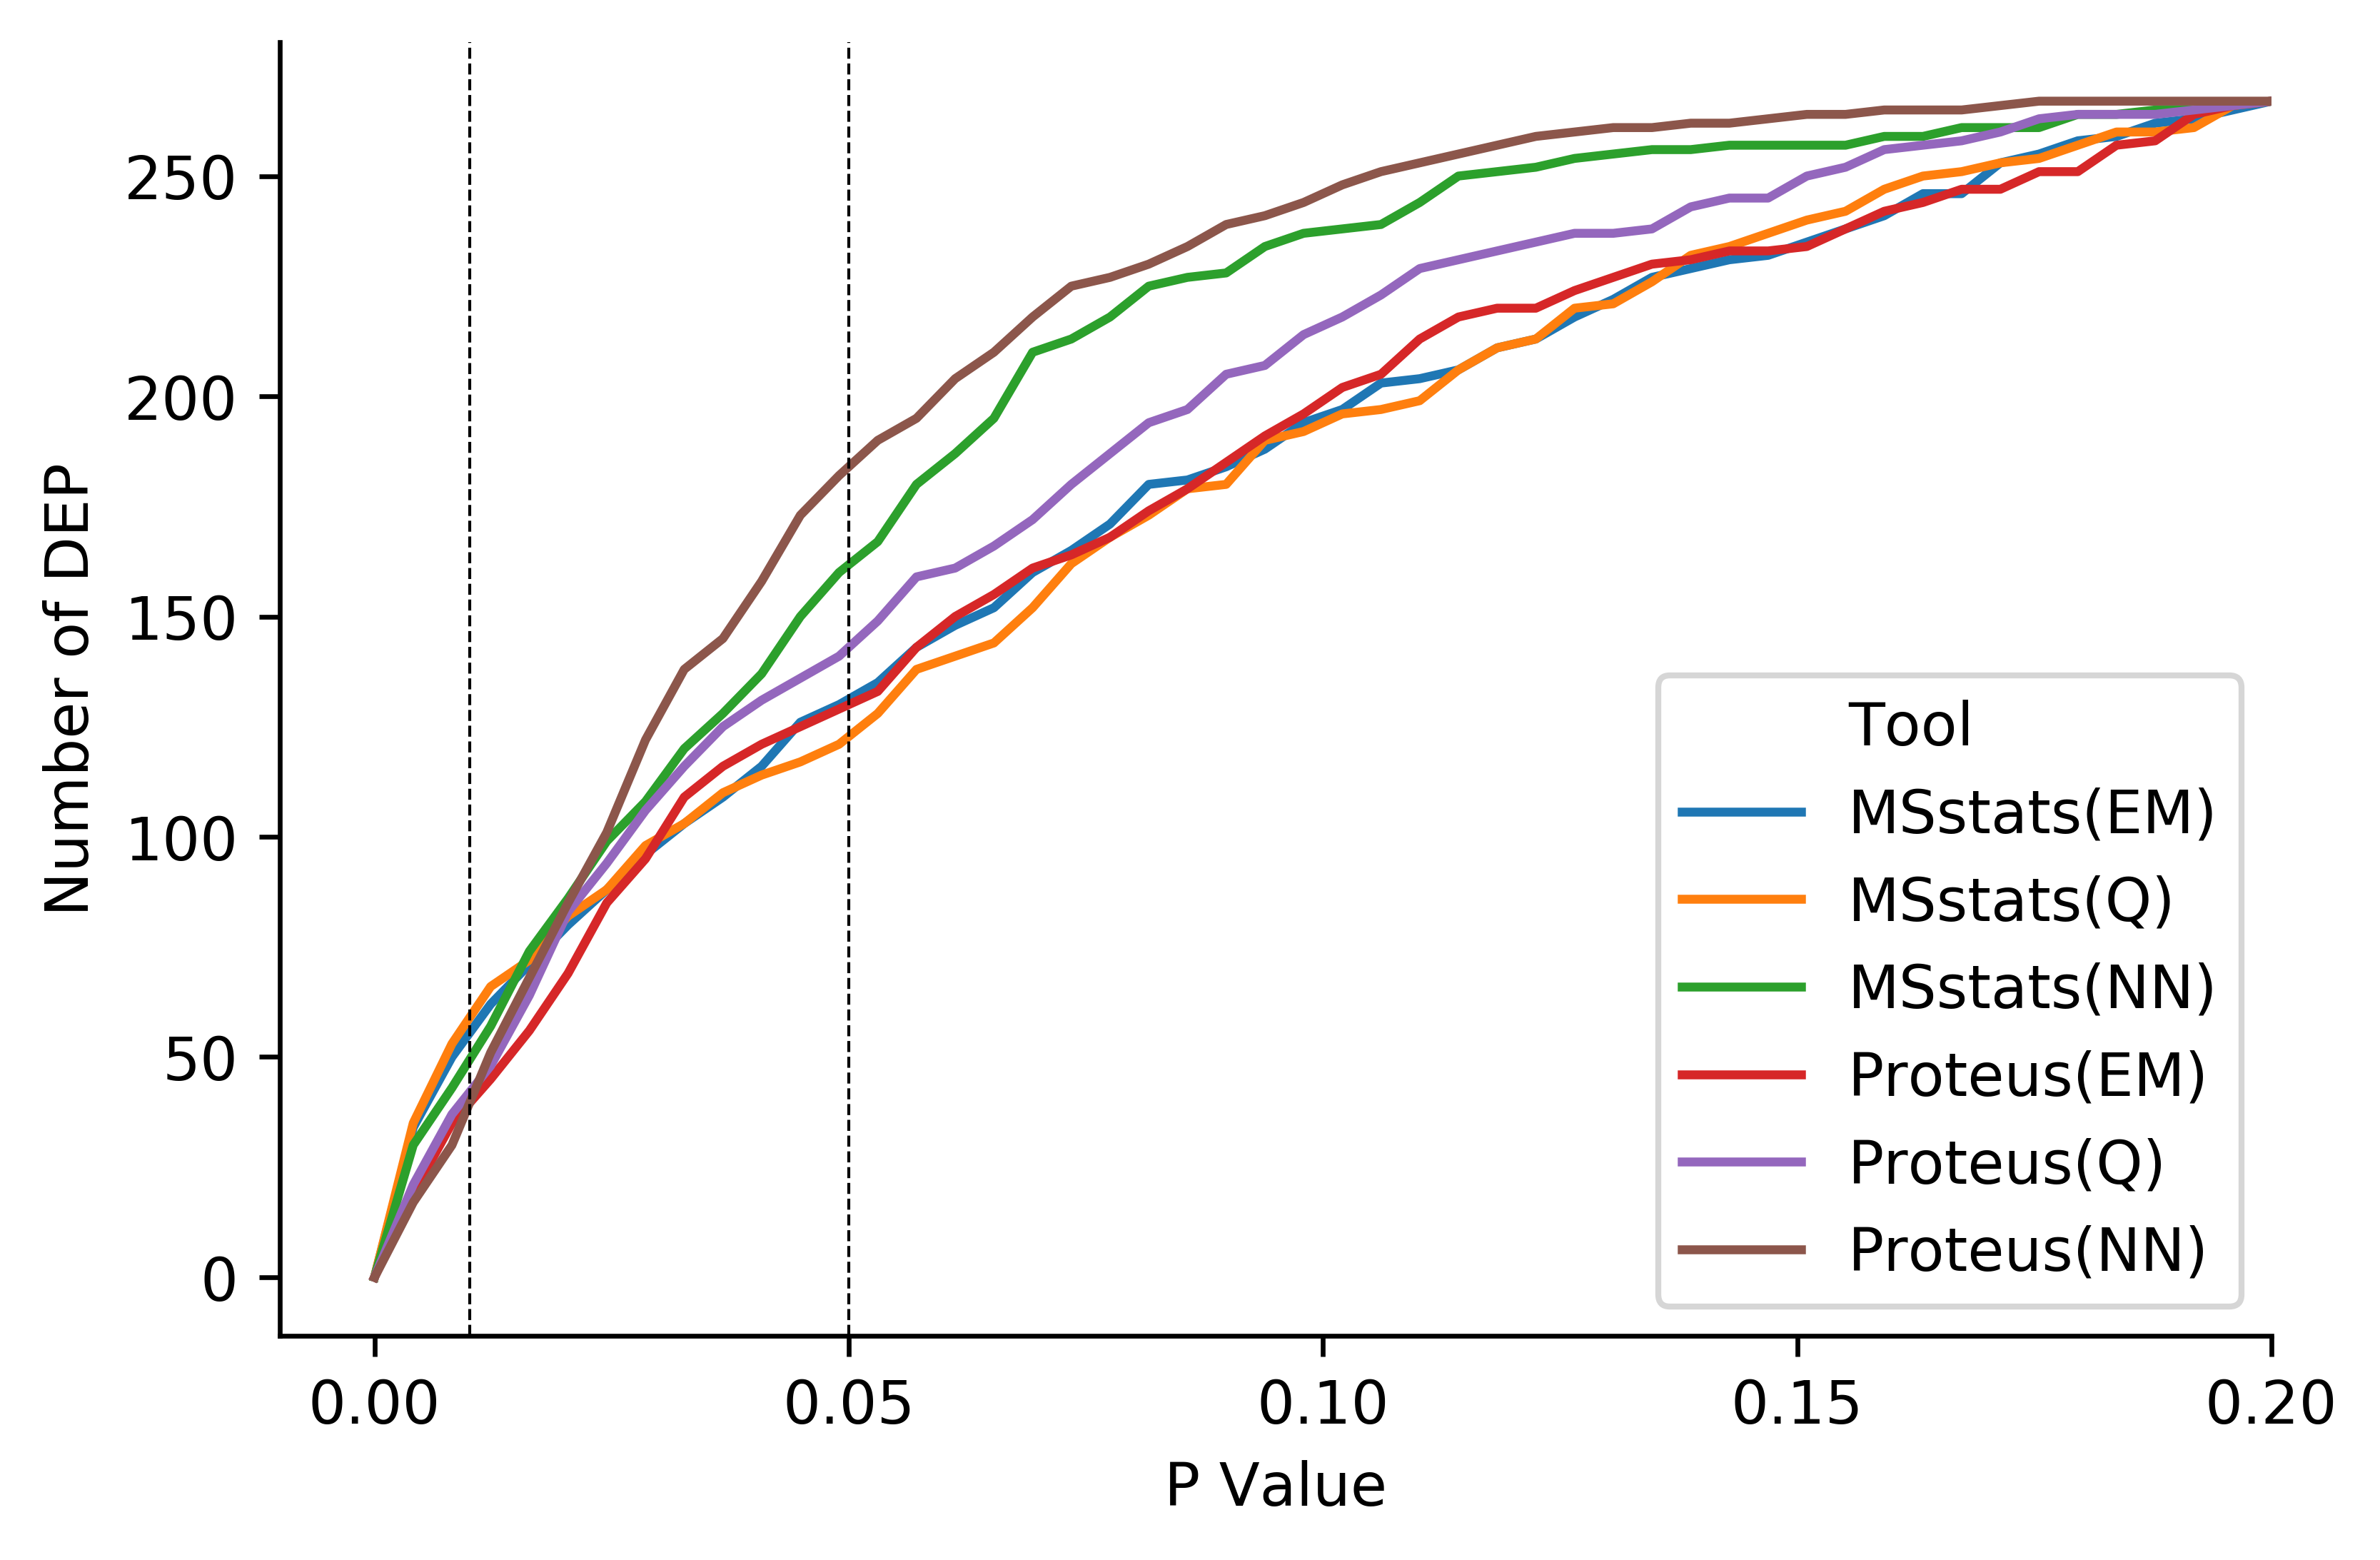

In [154]:
plot_number_adjpval = pd.DataFrame(columns=["x", "y", "Tool"])
x = np.linspace(0,0.2)

for i in x:
    tem = em_comparison_res[em_comparison_res["pvalue"] < i]
    j= len(tem[(tem["Protein"].isin(c))])
    
    plot_number_adjpval = plot_number_adjpval.append({"x": i, "y": j, "Tool": "MSstats(EM)"},ignore_index=True)
    
for i in x:
    tem = quantile_comparison_res[quantile_comparison_res["pvalue"] < i]
    j= len(tem[(tem["Protein"].isin(c))])
    
    plot_number_adjpval = plot_number_adjpval.append({"x": i, "y": j, "Tool": "MSstats(Q)"}, ignore_index=True)

for i in x:
    tem = no_normalization_comparison_res[no_normalization_comparison_res["pvalue"] < i]
    j= len(tem[(tem["Protein"].isin(c))])
    plot_number_adjpval = plot_number_adjpval.append({"x": i, "y": j, "Tool": "MSstats(NN)"}, ignore_index=True)

for i in x:
    tem = prodat_med_comp_res[prodat_med_comp_res["P.Value"] < i]
    j= len(tem[(tem["protein"].isin(c))])
    plot_number_adjpval = plot_number_adjpval.append({"x": i, "y": j, "Tool": "Proteus(EM)"}, ignore_index=True)
    
for i in x:
    tem = prodat_quantile_comp_res[prodat_quantile_comp_res["P.Value"] < i]
    j= len(tem[(tem["protein"].isin(c))])
    plot_number_adjpval = plot_number_adjpval.append({"x": i, "y": j, "Tool": "Proteus(Q)"}, ignore_index=True)
    
for i in x:
    tem = prodat_comp_res[prodat_comp_res["P.Value"] < i]
    j= len(tem[(tem["protein"].isin(c))])
    plot_number_adjpval = plot_number_adjpval.append({"x": i, "y": j, "Tool": "Proteus(NN)"}, ignore_index=True)
    
fig, ax = plt.subplots(dpi=600)

sns.lineplot(x="x", y="y", data=plot_number_adjpval, hue="Tool")

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

x_major_locator= plt.MultipleLocator(0.05)
ax.xaxis.set_major_locator(x_major_locator)

ax.axvline(x=0.05, c="black", linewidth=0.5, ls="--")
ax.axvline(x=0.01, ymax=1000 ,c="black", linewidth=0.5, ls="--")

# ax.legend(loc="lower right", frameon=False)
plt.xlabel("P Value")
plt.ylabel("Number of DEP")

plt.xlim(-0.01, 0.2)